# GPU implementation of Bfastmonitor using Python
The bfast package provides a highly-efficient parallel implementation for the Breaks For Additive Season and Trend (BFASTmonitor) proposed by Verbesselt et al. The implementation is based on OpenCL.

## This code runs bfastmonitor over an entire time series folder

The script below runs bfastmonitor over the timeseries data downloaded in SEPAL in blocks, and patches together tiles to export mean magnitudes and breaks as geotiffs, pngs, and .npy files. The output is also displayed in a digital map. Make sure to run through the cells sequentially.

* First download data using the SEPAL time series downloader (not in this script). The downloads will be saved in your downloads folder and look like: /home/'username'/downloads/Time_series_2020-09-01_16-22-26/0|1|2|3

* Import packages

* Select data

* Set parameters

* Select monitoring period

* Run bfastmonitor and save intermediate output

* Load output

* Merge and save output

* Display output




In [1]:
import os
from os.path import expanduser

import wget
import numpy as np
from datetime import datetime
import copy
import matplotlib
import matplotlib.pyplot as plt
import subprocess

import json

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal, gdal_array, osr

import time
from tqdm import tqdm

import ipywidgets as widgets
from ipywidgets import Layout
from ipyfilechooser import FileChooser
import folium

from PIL import Image
from matplotlib import cm

# import functions from functions.py
from functions import set_base_output_dir, set_output_dir, get_data_dict, merge_tiles, set_paths, _find_index_date, normalize, select_negatives, get_julian_dates
from plotting_funcs import save_plot, merge_plots, classify_output, plot_output_matplotlib, set_corners, export_GTiff, classify_magnitudes, merge_plots2

# Import the Timeseries class from time_series.py
from time_series import Timeseries
print(Timeseries.__doc__)

# Import widgets for GUI parameter selection
from widgets import get_widgets, get_dates_widgets
output_directory_chooser, k_chooser,freq_chooser,trend_chooser,hfrac_chooser,level_chooser,backend_chooser, load_chooser, block_size_chooser, plot_display_data_chooser = get_widgets()


    The timeseries class is a wrapper for using SEPAL timeseries data with bfast. 
    It wraps together a data tile with associated dates file and metadata. 
    It also allows for saving and loading the output rasters in a specified directory. 
    


In [2]:
%matplotlib inline

### Select output directory name. 

In [3]:
display(output_directory_chooser)

interactive(children=(Text(value='', description='Output storage name: (country/location name, e.g. "Guyana")'…

In [4]:
base_output_dir = set_base_output_dir(output_directory_chooser)

Defaulting to output directory name: stored_time_series/output


### Select your timeseries folder

In [5]:
path = expanduser("~")
file_chooser = FileChooser(path)
display(file_chooser)

FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

In [7]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)

/home/dven/downloads/Time_series_2020-10-08_12-33-34_Ghana/


### Select the directories you are interested in

In [8]:
items = [widgets.Checkbox(value = True,description = i) for i in os.listdir(timeseries_directory)]
widgets.VBox(items)

In [47]:
# set path to dates file and create Timeseries objects of tiles
load_list=[]
for xi in items:
    if xi.value == True:
        load_list.append(xi.description)

run_dict = {}
for directory in load_list:
    
    segment_location = timeseries_directory + directory + "/"
    save_location = base_output_dir +"/"+ directory + "/"
    
    data_list = set_paths(timeseries_directory = segment_location, save_location = save_location, check_existing = True)
    run_dict[directory] = data_list


# check for dirs that will be analyzed
del_list = []
for directory in run_dict:
    
    if run_dict[directory]:
        print(len(run_dict[directory]))
    else:
        print("Warning, All tiles for directory " + directory +  " have already generated output, if you want to run again, change your output_dir_name or set check_existing above to False")
        del_list.append(directory)

# remove dirs that have already run
for item in del_list:
    del run_dict[item]


Data consists of tiles, setting up tiles in 'data_list' 
Data consists of tiles, setting up tiles in 'data_list' 
4
5


### Choose parameters

In [48]:
# Choose parameters
display(k_chooser)
display(freq_chooser)
display(trend_chooser)
display(hfrac_chooser)
display(level_chooser)
display(backend_chooser)

interactive(children=(Dropdown(description='k, harmonic terms', index=2, layout=Layout(height='auto', width='5…

interactive(children=(IntSlider(value=365, description='freq, frequency of seasonal model (days)', layout=Layo…

interactive(children=(Checkbox(value=False, description='add trend', layout=Layout(height='auto', width='500px…

interactive(children=(FloatSlider(value=0.25, description='Bandwith relative to sample size', layout=Layout(he…

interactive(children=(SelectionSlider(description='Significance level of the monitoring', layout=Layout(height…

interactive(children=(Dropdown(description='backend', layout=Layout(height='auto', width='500px'), options=('o…

In [49]:
# Set parameters
k = k_chooser.result
freq = freq_chooser.result
trend = trend_chooser.result
hfrac = hfrac_chooser.result
level = 1 - level_chooser.result
backend = backend_chooser.result
verbose = 1
device_id = 0

### Choose history and monitoring period

In [50]:
data_list = run_dict[next(iter(run_dict))]

dates = data_list[0].dates
start_date = dates[0]
end_date = dates[-1]
pandas_dates = pd.date_range(start_date, end_date, freq='W')

options =  [(date.strftime('%Y-%m-%d'), date) for date in pandas_dates]
index = (0, len(options)-1)

monitoring_period_chooser, history_period_chooser = get_dates_widgets(options = options, index = index)

display(monitoring_period_chooser)
display(history_period_chooser)

interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 345), l…

interactive(children=(SelectionSlider(description='Start history period:', options=(('2014-01-12', Timestamp('…

In [15]:
start_monitor, end_monitor = monitoring_period_chooser.result
start_hist = history_period_chooser.result
print(start_monitor)
if history_period_chooser.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

if start_monitor < dates[50]:
    raise Warning("Your history period is relatively short, did you move the monitoring date range to a later date?")

2017-01-01 00:00:00


### Choose block size (512 recommended)

In [16]:
display(block_size_chooser)

interactive(children=(Dropdown(description='block size, bigger is generally faster, but may result in memory i…

## Run bfast

In [17]:
x_block = y_block = block_size_chooser.result


for data_list in run_dict:
    # loading bar
    with tqdm(total=len(run_dict)) as pbar1:
        
        
        save_location = base_output_dir + "/" + data_list
        if not os.path.exists(save_location):
            os.makedirs(save_location)
        

        # loop over tile(s) in the data_list
        for counter, tile in enumerate(run_dict[data_list]):
            pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(run_dict[data_list])) )

            tile.set_bfast_parameters(start_monitor = start_monitor, 
                                         end_monitor = end_monitor,
                                         start_hist = start_hist,
                                         freq = freq,
                                         k = k,
                                         hfrac = hfrac,
                                         trend = trend,
                                         level = level,
                                         backend=backend,
                                         verbose=verbose,
                                         device_id=device_id)

            tile.get_bfast_parameters()

            tile.loop_blocks(x_block_size = x_block,
                                y_block_size = y_block)

            tile.log_all_output(output_dir_name=save_location)

            run_dict[data_list][counter] = '0'
            del(tile)

            pbar1.update(1)

    pbar1.close()


Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:12<00:00, 12.50s/it]

--- runtime for data initialization:		0.11487960815429688
--- runtime for data transfer (host->device):	0.039006710052490234
--- runtime for data preprocessing:		0.00882720947265625
--- runtime for kernel execution:		0.0623936653137207
--- runtime for data transfer (device->host):	0.016384363174438477
Fitting model over all blocks took 12.501341104507446 seconds.



Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.38s/it]

--- runtime for data initialization:		0.0016961097717285156
--- runtime for data transfer (host->device):	0.03888440132141113
--- runtime for data preprocessing:		0.007915258407592773
--- runtime for kernel execution:		0.06233716011047363
--- runtime for data transfer (device->host):	0.01639556884765625
Fitting model over all blocks took 7.382714748382568 seconds.



Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.29s/it]

--- runtime for data initialization:		0.0016362667083740234
--- runtime for data transfer (host->device):	0.03888225555419922
--- runtime for data preprocessing:		0.007871389389038086
--- runtime for kernel execution:		0.06231379508972168
--- runtime for data transfer (device->host):	0.016177654266357422
Fitting model over all blocks took 7.2950074672698975 seconds.



Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.28s/it]

--- runtime for data initialization:		0.0016603469848632812
--- runtime for data transfer (host->device):	0.0387721061706543
--- runtime for data preprocessing:		0.007890939712524414
--- runtime for kernel execution:		0.062284231185913086
--- runtime for data transfer (device->host):	0.016425132751464844
Fitting model over all blocks took 7.279601097106934 seconds.



Processing tile 5 out of 225: : 4it [00:35,  9.31s/it]                     
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.38s/it]

--- runtime for data initialization:		0.0015933513641357422
--- runtime for data transfer (host->device):	0.03881716728210449
--- runtime for data preprocessing:		0.00781869888305664
--- runtime for kernel execution:		0.062393903732299805
--- runtime for data transfer (device->host):	0.016422748565673828
Fitting model over all blocks took 7.384426593780518 seconds.



Processing tile 6 out of 225: : 5it [00:43,  8.80s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.81s/it]

--- runtime for data initialization:		0.0016028881072998047
--- runtime for data transfer (host->device):	0.03869509696960449
--- runtime for data preprocessing:		0.007851362228393555
--- runtime for kernel execution:		0.0623931884765625
--- runtime for data transfer (device->host):	0.016194820404052734
Fitting model over all blocks took 7.817928314208984 seconds.



Processing tile 7 out of 225: : 6it [00:51,  8.58s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.91s/it]

--- runtime for data initialization:		0.0016689300537109375
--- runtime for data transfer (host->device):	0.03896784782409668
--- runtime for data preprocessing:		0.00786590576171875
--- runtime for kernel execution:		0.06249403953552246
--- runtime for data transfer (device->host):	0.016382694244384766
Fitting model over all blocks took 7.909822225570679 seconds.



Processing tile 8 out of 225: : 7it [00:59,  8.45s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.60s/it]

--- runtime for data initialization:		0.001613616943359375
--- runtime for data transfer (host->device):	0.03903675079345703
--- runtime for data preprocessing:		0.007889747619628906
--- runtime for kernel execution:		0.0624539852142334
--- runtime for data transfer (device->host):	0.016247272491455078
Fitting model over all blocks took 7.6048736572265625 seconds.



Processing tile 9 out of 225: : 8it [01:07,  8.26s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.97s/it]

--- runtime for data initialization:		0.0016181468963623047
--- runtime for data transfer (host->device):	0.03880047798156738
--- runtime for data preprocessing:		0.007864952087402344
--- runtime for kernel execution:		0.06233930587768555
--- runtime for data transfer (device->host):	0.016596078872680664
Fitting model over all blocks took 7.97096848487854 seconds.



Processing tile 10 out of 225: : 9it [01:15,  8.24s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.88s/it]

--- runtime for data initialization:		0.0016264915466308594
--- runtime for data transfer (host->device):	0.0388638973236084
--- runtime for data preprocessing:		0.007888555526733398
--- runtime for kernel execution:		0.062369346618652344
--- runtime for data transfer (device->host):	0.016436338424682617
Fitting model over all blocks took 7.8791444301605225 seconds.



Processing tile 11 out of 225: : 10it [01:23,  8.20s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]

--- runtime for data initialization:		0.0016405582427978516
--- runtime for data transfer (host->device):	0.03896474838256836
--- runtime for data preprocessing:		0.007841825485229492
--- runtime for kernel execution:		0.06249547004699707
--- runtime for data transfer (device->host):	0.016450881958007812
Fitting model over all blocks took 7.641845703125 seconds.



Processing tile 12 out of 225: : 11it [01:31,  8.10s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.47s/it]

--- runtime for data initialization:		0.001627206802368164
--- runtime for data transfer (host->device):	0.038843631744384766
--- runtime for data preprocessing:		0.00782012939453125
--- runtime for kernel execution:		0.06249380111694336
--- runtime for data transfer (device->host):	0.015281200408935547
Fitting model over all blocks took 7.473268508911133 seconds.



Processing tile 13 out of 225: : 12it [01:38,  7.98s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]

--- runtime for data initialization:		0.00162506103515625
--- runtime for data transfer (host->device):	0.038928985595703125
--- runtime for data preprocessing:		0.007861137390136719
--- runtime for kernel execution:		0.06234622001647949
--- runtime for data transfer (device->host):	0.016492128372192383
Fitting model over all blocks took 7.76350736618042 seconds.



Processing tile 14 out of 225: : 13it [01:46,  7.98s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.36s/it]

--- runtime for data initialization:		0.0016448497772216797
--- runtime for data transfer (host->device):	0.038849830627441406
--- runtime for data preprocessing:		0.007910966873168945
--- runtime for kernel execution:		0.062302589416503906
--- runtime for data transfer (device->host):	0.016457319259643555
Fitting model over all blocks took 7.362853527069092 seconds.



Processing tile 15 out of 225: : 14it [01:54,  7.87s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:05,  5.15s/it]
Processing tile 15 out of 225: : 15it [01:59,  7.11s/it]

--- runtime for data initialization:		0.0016665458679199219
--- runtime for data transfer (host->device):	0.019518136978149414
--- runtime for data preprocessing:		0.005219697952270508
--- runtime for kernel execution:		0.030988216400146484
--- runtime for data transfer (device->host):	0.008085489273071289
Fitting model over all blocks took 5.15275502204895 seconds.


Processing tile 16 out of 225: : 15it [01:59,  7.11s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it]

--- runtime for data initialization:		0.0016214847564697266
--- runtime for data transfer (host->device):	0.03884625434875488
--- runtime for data preprocessing:		0.007825374603271484
--- runtime for kernel execution:		0.062383174896240234
--- runtime for data transfer (device->host):	0.016437768936157227
Fitting model over all blocks took 7.077932596206665 seconds.



Processing tile 17 out of 225: : 16it [02:07,  7.16s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.22s/it]

--- runtime for data initialization:		0.001598358154296875
--- runtime for data transfer (host->device):	0.038732051849365234
--- runtime for data preprocessing:		0.007811546325683594
--- runtime for kernel execution:		0.0624082088470459
--- runtime for data transfer (device->host):	0.016420364379882812
Fitting model over all blocks took 7.224668264389038 seconds.



Processing tile 18 out of 225: : 17it [02:14,  7.24s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.31s/it]

--- runtime for data initialization:		0.0016489028930664062
--- runtime for data transfer (host->device):	0.03878068923950195
--- runtime for data preprocessing:		0.007843732833862305
--- runtime for kernel execution:		0.062367916107177734
--- runtime for data transfer (device->host):	0.014814138412475586
Fitting model over all blocks took 7.311229467391968 seconds.



Processing tile 19 out of 225: : 18it [02:22,  7.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.30s/it]

--- runtime for data initialization:		0.0016245841979980469
--- runtime for data transfer (host->device):	0.03898167610168457
--- runtime for data preprocessing:		0.007921934127807617
--- runtime for kernel execution:		0.062387704849243164
--- runtime for data transfer (device->host):	0.016394853591918945
Fitting model over all blocks took 7.300683975219727 seconds.



Processing tile 20 out of 225: : 19it [02:29,  7.38s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]

--- runtime for data initialization:		0.0016317367553710938
--- runtime for data transfer (host->device):	0.03880190849304199
--- runtime for data preprocessing:		0.007868528366088867
--- runtime for kernel execution:		0.06248044967651367
--- runtime for data transfer (device->host):	0.01645493507385254
Fitting model over all blocks took 7.494568347930908 seconds.



Processing tile 21 out of 225: : 20it [02:37,  7.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.42s/it]

--- runtime for data initialization:		0.0016269683837890625
--- runtime for data transfer (host->device):	0.0388486385345459
--- runtime for data preprocessing:		0.007853507995605469
--- runtime for kernel execution:		0.0625159740447998
--- runtime for data transfer (device->host):	0.016422033309936523
Fitting model over all blocks took 7.426167964935303 seconds.



Processing tile 22 out of 225: : 21it [02:44,  7.53s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.27s/it]

--- runtime for data initialization:		0.0016486644744873047
--- runtime for data transfer (host->device):	0.038942813873291016
--- runtime for data preprocessing:		0.007896661758422852
--- runtime for kernel execution:		0.0623171329498291
--- runtime for data transfer (device->host):	0.01641702651977539
Fitting model over all blocks took 7.276385307312012 seconds.



Processing tile 23 out of 225: : 22it [02:52,  7.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.55s/it]

--- runtime for data initialization:		0.0016658306121826172
--- runtime for data transfer (host->device):	0.038877010345458984
--- runtime for data preprocessing:		0.007853269577026367
--- runtime for kernel execution:		0.062490224838256836
--- runtime for data transfer (device->host):	0.016463756561279297
Fitting model over all blocks took 7.553194046020508 seconds.



Processing tile 24 out of 225: : 23it [03:00,  7.58s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]

--- runtime for data initialization:		0.0016336441040039062
--- runtime for data transfer (host->device):	0.03878021240234375
--- runtime for data preprocessing:		0.007861137390136719
--- runtime for kernel execution:		0.06242728233337402
--- runtime for data transfer (device->host):	0.01648235321044922
Fitting model over all blocks took 7.6452953815460205 seconds.



Processing tile 25 out of 225: : 24it [03:08,  7.66s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.53s/it]

--- runtime for data initialization:		0.0016870498657226562
--- runtime for data transfer (host->device):	0.038842201232910156
--- runtime for data preprocessing:		0.00788569450378418
--- runtime for kernel execution:		0.06253576278686523
--- runtime for data transfer (device->host):	0.01641106605529785
Fitting model over all blocks took 7.534810304641724 seconds.



Processing tile 26 out of 225: : 25it [03:15,  7.69s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.47s/it]

--- runtime for data initialization:		0.0016608238220214844
--- runtime for data transfer (host->device):	0.03887748718261719
--- runtime for data preprocessing:		0.00781702995300293
--- runtime for kernel execution:		0.06249594688415527
--- runtime for data transfer (device->host):	0.016419649124145508
Fitting model over all blocks took 7.473543167114258 seconds.



Processing tile 27 out of 225: : 26it [03:23,  7.69s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.61s/it]

--- runtime for data initialization:		0.001619577407836914
--- runtime for data transfer (host->device):	0.03885006904602051
--- runtime for data preprocessing:		0.00783228874206543
--- runtime for kernel execution:		0.06237363815307617
--- runtime for data transfer (device->host):	0.01640629768371582
Fitting model over all blocks took 7.615720510482788 seconds.



Processing tile 28 out of 225: : 27it [03:31,  7.73s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

--- runtime for data initialization:		0.0016436576843261719
--- runtime for data transfer (host->device):	0.03896045684814453
--- runtime for data preprocessing:		0.007856369018554688
--- runtime for kernel execution:		0.06253266334533691
--- runtime for data transfer (device->host):	0.016447067260742188
Fitting model over all blocks took 7.478892803192139 seconds.



Processing tile 29 out of 225: : 28it [03:39,  7.72s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.52s/it]

--- runtime for data initialization:		0.0016164779663085938
--- runtime for data transfer (host->device):	0.038779258728027344
--- runtime for data preprocessing:		0.007814407348632812
--- runtime for kernel execution:		0.06243300437927246
--- runtime for data transfer (device->host):	0.01627326011657715
Fitting model over all blocks took 7.527148962020874 seconds.



Processing tile 30 out of 225: : 29it [03:46,  7.74s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:05,  5.15s/it]
Processing tile 30 out of 225: : 30it [03:52,  7.02s/it]

--- runtime for data initialization:		0.0015997886657714844
--- runtime for data transfer (host->device):	0.019500732421875
--- runtime for data preprocessing:		0.005262613296508789
--- runtime for kernel execution:		0.03087902069091797
--- runtime for data transfer (device->host):	0.008132696151733398
Fitting model over all blocks took 5.15500807762146 seconds.


Processing tile 31 out of 225: : 30it [03:52,  7.02s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]

--- runtime for data initialization:		0.0016663074493408203
--- runtime for data transfer (host->device):	0.03878355026245117
--- runtime for data preprocessing:		0.007857561111450195
--- runtime for kernel execution:		0.0625
--- runtime for data transfer (device->host):	0.016417503356933594
Fitting model over all blocks took 6.733988046646118 seconds.



Processing tile 32 out of 225: : 31it [03:59,  6.99s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.05s/it]

--- runtime for data initialization:		0.0016579627990722656
--- runtime for data transfer (host->device):	0.03881573677062988
--- runtime for data preprocessing:		0.007869958877563477
--- runtime for kernel execution:		0.06251740455627441
--- runtime for data transfer (device->host):	0.014435052871704102
Fitting model over all blocks took 7.051400661468506 seconds.



Processing tile 33 out of 225: : 32it [04:06,  7.07s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.36s/it]

--- runtime for data initialization:		0.0016837120056152344
--- runtime for data transfer (host->device):	0.03881692886352539
--- runtime for data preprocessing:		0.007928609848022461
--- runtime for kernel execution:		0.06245923042297363
--- runtime for data transfer (device->host):	0.016434431076049805
Fitting model over all blocks took 7.363814115524292 seconds.



Processing tile 34 out of 225: : 33it [04:13,  7.22s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.51s/it]

--- runtime for data initialization:		0.0016520023345947266
--- runtime for data transfer (host->device):	0.03888392448425293
--- runtime for data preprocessing:		0.007839202880859375
--- runtime for kernel execution:		0.06251287460327148
--- runtime for data transfer (device->host):	0.0164339542388916
Fitting model over all blocks took 7.517414093017578 seconds.



Processing tile 35 out of 225: : 34it [04:21,  7.38s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.44s/it]

--- runtime for data initialization:		0.0016651153564453125
--- runtime for data transfer (host->device):	0.038823604583740234
--- runtime for data preprocessing:		0.00790095329284668
--- runtime for kernel execution:		0.062467336654663086
--- runtime for data transfer (device->host):	0.01641845703125
Fitting model over all blocks took 7.448186874389648 seconds.



Processing tile 36 out of 225: : 35it [04:29,  7.46s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.29s/it]

--- runtime for data initialization:		0.0016312599182128906
--- runtime for data transfer (host->device):	0.03901815414428711
--- runtime for data preprocessing:		0.007903099060058594
--- runtime for kernel execution:		0.062439680099487305
--- runtime for data transfer (device->host):	0.016231775283813477
Fitting model over all blocks took 7.29313850402832 seconds.



Processing tile 37 out of 225: : 36it [04:36,  7.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.22s/it]

--- runtime for data initialization:		0.0016765594482421875
--- runtime for data transfer (host->device):	0.03880453109741211
--- runtime for data preprocessing:		0.00786447525024414
--- runtime for kernel execution:		0.0623784065246582
--- runtime for data transfer (device->host):	0.01621246337890625
Fitting model over all blocks took 7.224225282669067 seconds.



Processing tile 38 out of 225: : 37it [04:44,  7.45s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

--- runtime for data initialization:		0.0016360282897949219
--- runtime for data transfer (host->device):	0.03875994682312012
--- runtime for data preprocessing:		0.007915019989013672
--- runtime for kernel execution:		0.06245136260986328
--- runtime for data transfer (device->host):	0.01646709442138672
Fitting model over all blocks took 7.828076124191284 seconds.



Processing tile 39 out of 225: : 38it [04:52,  7.63s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.27s/it]

--- runtime for data initialization:		0.0016222000122070312
--- runtime for data transfer (host->device):	0.03891897201538086
--- runtime for data preprocessing:		0.007898092269897461
--- runtime for kernel execution:		0.0625295639038086
--- runtime for data transfer (device->host):	0.016476869583129883
Fitting model over all blocks took 7.272401571273804 seconds.



Processing tile 40 out of 225: : 39it [04:59,  7.59s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]

--- runtime for data initialization:		0.0016417503356933594
--- runtime for data transfer (host->device):	0.03880500793457031
--- runtime for data preprocessing:		0.007848739624023438
--- runtime for kernel execution:		0.06253433227539062
--- runtime for data transfer (device->host):	0.015383481979370117
Fitting model over all blocks took 7.036599159240723 seconds.



Processing tile 41 out of 225: : 40it [05:06,  7.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it]

--- runtime for data initialization:		0.0015964508056640625
--- runtime for data transfer (host->device):	0.03887200355529785
--- runtime for data preprocessing:		0.007871150970458984
--- runtime for kernel execution:		0.06248974800109863
--- runtime for data transfer (device->host):	0.01641225814819336
Fitting model over all blocks took 7.069017171859741 seconds.



Processing tile 42 out of 225: : 41it [05:14,  7.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.12s/it]

--- runtime for data initialization:		0.0016138553619384766
--- runtime for data transfer (host->device):	0.0387570858001709
--- runtime for data preprocessing:		0.007817268371582031
--- runtime for kernel execution:		0.06244325637817383
--- runtime for data transfer (device->host):	0.016427993774414062
Fitting model over all blocks took 7.125202178955078 seconds.



Processing tile 43 out of 225: : 42it [05:21,  7.39s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.20s/it]

--- runtime for data initialization:		0.0016400814056396484
--- runtime for data transfer (host->device):	0.038725852966308594
--- runtime for data preprocessing:		0.007827281951904297
--- runtime for kernel execution:		0.06247401237487793
--- runtime for data transfer (device->host):	0.016255617141723633
Fitting model over all blocks took 7.201303005218506 seconds.



Processing tile 44 out of 225: : 43it [05:28,  7.40s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.42s/it]

--- runtime for data initialization:		0.0016453266143798828
--- runtime for data transfer (host->device):	0.03882741928100586
--- runtime for data preprocessing:		0.007834434509277344
--- runtime for kernel execution:		0.06255149841308594
--- runtime for data transfer (device->host):	0.016471385955810547
Fitting model over all blocks took 7.4184956550598145 seconds.



Processing tile 45 out of 225: : 44it [05:36,  7.46s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:05,  5.29s/it]
Processing tile 45 out of 225: : 45it [05:41,  6.87s/it]

--- runtime for data initialization:		0.0016207695007324219
--- runtime for data transfer (host->device):	0.019547700881958008
--- runtime for data preprocessing:		0.00528717041015625
--- runtime for kernel execution:		0.030923128128051758
--- runtime for data transfer (device->host):	0.008108377456665039
Fitting model over all blocks took 5.292257785797119 seconds.


Processing tile 46 out of 225: : 45it [05:42,  6.87s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.57s/it]

--- runtime for data initialization:		0.0016181468963623047
--- runtime for data transfer (host->device):	0.03887224197387695
--- runtime for data preprocessing:		0.007886886596679688
--- runtime for kernel execution:		0.06256341934204102
--- runtime for data transfer (device->host):	0.016405344009399414
Fitting model over all blocks took 7.577259302139282 seconds.



Processing tile 47 out of 225: : 46it [05:49,  7.14s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.43s/it]

--- runtime for data initialization:		0.0016665458679199219
--- runtime for data transfer (host->device):	0.0388178825378418
--- runtime for data preprocessing:		0.007859468460083008
--- runtime for kernel execution:		0.062334537506103516
--- runtime for data transfer (device->host):	0.016500473022460938
Fitting model over all blocks took 7.434313535690308 seconds.



Processing tile 48 out of 225: : 47it [05:57,  7.29s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]

--- runtime for data initialization:		0.0016851425170898438
--- runtime for data transfer (host->device):	0.03900623321533203
--- runtime for data preprocessing:		0.007940530776977539
--- runtime for kernel execution:		0.06252670288085938
--- runtime for data transfer (device->host):	0.01644110679626465
Fitting model over all blocks took 7.417464971542358 seconds.



Processing tile 49 out of 225: : 48it [06:05,  7.39s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.57s/it]

--- runtime for data initialization:		0.001695394515991211
--- runtime for data transfer (host->device):	0.038822174072265625
--- runtime for data preprocessing:		0.00791621208190918
--- runtime for kernel execution:		0.06260943412780762
--- runtime for data transfer (device->host):	0.01642012596130371
Fitting model over all blocks took 7.570518732070923 seconds.



Processing tile 50 out of 225: : 49it [06:12,  7.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.50s/it]

--- runtime for data initialization:		0.0016825199127197266
--- runtime for data transfer (host->device):	0.03885793685913086
--- runtime for data preprocessing:		0.007899284362792969
--- runtime for kernel execution:		0.06251001358032227
--- runtime for data transfer (device->host):	0.016456127166748047
Fitting model over all blocks took 7.5061798095703125 seconds.



Processing tile 51 out of 225: : 50it [06:20,  7.58s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.43s/it]

--- runtime for data initialization:		0.0016887187957763672
--- runtime for data transfer (host->device):	0.03890252113342285
--- runtime for data preprocessing:		0.007849931716918945
--- runtime for kernel execution:		0.062480926513671875
--- runtime for data transfer (device->host):	0.016378402709960938
Fitting model over all blocks took 7.433610677719116 seconds.



Processing tile 52 out of 225: : 51it [06:28,  7.60s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.28s/it]

--- runtime for data initialization:		0.0016529560089111328
--- runtime for data transfer (host->device):	0.03891754150390625
--- runtime for data preprocessing:		0.007834911346435547
--- runtime for kernel execution:		0.062482595443725586
--- runtime for data transfer (device->host):	0.016396284103393555
Fitting model over all blocks took 7.288216829299927 seconds.



Processing tile 53 out of 225: : 52it [06:35,  7.57s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]

--- runtime for data initialization:		0.0016469955444335938
--- runtime for data transfer (host->device):	0.03881025314331055
--- runtime for data preprocessing:		0.00784158706665039
--- runtime for kernel execution:		0.06251120567321777
--- runtime for data transfer (device->host):	0.01650094985961914
Fitting model over all blocks took 7.6404149532318115 seconds.



Processing tile 54 out of 225: : 53it [06:43,  7.66s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.21s/it]

--- runtime for data initialization:		0.0016438961029052734
--- runtime for data transfer (host->device):	0.03888583183288574
--- runtime for data preprocessing:		0.007825136184692383
--- runtime for kernel execution:		0.06254863739013672
--- runtime for data transfer (device->host):	0.01644420623779297
Fitting model over all blocks took 7.216548681259155 seconds.



Processing tile 55 out of 225: : 54it [06:51,  7.59s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]

--- runtime for data initialization:		0.0016179084777832031
--- runtime for data transfer (host->device):	0.03897428512573242
--- runtime for data preprocessing:		0.007812023162841797
--- runtime for kernel execution:		0.06243109703063965
--- runtime for data transfer (device->host):	0.016414880752563477
Fitting model over all blocks took 7.031558275222778 seconds.



Processing tile 56 out of 225: : 55it [06:58,  7.49s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.01s/it]

--- runtime for data initialization:		0.0016586780548095703
--- runtime for data transfer (host->device):	0.03873467445373535
--- runtime for data preprocessing:		0.007805824279785156
--- runtime for kernel execution:		0.062425851821899414
--- runtime for data transfer (device->host):	0.01643657684326172
Fitting model over all blocks took 7.016133546829224 seconds.



Processing tile 57 out of 225: : 56it [07:05,  7.41s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.21s/it]

--- runtime for data initialization:		0.001720428466796875
--- runtime for data transfer (host->device):	0.03896188735961914
--- runtime for data preprocessing:		0.00786137580871582
--- runtime for kernel execution:		0.06250739097595215
--- runtime for data transfer (device->host):	0.016239404678344727
Fitting model over all blocks took 7.216440200805664 seconds.



Processing tile 58 out of 225: : 57it [07:12,  7.41s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.16s/it]

--- runtime for data initialization:		0.0016591548919677734
--- runtime for data transfer (host->device):	0.03892397880554199
--- runtime for data preprocessing:		0.00785517692565918
--- runtime for kernel execution:		0.06235933303833008
--- runtime for data transfer (device->host):	0.016396760940551758
Fitting model over all blocks took 7.160432577133179 seconds.



Processing tile 59 out of 225: : 58it [07:20,  7.44s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.18s/it]

--- runtime for data initialization:		0.00159454345703125
--- runtime for data transfer (host->device):	0.038897037506103516
--- runtime for data preprocessing:		0.007907390594482422
--- runtime for kernel execution:		0.06258320808410645
--- runtime for data transfer (device->host):	0.016420841217041016
Fitting model over all blocks took 7.185788869857788 seconds.



Processing tile 60 out of 225: : 59it [07:27,  7.42s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:05,  5.10s/it]
Processing tile 60 out of 225: : 60it [07:33,  6.78s/it]

--- runtime for data initialization:		0.0016415119171142578
--- runtime for data transfer (host->device):	0.019609689712524414
--- runtime for data preprocessing:		0.005419731140136719
--- runtime for kernel execution:		0.03095531463623047
--- runtime for data transfer (device->host):	0.008137702941894531
Fitting model over all blocks took 5.101862192153931 seconds.


Processing tile 61 out of 225: : 60it [07:33,  6.78s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.63s/it]

--- runtime for data initialization:		0.0016086101531982422
--- runtime for data transfer (host->device):	0.03901553153991699
--- runtime for data preprocessing:		0.00788116455078125
--- runtime for kernel execution:		0.0624997615814209
--- runtime for data transfer (device->host):	0.016403913497924805
Fitting model over all blocks took 7.638004779815674 seconds.



Processing tile 62 out of 225: : 61it [07:40,  7.09s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.09s/it]

--- runtime for data initialization:		0.0016541481018066406
--- runtime for data transfer (host->device):	0.03879690170288086
--- runtime for data preprocessing:		0.007889270782470703
--- runtime for kernel execution:		0.06259822845458984
--- runtime for data transfer (device->host):	0.016411781311035156
Fitting model over all blocks took 7.092944622039795 seconds.



Processing tile 63 out of 225: : 62it [07:48,  7.15s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.17s/it]

--- runtime for data initialization:		0.0016088485717773438
--- runtime for data transfer (host->device):	0.03889966011047363
--- runtime for data preprocessing:		0.007915973663330078
--- runtime for kernel execution:		0.06250786781311035
--- runtime for data transfer (device->host):	0.01645827293395996
Fitting model over all blocks took 7.171684980392456 seconds.



Processing tile 64 out of 225: : 63it [07:55,  7.23s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.15s/it]

--- runtime for data initialization:		0.0016984939575195312
--- runtime for data transfer (host->device):	0.03886866569519043
--- runtime for data preprocessing:		0.007846832275390625
--- runtime for kernel execution:		0.06258320808410645
--- runtime for data transfer (device->host):	0.016421794891357422
Fitting model over all blocks took 7.150975704193115 seconds.



Processing tile 65 out of 225: : 64it [08:03,  7.27s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]

--- runtime for data initialization:		0.00164794921875
--- runtime for data transfer (host->device):	0.03889918327331543
--- runtime for data preprocessing:		0.007894754409790039
--- runtime for kernel execution:		0.06255412101745605
--- runtime for data transfer (device->host):	0.016423463821411133
Fitting model over all blocks took 7.3252387046813965 seconds.



Processing tile 66 out of 225: : 65it [08:10,  7.34s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.21s/it]

--- runtime for data initialization:		0.0016832351684570312
--- runtime for data transfer (host->device):	0.03884315490722656
--- runtime for data preprocessing:		0.007858991622924805
--- runtime for kernel execution:		0.06258463859558105
--- runtime for data transfer (device->host):	0.016416549682617188
Fitting model over all blocks took 7.215847015380859 seconds.



Processing tile 67 out of 225: : 66it [08:18,  7.38s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.54s/it]

--- runtime for data initialization:		0.00167083740234375
--- runtime for data transfer (host->device):	0.038802385330200195
--- runtime for data preprocessing:		0.007859945297241211
--- runtime for kernel execution:		0.062464237213134766
--- runtime for data transfer (device->host):	0.01625657081604004
Fitting model over all blocks took 7.542341232299805 seconds.



Processing tile 68 out of 225: : 67it [08:25,  7.49s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

--- runtime for data initialization:		0.0016803741455078125
--- runtime for data transfer (host->device):	0.0387420654296875
--- runtime for data preprocessing:		0.00784611701965332
--- runtime for kernel execution:		0.06218695640563965
--- runtime for data transfer (device->host):	0.016051530838012695
Fitting model over all blocks took 7.464571952819824 seconds.



Processing tile 69 out of 225: : 68it [08:33,  7.55s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]

--- runtime for data initialization:		0.0016298294067382812
--- runtime for data transfer (host->device):	0.03888368606567383
--- runtime for data preprocessing:		0.007848262786865234
--- runtime for kernel execution:		0.062485694885253906
--- runtime for data transfer (device->host):	0.016422510147094727
Fitting model over all blocks took 6.926740646362305 seconds.



Processing tile 70 out of 225: : 69it [08:40,  7.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.99s/it]

--- runtime for data initialization:		0.0016846656799316406
--- runtime for data transfer (host->device):	0.03889179229736328
--- runtime for data preprocessing:		0.007910966873168945
--- runtime for kernel execution:		0.0624539852142334
--- runtime for data transfer (device->host):	0.016247034072875977
Fitting model over all blocks took 6.994758367538452 seconds.



Processing tile 71 out of 225: : 70it [08:47,  7.36s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.02s/it]

--- runtime for data initialization:		0.0016434192657470703
--- runtime for data transfer (host->device):	0.039006710052490234
--- runtime for data preprocessing:		0.007845163345336914
--- runtime for kernel execution:		0.06235170364379883
--- runtime for data transfer (device->host):	0.01642131805419922
Fitting model over all blocks took 7.02501106262207 seconds.



Processing tile 72 out of 225: : 71it [08:55,  7.32s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.15s/it]

--- runtime for data initialization:		0.0016529560089111328
--- runtime for data transfer (host->device):	0.038832664489746094
--- runtime for data preprocessing:		0.007834911346435547
--- runtime for kernel execution:		0.06247568130493164
--- runtime for data transfer (device->host):	0.0164792537689209
Fitting model over all blocks took 7.155535936355591 seconds.



Processing tile 73 out of 225: : 72it [09:02,  7.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.96s/it]

--- runtime for data initialization:		0.0017020702362060547
--- runtime for data transfer (host->device):	0.03889584541320801
--- runtime for data preprocessing:		0.007868289947509766
--- runtime for kernel execution:		0.0623018741607666
--- runtime for data transfer (device->host):	0.014604330062866211
Fitting model over all blocks took 6.958845853805542 seconds.



Processing tile 74 out of 225: : 73it [09:09,  7.29s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]

--- runtime for data initialization:		0.0016906261444091797
--- runtime for data transfer (host->device):	0.03883624076843262
--- runtime for data preprocessing:		0.007841110229492188
--- runtime for kernel execution:		0.0625607967376709
--- runtime for data transfer (device->host):	0.01642775535583496
Fitting model over all blocks took 7.1413679122924805 seconds.



Processing tile 75 out of 225: : 74it [09:16,  7.30s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:05,  5.01s/it]
Processing tile 75 out of 225: : 75it [09:22,  6.68s/it]

--- runtime for data initialization:		0.0016598701477050781
--- runtime for data transfer (host->device):	0.019571781158447266
--- runtime for data preprocessing:		0.005349159240722656
--- runtime for kernel execution:		0.030951499938964844
--- runtime for data transfer (device->host):	0.008113861083984375
Fitting model over all blocks took 5.010950565338135 seconds.


Processing tile 76 out of 225: : 75it [09:22,  6.68s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.72s/it]

--- runtime for data initialization:		0.0016906261444091797
--- runtime for data transfer (host->device):	0.038904428482055664
--- runtime for data preprocessing:		0.007886886596679688
--- runtime for kernel execution:		0.06251072883605957
--- runtime for data transfer (device->host):	0.014156341552734375
Fitting model over all blocks took 7.720045566558838 seconds.



Processing tile 77 out of 225: : 76it [09:30,  7.05s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  7.00s/it]

--- runtime for data initialization:		0.0016427040100097656
--- runtime for data transfer (host->device):	0.03900551795959473
--- runtime for data preprocessing:		0.007906675338745117
--- runtime for kernel execution:		0.062493324279785156
--- runtime for data transfer (device->host):	0.014858722686767578
Fitting model over all blocks took 6.999676942825317 seconds.



Processing tile 78 out of 225: : 77it [09:37,  7.11s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.50s/it]

--- runtime for data initialization:		0.001649618148803711
--- runtime for data transfer (host->device):	0.0388946533203125
--- runtime for data preprocessing:		0.007854700088500977
--- runtime for kernel execution:		0.06252479553222656
--- runtime for data transfer (device->host):	0.016401052474975586
Fitting model over all blocks took 7.499828577041626 seconds.



Processing tile 79 out of 225: : 78it [09:44,  7.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.27s/it]

--- runtime for data initialization:		0.0016694068908691406
--- runtime for data transfer (host->device):	0.038842201232910156
--- runtime for data preprocessing:		0.007863521575927734
--- runtime for kernel execution:		0.06248760223388672
--- runtime for data transfer (device->host):	0.01643824577331543
Fitting model over all blocks took 7.277641534805298 seconds.



Processing tile 80 out of 225: : 79it [09:52,  7.34s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.55s/it]

--- runtime for data initialization:		0.0016262531280517578
--- runtime for data transfer (host->device):	0.038754940032958984
--- runtime for data preprocessing:		0.007823467254638672
--- runtime for kernel execution:		0.062416791915893555
--- runtime for data transfer (device->host):	0.016416311264038086
Fitting model over all blocks took 7.5523905754089355 seconds.



Processing tile 81 out of 225: : 80it [10:00,  7.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

--- runtime for data initialization:		0.0016207695007324219
--- runtime for data transfer (host->device):	0.038812875747680664
--- runtime for data preprocessing:		0.007846355438232422
--- runtime for kernel execution:		0.0622553825378418
--- runtime for data transfer (device->host):	0.016437292098999023
Fitting model over all blocks took 7.4806294441223145 seconds.



Processing tile 82 out of 225: : 81it [10:07,  7.53s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.61s/it]

--- runtime for data initialization:		0.0016281604766845703
--- runtime for data transfer (host->device):	0.03880810737609863
--- runtime for data preprocessing:		0.00787353515625
--- runtime for kernel execution:		0.062352657318115234
--- runtime for data transfer (device->host):	0.01644420623779297
Fitting model over all blocks took 7.615763187408447 seconds.



Processing tile 83 out of 225: : 82it [10:15,  7.62s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]

--- runtime for data initialization:		0.002259969711303711
--- runtime for data transfer (host->device):	0.041066884994506836
--- runtime for data preprocessing:		0.007873773574829102
--- runtime for kernel execution:		0.06248879432678223
--- runtime for data transfer (device->host):	0.016468048095703125
Fitting model over all blocks took 7.646193265914917 seconds.



Processing tile 84 out of 225: : 83it [10:23,  7.69s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.02s/it]

--- runtime for data initialization:		0.0016884803771972656
--- runtime for data transfer (host->device):	0.03893256187438965
--- runtime for data preprocessing:		0.007867813110351562
--- runtime for kernel execution:		0.06248807907104492
--- runtime for data transfer (device->host):	0.016406774520874023
Fitting model over all blocks took 7.02356481552124 seconds.



Processing tile 85 out of 225: : 84it [10:30,  7.57s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.04s/it]

--- runtime for data initialization:		0.0016856193542480469
--- runtime for data transfer (host->device):	0.03883051872253418
--- runtime for data preprocessing:		0.007866621017456055
--- runtime for kernel execution:		0.06206154823303223
--- runtime for data transfer (device->host):	0.014699220657348633
Fitting model over all blocks took 7.047485589981079 seconds.



Processing tile 86 out of 225: : 85it [10:38,  7.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.94s/it]

--- runtime for data initialization:		0.0016188621520996094
--- runtime for data transfer (host->device):	0.03873848915100098
--- runtime for data preprocessing:		0.007875204086303711
--- runtime for kernel execution:		0.062439680099487305
--- runtime for data transfer (device->host):	0.016498804092407227
Fitting model over all blocks took 6.94363260269165 seconds.



Processing tile 87 out of 225: : 86it [10:45,  7.38s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.95s/it]

--- runtime for data initialization:		0.0016376972198486328
--- runtime for data transfer (host->device):	0.038898468017578125
--- runtime for data preprocessing:		0.007842540740966797
--- runtime for kernel execution:		0.06254053115844727
--- runtime for data transfer (device->host):	0.016440629959106445
Fitting model over all blocks took 6.950571060180664 seconds.



Processing tile 88 out of 225: : 87it [10:52,  7.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.87s/it]

--- runtime for data initialization:		0.0016436576843261719
--- runtime for data transfer (host->device):	0.039049386978149414
--- runtime for data preprocessing:		0.00787210464477539
--- runtime for kernel execution:		0.062270164489746094
--- runtime for data transfer (device->host):	0.016418933868408203
Fitting model over all blocks took 6.876033782958984 seconds.



Processing tile 89 out of 225: : 88it [10:59,  7.24s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  7.00s/it]

--- runtime for data initialization:		0.0016400814056396484
--- runtime for data transfer (host->device):	0.038780927658081055
--- runtime for data preprocessing:		0.007825613021850586
--- runtime for kernel execution:		0.062407493591308594
--- runtime for data transfer (device->host):	0.01644158363342285
Fitting model over all blocks took 6.997961759567261 seconds.



Processing tile 90 out of 225: : 89it [11:06,  7.23s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:04,  4.85s/it]
Processing tile 90 out of 225: : 90it [11:11,  6.57s/it]

--- runtime for data initialization:		0.0016200542449951172
--- runtime for data transfer (host->device):	0.019565343856811523
--- runtime for data preprocessing:		0.005527496337890625
--- runtime for kernel execution:		0.03084850311279297
--- runtime for data transfer (device->host):	0.008077621459960938
Fitting model over all blocks took 4.851091623306274 seconds.


Processing tile 91 out of 225: : 90it [11:11,  6.57s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.68s/it]

--- runtime for data initialization:		0.0016443729400634766
--- runtime for data transfer (host->device):	0.03877615928649902
--- runtime for data preprocessing:		0.007909059524536133
--- runtime for kernel execution:		0.06251978874206543
--- runtime for data transfer (device->host):	0.016394615173339844
Fitting model over all blocks took 7.684353828430176 seconds.



Processing tile 92 out of 225: : 91it [11:19,  6.96s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]

--- runtime for data initialization:		0.0016150474548339844
--- runtime for data transfer (host->device):	0.03888845443725586
--- runtime for data preprocessing:		0.007829427719116211
--- runtime for kernel execution:		0.06253862380981445
--- runtime for data transfer (device->host):	0.016412973403930664
Fitting model over all blocks took 7.323151588439941 seconds.



Processing tile 93 out of 225: : 92it [11:27,  7.13s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]

--- runtime for data initialization:		0.0016286373138427734
--- runtime for data transfer (host->device):	0.038834333419799805
--- runtime for data preprocessing:		0.007846832275390625
--- runtime for kernel execution:		0.06224775314331055
--- runtime for data transfer (device->host):	0.016443729400634766
Fitting model over all blocks took 7.240257024765015 seconds.



Processing tile 94 out of 225: : 93it [11:34,  7.23s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.30s/it]

--- runtime for data initialization:		0.0016460418701171875
--- runtime for data transfer (host->device):	0.03879499435424805
--- runtime for data preprocessing:		0.007825374603271484
--- runtime for kernel execution:		0.06239128112792969
--- runtime for data transfer (device->host):	0.01646590232849121
Fitting model over all blocks took 7.2998411655426025 seconds.



Processing tile 95 out of 225: : 94it [11:42,  7.32s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.39s/it]

--- runtime for data initialization:		0.0016262531280517578
--- runtime for data transfer (host->device):	0.03880476951599121
--- runtime for data preprocessing:		0.00792384147644043
--- runtime for kernel execution:		0.06241965293884277
--- runtime for data transfer (device->host):	0.016423463821411133
Fitting model over all blocks took 7.393270254135132 seconds.



Processing tile 96 out of 225: : 95it [11:49,  7.40s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]

--- runtime for data initialization:		0.0016388893127441406
--- runtime for data transfer (host->device):	0.038871049880981445
--- runtime for data preprocessing:		0.007847309112548828
--- runtime for kernel execution:		0.06234121322631836
--- runtime for data transfer (device->host):	0.016371965408325195
Fitting model over all blocks took 7.340163707733154 seconds.



Processing tile 97 out of 225: : 96it [11:57,  7.44s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]

--- runtime for data initialization:		0.0016849040985107422
--- runtime for data transfer (host->device):	0.038881540298461914
--- runtime for data preprocessing:		0.007855653762817383
--- runtime for kernel execution:		0.06252241134643555
--- runtime for data transfer (device->host):	0.016446352005004883
Fitting model over all blocks took 7.341212749481201 seconds.



Processing tile 98 out of 225: : 97it [12:04,  7.49s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]

--- runtime for data initialization:		0.001665353775024414
--- runtime for data transfer (host->device):	0.03887653350830078
--- runtime for data preprocessing:		0.007853984832763672
--- runtime for kernel execution:		0.06222367286682129
--- runtime for data transfer (device->host):	0.016093015670776367
Fitting model over all blocks took 7.244477987289429 seconds.



Processing tile 99 out of 225: : 98it [12:12,  7.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.95s/it]

--- runtime for data initialization:		0.0017292499542236328
--- runtime for data transfer (host->device):	0.038800716400146484
--- runtime for data preprocessing:		0.007956981658935547
--- runtime for kernel execution:		0.062478065490722656
--- runtime for data transfer (device->host):	0.016448974609375
Fitting model over all blocks took 6.94970965385437 seconds.



Processing tile 100 out of 225: : 99it [12:19,  7.38s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.99s/it]

--- runtime for data initialization:		0.0016276836395263672
--- runtime for data transfer (host->device):	0.03888964653015137
--- runtime for data preprocessing:		0.007888078689575195
--- runtime for kernel execution:		0.062384605407714844
--- runtime for data transfer (device->host):	0.01648688316345215
Fitting model over all blocks took 6.9920361042022705 seconds.



Processing tile 101 out of 225: : 100it [12:26,  7.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.03s/it]

--- runtime for data initialization:		0.0016262531280517578
--- runtime for data transfer (host->device):	0.03884410858154297
--- runtime for data preprocessing:		0.007872343063354492
--- runtime for kernel execution:		0.0625309944152832
--- runtime for data transfer (device->host):	0.016489267349243164
Fitting model over all blocks took 7.037173509597778 seconds.



Processing tile 102 out of 225: : 101it [12:33,  7.32s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.02s/it]

--- runtime for data initialization:		0.0016777515411376953
--- runtime for data transfer (host->device):	0.03889036178588867
--- runtime for data preprocessing:		0.007891416549682617
--- runtime for kernel execution:		0.06252002716064453
--- runtime for data transfer (device->host):	0.014372825622558594
Fitting model over all blocks took 7.020757436752319 seconds.



Processing tile 103 out of 225: : 102it [12:41,  7.29s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.08s/it]

--- runtime for data initialization:		0.0016980171203613281
--- runtime for data transfer (host->device):	0.038901329040527344
--- runtime for data preprocessing:		0.007900476455688477
--- runtime for kernel execution:		0.06254935264587402
--- runtime for data transfer (device->host):	0.01639533042907715
Fitting model over all blocks took 7.086386203765869 seconds.



Processing tile 104 out of 225: : 103it [12:48,  7.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.06s/it]

--- runtime for data initialization:		0.0016252994537353516
--- runtime for data transfer (host->device):	0.03892779350280762
--- runtime for data preprocessing:		0.007939338684082031
--- runtime for kernel execution:		0.06259322166442871
--- runtime for data transfer (device->host):	0.016431093215942383
Fitting model over all blocks took 7.063693046569824 seconds.



Processing tile 105 out of 225: : 104it [12:55,  7.29s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:04,  4.89s/it]
Processing tile 105 out of 225: : 105it [13:00,  6.63s/it]

--- runtime for data initialization:		0.0016160011291503906
--- runtime for data transfer (host->device):	0.019567489624023438
--- runtime for data preprocessing:		0.005537748336791992
--- runtime for kernel execution:		0.03081679344177246
--- runtime for data transfer (device->host):	0.007909536361694336
Fitting model over all blocks took 4.890641450881958 seconds.


Processing tile 106 out of 225: : 105it [13:00,  6.63s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]

--- runtime for data initialization:		0.0016167163848876953
--- runtime for data transfer (host->device):	0.038776397705078125
--- runtime for data preprocessing:		0.007848262786865234
--- runtime for kernel execution:		0.06241250038146973
--- runtime for data transfer (device->host):	0.016407489776611328
Fitting model over all blocks took 7.638082504272461 seconds.



Processing tile 107 out of 225: : 106it [13:08,  6.99s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.39s/it]

--- runtime for data initialization:		0.0016222000122070312
--- runtime for data transfer (host->device):	0.03872847557067871
--- runtime for data preprocessing:		0.007839441299438477
--- runtime for kernel execution:		0.062400102615356445
--- runtime for data transfer (device->host):	0.016269683837890625
Fitting model over all blocks took 7.395171880722046 seconds.



Processing tile 108 out of 225: : 107it [13:16,  7.18s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.12s/it]

--- runtime for data initialization:		0.0016932487487792969
--- runtime for data transfer (host->device):	0.03888869285583496
--- runtime for data preprocessing:		0.007872819900512695
--- runtime for kernel execution:		0.06244945526123047
--- runtime for data transfer (device->host):	0.016430377960205078
Fitting model over all blocks took 7.127310514450073 seconds.



Processing tile 109 out of 225: : 108it [13:23,  7.23s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]

--- runtime for data initialization:		0.0016984939575195312
--- runtime for data transfer (host->device):	0.03888654708862305
--- runtime for data preprocessing:		0.007849693298339844
--- runtime for kernel execution:		0.0625612735748291
--- runtime for data transfer (device->host):	0.016448259353637695
Fitting model over all blocks took 7.410788297653198 seconds.



Processing tile 110 out of 225: : 109it [13:31,  7.36s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]

--- runtime for data initialization:		0.0016744136810302734
--- runtime for data transfer (host->device):	0.039012908935546875
--- runtime for data preprocessing:		0.007878780364990234
--- runtime for kernel execution:		0.062101125717163086
--- runtime for data transfer (device->host):	0.014493465423583984
Fitting model over all blocks took 7.320226192474365 seconds.



Processing tile 111 out of 225: : 110it [13:38,  7.41s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]

--- runtime for data initialization:		0.001667022705078125
--- runtime for data transfer (host->device):	0.03889751434326172
--- runtime for data preprocessing:		0.007851600646972656
--- runtime for kernel execution:		0.06248331069946289
--- runtime for data transfer (device->host):	0.016505718231201172
Fitting model over all blocks took 7.329262733459473 seconds.



Processing tile 112 out of 225: : 111it [13:46,  7.44s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.45s/it]

--- runtime for data initialization:		0.0016300678253173828
--- runtime for data transfer (host->device):	0.03890228271484375
--- runtime for data preprocessing:		0.007859945297241211
--- runtime for kernel execution:		0.0625009536743164
--- runtime for data transfer (device->host):	0.016548633575439453
Fitting model over all blocks took 7.4523210525512695 seconds.



Processing tile 113 out of 225: : 112it [13:54,  7.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.28s/it]

--- runtime for data initialization:		0.0016989707946777344
--- runtime for data transfer (host->device):	0.03886818885803223
--- runtime for data preprocessing:		0.007818937301635742
--- runtime for kernel execution:		0.06253957748413086
--- runtime for data transfer (device->host):	0.015851497650146484
Fitting model over all blocks took 7.282535552978516 seconds.



Processing tile 114 out of 225: : 113it [14:01,  7.52s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.00s/it]

--- runtime for data initialization:		0.0017135143280029297
--- runtime for data transfer (host->device):	0.038950443267822266
--- runtime for data preprocessing:		0.0079193115234375
--- runtime for kernel execution:		0.0625462532043457
--- runtime for data transfer (device->host):	0.016260623931884766
Fitting model over all blocks took 7.007191896438599 seconds.



Processing tile 115 out of 225: : 114it [14:08,  7.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.02s/it]

--- runtime for data initialization:		0.0016674995422363281
--- runtime for data transfer (host->device):	0.03895831108093262
--- runtime for data preprocessing:		0.007953882217407227
--- runtime for kernel execution:		0.06190967559814453
--- runtime for data transfer (device->host):	0.015060186386108398
Fitting model over all blocks took 7.028382301330566 seconds.



Processing tile 116 out of 225: : 115it [14:16,  7.37s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.19s/it]

--- runtime for data initialization:		0.0016167163848876953
--- runtime for data transfer (host->device):	0.03877520561218262
--- runtime for data preprocessing:		0.007851600646972656
--- runtime for kernel execution:		0.06257200241088867
--- runtime for data transfer (device->host):	0.016511917114257812
Fitting model over all blocks took 7.190304756164551 seconds.



Processing tile 117 out of 225: : 116it [14:23,  7.38s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.97s/it]

--- runtime for data initialization:		0.00165557861328125
--- runtime for data transfer (host->device):	0.03889822959899902
--- runtime for data preprocessing:		0.007863044738769531
--- runtime for kernel execution:		0.0625450611114502
--- runtime for data transfer (device->host):	0.016419410705566406
Fitting model over all blocks took 6.968926191329956 seconds.



Processing tile 118 out of 225: : 117it [14:30,  7.32s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.04s/it]

--- runtime for data initialization:		0.0016613006591796875
--- runtime for data transfer (host->device):	0.038733720779418945
--- runtime for data preprocessing:		0.00786280632019043
--- runtime for kernel execution:		0.06243538856506348
--- runtime for data transfer (device->host):	0.016263961791992188
Fitting model over all blocks took 7.044201374053955 seconds.



Processing tile 119 out of 225: : 118it [14:37,  7.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.99s/it]

--- runtime for data initialization:		0.0016155242919921875
--- runtime for data transfer (host->device):	0.038825273513793945
--- runtime for data preprocessing:		0.007852554321289062
--- runtime for kernel execution:		0.06228375434875488
--- runtime for data transfer (device->host):	0.016228675842285156
Fitting model over all blocks took 6.991089344024658 seconds.



Processing tile 120 out of 225: : 119it [14:45,  7.27s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:04,  4.97s/it]
Processing tile 120 out of 225: : 120it [14:50,  6.64s/it]

--- runtime for data initialization:		0.0016183853149414062
--- runtime for data transfer (host->device):	0.01947951316833496
--- runtime for data preprocessing:		0.0052602291107177734
--- runtime for kernel execution:		0.030926942825317383
--- runtime for data transfer (device->host):	0.008000850677490234
Fitting model over all blocks took 4.972923278808594 seconds.


Processing tile 121 out of 225: : 120it [14:50,  6.64s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.88s/it]

--- runtime for data initialization:		0.0016422271728515625
--- runtime for data transfer (host->device):	0.03875422477722168
--- runtime for data preprocessing:		0.007852792739868164
--- runtime for kernel execution:		0.06234097480773926
--- runtime for data transfer (device->host):	0.016429662704467773
Fitting model over all blocks took 7.879198312759399 seconds.



Processing tile 122 out of 225: : 121it [14:58,  7.07s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.77s/it]

--- runtime for data initialization:		0.0016901493072509766
--- runtime for data transfer (host->device):	0.03879070281982422
--- runtime for data preprocessing:		0.007894754409790039
--- runtime for kernel execution:		0.06252861022949219
--- runtime for data transfer (device->host):	0.016399621963500977
Fitting model over all blocks took 7.777984142303467 seconds.



Processing tile 123 out of 225: : 122it [15:06,  7.34s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]

--- runtime for data initialization:		0.0016436576843261719
--- runtime for data transfer (host->device):	0.038774967193603516
--- runtime for data preprocessing:		0.007843255996704102
--- runtime for kernel execution:		0.062313079833984375
--- runtime for data transfer (device->host):	0.016396760940551758
Fitting model over all blocks took 7.641918897628784 seconds.



Processing tile 124 out of 225: : 123it [15:14,  7.50s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.31s/it]

--- runtime for data initialization:		0.0016770362854003906
--- runtime for data transfer (host->device):	0.03886580467224121
--- runtime for data preprocessing:		0.007861137390136719
--- runtime for kernel execution:		0.062377214431762695
--- runtime for data transfer (device->host):	0.016425609588623047
Fitting model over all blocks took 7.3159894943237305 seconds.



Processing tile 125 out of 225: : 124it [15:21,  7.50s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.08s/it]

--- runtime for data initialization:		0.0016505718231201172
--- runtime for data transfer (host->device):	0.03891158103942871
--- runtime for data preprocessing:		0.007886171340942383
--- runtime for kernel execution:		0.06253337860107422
--- runtime for data transfer (device->host):	0.016475200653076172
Fitting model over all blocks took 7.084010362625122 seconds.



Processing tile 126 out of 225: : 125it [15:28,  7.45s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.16s/it]

--- runtime for data initialization:		0.0016789436340332031
--- runtime for data transfer (host->device):	0.038857221603393555
--- runtime for data preprocessing:		0.007886648178100586
--- runtime for kernel execution:		0.06244325637817383
--- runtime for data transfer (device->host):	0.014139175415039062
Fitting model over all blocks took 7.165686368942261 seconds.



Processing tile 127 out of 225: : 126it [15:36,  7.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.39s/it]

--- runtime for data initialization:		0.0016396045684814453
--- runtime for data transfer (host->device):	0.03879404067993164
--- runtime for data preprocessing:		0.007895231246948242
--- runtime for kernel execution:		0.06245851516723633
--- runtime for data transfer (device->host):	0.01655125617980957
Fitting model over all blocks took 7.395508050918579 seconds.



Processing tile 128 out of 225: : 127it [15:43,  7.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.06s/it]

--- runtime for data initialization:		0.0016222000122070312
--- runtime for data transfer (host->device):	0.038899898529052734
--- runtime for data preprocessing:		0.007845163345336914
--- runtime for kernel execution:		0.0619502067565918
--- runtime for data transfer (device->host):	0.015033721923828125
Fitting model over all blocks took 7.06826114654541 seconds.



Processing tile 129 out of 225: : 128it [15:51,  7.43s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.91s/it]

--- runtime for data initialization:		0.00164794921875
--- runtime for data transfer (host->device):	0.03889870643615723
--- runtime for data preprocessing:		0.007840394973754883
--- runtime for kernel execution:		0.06251263618469238
--- runtime for data transfer (device->host):	0.016449451446533203
Fitting model over all blocks took 6.916712760925293 seconds.



Processing tile 130 out of 225: : 129it [15:58,  7.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.97s/it]

--- runtime for data initialization:		0.0016469955444335938
--- runtime for data transfer (host->device):	0.039087772369384766
--- runtime for data preprocessing:		0.007906675338745117
--- runtime for kernel execution:		0.06247735023498535
--- runtime for data transfer (device->host):	0.016280412673950195
Fitting model over all blocks took 6.968515396118164 seconds.



Processing tile 131 out of 225: : 130it [16:05,  7.29s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.87s/it]

--- runtime for data initialization:		0.0016443729400634766
--- runtime for data transfer (host->device):	0.03889584541320801
--- runtime for data preprocessing:		0.007910013198852539
--- runtime for kernel execution:		0.062284231185913086
--- runtime for data transfer (device->host):	0.016515016555786133
Fitting model over all blocks took 6.872540235519409 seconds.



Processing tile 132 out of 225: : 131it [16:12,  7.22s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.93s/it]

--- runtime for data initialization:		0.0016658306121826172
--- runtime for data transfer (host->device):	0.038724422454833984
--- runtime for data preprocessing:		0.007854700088500977
--- runtime for kernel execution:		0.06222987174987793
--- runtime for data transfer (device->host):	0.016434431076049805
Fitting model over all blocks took 6.933472156524658 seconds.



Processing tile 133 out of 225: : 132it [16:19,  7.20s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.89s/it]

--- runtime for data initialization:		0.0016818046569824219
--- runtime for data transfer (host->device):	0.03877139091491699
--- runtime for data preprocessing:		0.007921457290649414
--- runtime for kernel execution:		0.0624842643737793
--- runtime for data transfer (device->host):	0.01642918586730957
Fitting model over all blocks took 6.892242670059204 seconds.



Processing tile 134 out of 225: : 133it [16:26,  7.17s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.00s/it]

--- runtime for data initialization:		0.001649618148803711
--- runtime for data transfer (host->device):	0.03883004188537598
--- runtime for data preprocessing:		0.007839679718017578
--- runtime for kernel execution:		0.06248068809509277
--- runtime for data transfer (device->host):	0.01645803451538086
Fitting model over all blocks took 7.007211208343506 seconds.



Processing tile 135 out of 225: : 134it [16:34,  7.19s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:04,  4.88s/it]

--- runtime for data initialization:		0.0016245841979980469
--- runtime for data transfer (host->device):	0.019514799118041992
--- runtime for data preprocessing:		0.005233049392700195
--- runtime for kernel execution:		0.030946731567382812
--- runtime for data transfer (device->host):	0.008130788803100586
Fitting model over all blocks took 4.881319999694824 seconds.



Processing tile 136 out of 225: : 135it [16:39,  6.57s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.81s/it]

--- runtime for data initialization:		0.0016171932220458984
--- runtime for data transfer (host->device):	0.038828134536743164
--- runtime for data preprocessing:		0.007855415344238281
--- runtime for kernel execution:		0.06251645088195801
--- runtime for data transfer (device->host):	0.015416622161865234
Fitting model over all blocks took 7.812746524810791 seconds.



Processing tile 137 out of 225: : 136it [16:47,  7.00s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.68s/it]

--- runtime for data initialization:		0.0016400814056396484
--- runtime for data transfer (host->device):	0.038814544677734375
--- runtime for data preprocessing:		0.007894754409790039
--- runtime for kernel execution:		0.06249713897705078
--- runtime for data transfer (device->host):	0.01642775535583496
Fitting model over all blocks took 7.679131269454956 seconds.



Processing tile 138 out of 225: : 137it [16:55,  7.27s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.75s/it]

--- runtime for data initialization:		0.0016770362854003906
--- runtime for data transfer (host->device):	0.03884315490722656
--- runtime for data preprocessing:		0.007912635803222656
--- runtime for kernel execution:		0.06254863739013672
--- runtime for data transfer (device->host):	0.014546871185302734
Fitting model over all blocks took 7.7521748542785645 seconds.



Processing tile 139 out of 225: : 138it [17:03,  7.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.20s/it]

--- runtime for data initialization:		0.0016214847564697266
--- runtime for data transfer (host->device):	0.03885388374328613
--- runtime for data preprocessing:		0.007963418960571289
--- runtime for kernel execution:		0.06235480308532715
--- runtime for data transfer (device->host):	0.016049861907958984
Fitting model over all blocks took 7.19848108291626 seconds.



Processing tile 140 out of 225: : 139it [17:10,  7.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]

--- runtime for data initialization:		0.0016717910766601562
--- runtime for data transfer (host->device):	0.0389249324798584
--- runtime for data preprocessing:		0.007848024368286133
--- runtime for kernel execution:		0.06236529350280762
--- runtime for data transfer (device->host):	0.016485214233398438
Fitting model over all blocks took 7.3457090854644775 seconds.



Processing tile 141 out of 225: : 140it [17:18,  7.50s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.36s/it]

--- runtime for data initialization:		0.0016276836395263672
--- runtime for data transfer (host->device):	0.0389094352722168
--- runtime for data preprocessing:		0.007889270782470703
--- runtime for kernel execution:		0.062441110610961914
--- runtime for data transfer (device->host):	0.016549110412597656
Fitting model over all blocks took 7.361247539520264 seconds.



Processing tile 142 out of 225: : 141it [17:25,  7.53s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]

--- runtime for data initialization:		0.0016944408416748047
--- runtime for data transfer (host->device):	0.038834571838378906
--- runtime for data preprocessing:		0.007839679718017578
--- runtime for kernel execution:		0.06247711181640625
--- runtime for data transfer (device->host):	0.016564130783081055
Fitting model over all blocks took 7.496896266937256 seconds.



Processing tile 143 out of 225: : 142it [17:33,  7.58s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.85s/it]

--- runtime for data initialization:		0.0017440319061279297
--- runtime for data transfer (host->device):	0.03884768486022949
--- runtime for data preprocessing:		0.007863759994506836
--- runtime for kernel execution:		0.06220817565917969
--- runtime for data transfer (device->host):	0.015020132064819336
Fitting model over all blocks took 6.853818416595459 seconds.



Processing tile 144 out of 225: : 143it [17:40,  7.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.84s/it]

--- runtime for data initialization:		0.0016984939575195312
--- runtime for data transfer (host->device):	0.03894615173339844
--- runtime for data preprocessing:		0.007880210876464844
--- runtime for kernel execution:		0.06249666213989258
--- runtime for data transfer (device->host):	0.016477584838867188
Fitting model over all blocks took 6.841924428939819 seconds.



Processing tile 145 out of 225: : 144it [17:47,  7.31s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.74s/it]

--- runtime for data initialization:		0.0016181468963623047
--- runtime for data transfer (host->device):	0.03885006904602051
--- runtime for data preprocessing:		0.007855653762817383
--- runtime for kernel execution:		0.06222677230834961
--- runtime for data transfer (device->host):	0.01648402214050293
Fitting model over all blocks took 6.740086078643799 seconds.



Processing tile 146 out of 225: : 145it [17:54,  7.20s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]

--- runtime for data initialization:		0.001650094985961914
--- runtime for data transfer (host->device):	0.03876042366027832
--- runtime for data preprocessing:		0.007839202880859375
--- runtime for kernel execution:		0.06252384185791016
--- runtime for data transfer (device->host):	0.01647186279296875
Fitting model over all blocks took 6.760068893432617 seconds.



Processing tile 147 out of 225: : 146it [18:01,  7.12s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.87s/it]

--- runtime for data initialization:		0.0016188621520996094
--- runtime for data transfer (host->device):	0.038864850997924805
--- runtime for data preprocessing:		0.00782918930053711
--- runtime for kernel execution:		0.06248044967651367
--- runtime for data transfer (device->host):	0.01648259162902832
Fitting model over all blocks took 6.87282919883728 seconds.



Processing tile 148 out of 225: : 147it [18:08,  7.11s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]

--- runtime for data initialization:		0.0017189979553222656
--- runtime for data transfer (host->device):	0.03900456428527832
--- runtime for data preprocessing:		0.007944583892822266
--- runtime for kernel execution:		0.0625145435333252
--- runtime for data transfer (device->host):	0.016238689422607422
Fitting model over all blocks took 6.79448390007019 seconds.



Processing tile 149 out of 225: : 148it [18:15,  7.08s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.85s/it]

--- runtime for data initialization:		0.0016818046569824219
--- runtime for data transfer (host->device):	0.03901386260986328
--- runtime for data preprocessing:		0.007848739624023438
--- runtime for kernel execution:		0.06259632110595703
--- runtime for data transfer (device->host):	0.01648545265197754
Fitting model over all blocks took 6.855325222015381 seconds.



Processing tile 150 out of 225: : 149it [18:22,  7.07s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:04,  4.90s/it]
Processing tile 150 out of 225: : 150it [18:27,  6.47s/it]

--- runtime for data initialization:		0.0016541481018066406
--- runtime for data transfer (host->device):	0.01964282989501953
--- runtime for data preprocessing:		0.00555109977722168
--- runtime for kernel execution:		0.030735492706298828
--- runtime for data transfer (device->host):	0.008181571960449219
Fitting model over all blocks took 4.899499416351318 seconds.


Processing tile 151 out of 225: : 150it [18:27,  6.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.67s/it]

--- runtime for data initialization:		0.0017223358154296875
--- runtime for data transfer (host->device):	0.03890585899353027
--- runtime for data preprocessing:		0.007890462875366211
--- runtime for kernel execution:		0.06252765655517578
--- runtime for data transfer (device->host):	0.013831377029418945
Fitting model over all blocks took 7.668935775756836 seconds.



Processing tile 152 out of 225: : 151it [18:35,  6.89s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.70s/it]

--- runtime for data initialization:		0.001657247543334961
--- runtime for data transfer (host->device):	0.03882884979248047
--- runtime for data preprocessing:		0.007875680923461914
--- runtime for kernel execution:		0.062465667724609375
--- runtime for data transfer (device->host):	0.016275405883789062
Fitting model over all blocks took 7.699921131134033 seconds.



Processing tile 153 out of 225: : 152it [18:43,  7.20s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]

--- runtime for data initialization:		0.0016624927520751953
--- runtime for data transfer (host->device):	0.03882956504821777
--- runtime for data preprocessing:		0.007859945297241211
--- runtime for kernel execution:		0.06248021125793457
--- runtime for data transfer (device->host):	0.01621699333190918
Fitting model over all blocks took 7.737785339355469 seconds.



Processing tile 154 out of 225: : 153it [18:51,  7.43s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.97s/it]

--- runtime for data initialization:		0.0016512870788574219
--- runtime for data transfer (host->device):	0.03889584541320801
--- runtime for data preprocessing:		0.007884025573730469
--- runtime for kernel execution:		0.06252908706665039
--- runtime for data transfer (device->host):	0.016402244567871094
Fitting model over all blocks took 6.97290563583374 seconds.



Processing tile 155 out of 225: : 154it [18:58,  7.36s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.05s/it]

--- runtime for data initialization:		0.0017046928405761719
--- runtime for data transfer (host->device):	0.03892207145690918
--- runtime for data preprocessing:		0.007828474044799805
--- runtime for kernel execution:		0.06248950958251953
--- runtime for data transfer (device->host):	0.016454219818115234
Fitting model over all blocks took 7.0531697273254395 seconds.



Processing tile 156 out of 225: : 155it [19:05,  7.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.11s/it]

--- runtime for data initialization:		0.0016722679138183594
--- runtime for data transfer (host->device):	0.038829803466796875
--- runtime for data preprocessing:		0.007814645767211914
--- runtime for kernel execution:		0.06239938735961914
--- runtime for data transfer (device->host):	0.016540050506591797
Fitting model over all blocks took 7.11674952507019 seconds.



Processing tile 157 out of 225: : 156it [19:13,  7.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.57s/it]

--- runtime for data initialization:		0.0016705989837646484
--- runtime for data transfer (host->device):	0.03888130187988281
--- runtime for data preprocessing:		0.007851123809814453
--- runtime for kernel execution:		0.0625455379486084
--- runtime for data transfer (device->host):	0.0165255069732666
Fitting model over all blocks took 7.580110311508179 seconds.



Processing tile 158 out of 225: : 157it [19:20,  7.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.26s/it]

--- runtime for data initialization:		0.0016436576843261719
--- runtime for data transfer (host->device):	0.038828134536743164
--- runtime for data preprocessing:		0.008919715881347656
--- runtime for kernel execution:		0.06229972839355469
--- runtime for data transfer (device->host):	0.0164792537689209
Fitting model over all blocks took 7.262499094009399 seconds.



Processing tile 159 out of 225: : 158it [19:28,  7.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.90s/it]

--- runtime for data initialization:		0.0016274452209472656
--- runtime for data transfer (host->device):	0.03878307342529297
--- runtime for data preprocessing:		0.007876157760620117
--- runtime for kernel execution:		0.06242108345031738
--- runtime for data transfer (device->host):	0.0164794921875
Fitting model over all blocks took 6.8995256423950195 seconds.



Processing tile 160 out of 225: : 159it [19:35,  7.37s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.96s/it]

--- runtime for data initialization:		0.0016145706176757812
--- runtime for data transfer (host->device):	0.03889298439025879
--- runtime for data preprocessing:		0.007888078689575195
--- runtime for kernel execution:		0.06245231628417969
--- runtime for data transfer (device->host):	0.01650071144104004
Fitting model over all blocks took 6.965558290481567 seconds.



Processing tile 161 out of 225: : 160it [19:42,  7.31s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.78s/it]

--- runtime for data initialization:		0.001667022705078125
--- runtime for data transfer (host->device):	0.038877010345458984
--- runtime for data preprocessing:		0.007869243621826172
--- runtime for kernel execution:		0.06258440017700195
--- runtime for data transfer (device->host):	0.016461610794067383
Fitting model over all blocks took 6.786039352416992 seconds.



Processing tile 162 out of 225: : 161it [19:49,  7.21s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.90s/it]

--- runtime for data initialization:		0.0017108917236328125
--- runtime for data transfer (host->device):	0.038805484771728516
--- runtime for data preprocessing:		0.007924795150756836
--- runtime for kernel execution:		0.062428951263427734
--- runtime for data transfer (device->host):	0.01643824577331543
Fitting model over all blocks took 6.899631500244141 seconds.



Processing tile 163 out of 225: : 162it [19:56,  7.18s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.84s/it]

--- runtime for data initialization:		0.001622915267944336
--- runtime for data transfer (host->device):	0.038866281509399414
--- runtime for data preprocessing:		0.007849454879760742
--- runtime for kernel execution:		0.06238293647766113
--- runtime for data transfer (device->host):	0.01649332046508789
Fitting model over all blocks took 6.844689130783081 seconds.



Processing tile 164 out of 225: : 163it [20:03,  7.15s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.93s/it]

--- runtime for data initialization:		0.0016582012176513672
--- runtime for data transfer (host->device):	0.038857221603393555
--- runtime for data preprocessing:		0.007904291152954102
--- runtime for kernel execution:		0.06244063377380371
--- runtime for data transfer (device->host):	0.016508102416992188
Fitting model over all blocks took 6.93641209602356 seconds.



Processing tile 165 out of 225: : 164it [20:11,  7.15s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:04,  4.97s/it]
Processing tile 165 out of 225: : 165it [20:16,  6.55s/it]

--- runtime for data initialization:		0.0016818046569824219
--- runtime for data transfer (host->device):	0.019652366638183594
--- runtime for data preprocessing:		0.005495309829711914
--- runtime for kernel execution:		0.030815839767456055
--- runtime for data transfer (device->host):	0.008163928985595703
Fitting model over all blocks took 4.969052076339722 seconds.


Processing tile 166 out of 225: : 165it [20:16,  6.55s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]

--- runtime for data initialization:		0.0016293525695800781
--- runtime for data transfer (host->device):	0.03882336616516113
--- runtime for data preprocessing:		0.00784921646118164
--- runtime for kernel execution:		0.06252908706665039
--- runtime for data transfer (device->host):	0.016423463821411133
Fitting model over all blocks took 7.75909161567688 seconds.



Processing tile 167 out of 225: : 166it [20:24,  6.97s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.67s/it]

--- runtime for data initialization:		0.0016355514526367188
--- runtime for data transfer (host->device):	0.03883957862854004
--- runtime for data preprocessing:		0.007881402969360352
--- runtime for kernel execution:		0.0624232292175293
--- runtime for data transfer (device->host):	0.016475200653076172
Fitting model over all blocks took 7.674001693725586 seconds.



Processing tile 168 out of 225: : 167it [20:32,  7.25s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.57s/it]

--- runtime for data initialization:		0.0016524791717529297
--- runtime for data transfer (host->device):	0.03888130187988281
--- runtime for data preprocessing:		0.00787353515625
--- runtime for kernel execution:		0.062398433685302734
--- runtime for data transfer (device->host):	0.01625227928161621
Fitting model over all blocks took 7.570580720901489 seconds.



Processing tile 169 out of 225: : 168it [20:39,  7.41s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.18s/it]

--- runtime for data initialization:		0.001621246337890625
--- runtime for data transfer (host->device):	0.038927555084228516
--- runtime for data preprocessing:		0.007882118225097656
--- runtime for kernel execution:		0.06235980987548828
--- runtime for data transfer (device->host):	0.016455650329589844
Fitting model over all blocks took 7.186165809631348 seconds.



Processing tile 170 out of 225: : 169it [20:47,  7.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.06s/it]

--- runtime for data initialization:		0.0016942024230957031
--- runtime for data transfer (host->device):	0.03888201713562012
--- runtime for data preprocessing:		0.00787353515625
--- runtime for kernel execution:		0.06235551834106445
--- runtime for data transfer (device->host):	0.01648688316345215
Fitting model over all blocks took 7.063029766082764 seconds.



Processing tile 171 out of 225: : 170it [20:54,  7.38s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.29s/it]

--- runtime for data initialization:		0.001619100570678711
--- runtime for data transfer (host->device):	0.03878498077392578
--- runtime for data preprocessing:		0.007836103439331055
--- runtime for kernel execution:		0.062254905700683594
--- runtime for data transfer (device->host):	0.014951229095458984
Fitting model over all blocks took 7.288050889968872 seconds.



Processing tile 172 out of 225: : 171it [21:02,  7.46s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]

--- runtime for data initialization:		0.0016970634460449219
--- runtime for data transfer (host->device):	0.038780927658081055
--- runtime for data preprocessing:		0.007852554321289062
--- runtime for kernel execution:		0.062441349029541016
--- runtime for data transfer (device->host):	0.016448497772216797
Fitting model over all blocks took 7.134657621383667 seconds.



Processing tile 173 out of 225: : 172it [21:09,  7.43s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]

--- runtime for data initialization:		0.0017495155334472656
--- runtime for data transfer (host->device):	0.0388948917388916
--- runtime for data preprocessing:		0.007862567901611328
--- runtime for kernel execution:		0.06249380111694336
--- runtime for data transfer (device->host):	0.016463756561279297
Fitting model over all blocks took 6.925315856933594 seconds.



Processing tile 174 out of 225: : 173it [21:16,  7.34s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.98s/it]

--- runtime for data initialization:		0.0016160011291503906
--- runtime for data transfer (host->device):	0.0388789176940918
--- runtime for data preprocessing:		0.007896900177001953
--- runtime for kernel execution:		0.06239628791809082
--- runtime for data transfer (device->host):	0.01650404930114746
Fitting model over all blocks took 6.979893922805786 seconds.



Processing tile 175 out of 225: : 174it [21:23,  7.29s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.95s/it]

--- runtime for data initialization:		0.001661539077758789
--- runtime for data transfer (host->device):	0.038840293884277344
--- runtime for data preprocessing:		0.007843255996704102
--- runtime for kernel execution:		0.06259536743164062
--- runtime for data transfer (device->host):	0.016479969024658203
Fitting model over all blocks took 6.957182884216309 seconds.



Processing tile 176 out of 225: : 175it [21:31,  7.26s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.01s/it]

--- runtime for data initialization:		0.001628875732421875
--- runtime for data transfer (host->device):	0.038814544677734375
--- runtime for data preprocessing:		0.007825613021850586
--- runtime for kernel execution:		0.06253957748413086
--- runtime for data transfer (device->host):	0.016473770141601562
Fitting model over all blocks took 7.012553453445435 seconds.



Processing tile 177 out of 225: : 176it [21:38,  7.25s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.99s/it]

--- runtime for data initialization:		0.001720428466796875
--- runtime for data transfer (host->device):	0.038886308670043945
--- runtime for data preprocessing:		0.007898330688476562
--- runtime for kernel execution:		0.06256461143493652
--- runtime for data transfer (device->host):	0.016481399536132812
Fitting model over all blocks took 6.9980385303497314 seconds.



Processing tile 178 out of 225: : 177it [21:45,  7.23s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.01s/it]

--- runtime for data initialization:		0.0016918182373046875
--- runtime for data transfer (host->device):	0.03880953788757324
--- runtime for data preprocessing:		0.00787806510925293
--- runtime for kernel execution:		0.06214618682861328
--- runtime for data transfer (device->host):	0.01613330841064453
Fitting model over all blocks took 7.007662773132324 seconds.



Processing tile 179 out of 225: : 178it [21:52,  7.22s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.92s/it]

--- runtime for data initialization:		0.001722574234008789
--- runtime for data transfer (host->device):	0.03874945640563965
--- runtime for data preprocessing:		0.00788426399230957
--- runtime for kernel execution:		0.06247401237487793
--- runtime for data transfer (device->host):	0.016453981399536133
Fitting model over all blocks took 6.9191248416900635 seconds.



Processing tile 180 out of 225: : 179it [21:59,  7.19s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:04,  4.95s/it]
Processing tile 180 out of 225: : 180it [22:04,  6.58s/it]

--- runtime for data initialization:		0.0016429424285888672
--- runtime for data transfer (host->device):	0.019553661346435547
--- runtime for data preprocessing:		0.005456686019897461
--- runtime for kernel execution:		0.030818939208984375
--- runtime for data transfer (device->host):	0.008136510848999023
Fitting model over all blocks took 4.949831962585449 seconds.


Processing tile 181 out of 225: : 180it [22:04,  6.58s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]

--- runtime for data initialization:		0.0016317367553710938
--- runtime for data transfer (host->device):	0.03901314735412598
--- runtime for data preprocessing:		0.007944345474243164
--- runtime for kernel execution:		0.06255173683166504
--- runtime for data transfer (device->host):	0.016180038452148438
Fitting model over all blocks took 7.731108665466309 seconds.



Processing tile 182 out of 225: : 181it [22:12,  6.98s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.72s/it]

--- runtime for data initialization:		0.0016551017761230469
--- runtime for data transfer (host->device):	0.038847923278808594
--- runtime for data preprocessing:		0.007816553115844727
--- runtime for kernel execution:		0.06224536895751953
--- runtime for data transfer (device->host):	0.016048431396484375
Fitting model over all blocks took 7.726807355880737 seconds.



Processing tile 183 out of 225: : 182it [22:20,  7.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.67s/it]

--- runtime for data initialization:		0.0016551017761230469
--- runtime for data transfer (host->device):	0.038890838623046875
--- runtime for data preprocessing:		0.007923603057861328
--- runtime for kernel execution:		0.06248617172241211
--- runtime for data transfer (device->host):	0.016409635543823242
Fitting model over all blocks took 7.673300266265869 seconds.



Processing tile 184 out of 225: : 183it [22:28,  7.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]

--- runtime for data initialization:		0.0016710758209228516
--- runtime for data transfer (host->device):	0.03874087333679199
--- runtime for data preprocessing:		0.007832050323486328
--- runtime for kernel execution:		0.06241869926452637
--- runtime for data transfer (device->host):	0.016298532485961914
Fitting model over all blocks took 7.415216684341431 seconds.



Processing tile 185 out of 225: : 184it [22:36,  7.52s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.16s/it]

--- runtime for data initialization:		0.001611471176147461
--- runtime for data transfer (host->device):	0.03873562812805176
--- runtime for data preprocessing:		0.0077972412109375
--- runtime for kernel execution:		0.06245875358581543
--- runtime for data transfer (device->host):	0.016500234603881836
Fitting model over all blocks took 7.159472465515137 seconds.



Processing tile 186 out of 225: : 185it [22:43,  7.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.25s/it]

--- runtime for data initialization:		0.0016210079193115234
--- runtime for data transfer (host->device):	0.038907527923583984
--- runtime for data preprocessing:		0.007912397384643555
--- runtime for kernel execution:		0.06243634223937988
--- runtime for data transfer (device->host):	0.016515016555786133
Fitting model over all blocks took 7.24941873550415 seconds.



Processing tile 187 out of 225: : 186it [22:51,  7.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.17s/it]

--- runtime for data initialization:		0.0016324520111083984
--- runtime for data transfer (host->device):	0.038784027099609375
--- runtime for data preprocessing:		0.007877349853515625
--- runtime for kernel execution:		0.062424659729003906
--- runtime for data transfer (device->host):	0.016484498977661133
Fitting model over all blocks took 7.1711814403533936 seconds.



Processing tile 188 out of 225: : 187it [22:58,  7.44s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.74s/it]

--- runtime for data initialization:		0.0017104148864746094
--- runtime for data transfer (host->device):	0.03879499435424805
--- runtime for data preprocessing:		0.007891178131103516
--- runtime for kernel execution:		0.06256556510925293
--- runtime for data transfer (device->host):	0.01645517349243164
Fitting model over all blocks took 6.747797727584839 seconds.



Processing tile 189 out of 225: : 188it [23:05,  7.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]

--- runtime for data initialization:		0.0016927719116210938
--- runtime for data transfer (host->device):	0.03887462615966797
--- runtime for data preprocessing:		0.007840871810913086
--- runtime for kernel execution:		0.06245708465576172
--- runtime for data transfer (device->host):	0.016469478607177734
Fitting model over all blocks took 6.795976161956787 seconds.



Processing tile 190 out of 225: : 189it [23:12,  7.21s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.18s/it]

--- runtime for data initialization:		0.0017046928405761719
--- runtime for data transfer (host->device):	0.038836002349853516
--- runtime for data preprocessing:		0.007883310317993164
--- runtime for kernel execution:		0.062400102615356445
--- runtime for data transfer (device->host):	0.01642918586730957
Fitting model over all blocks took 7.178749084472656 seconds.



Processing tile 191 out of 225: : 190it [23:19,  7.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.05s/it]

--- runtime for data initialization:		0.001634359359741211
--- runtime for data transfer (host->device):	0.038907527923583984
--- runtime for data preprocessing:		0.007913827896118164
--- runtime for kernel execution:		0.06206655502319336
--- runtime for data transfer (device->host):	0.014745950698852539
Fitting model over all blocks took 7.05204176902771 seconds.



Processing tile 192 out of 225: : 191it [23:27,  7.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.04s/it]

--- runtime for data initialization:		0.0016760826110839844
--- runtime for data transfer (host->device):	0.03889799118041992
--- runtime for data preprocessing:		0.007881879806518555
--- runtime for kernel execution:		0.0623779296875
--- runtime for data transfer (device->host):	0.016417503356933594
Fitting model over all blocks took 7.044918060302734 seconds.



Processing tile 193 out of 225: : 192it [23:34,  7.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.85s/it]

--- runtime for data initialization:		0.0016405582427978516
--- runtime for data transfer (host->device):	0.038900136947631836
--- runtime for data preprocessing:		0.007830381393432617
--- runtime for kernel execution:		0.06250572204589844
--- runtime for data transfer (device->host):	0.016451358795166016
Fitting model over all blocks took 7.849474191665649 seconds.



Processing tile 194 out of 225: : 193it [23:42,  7.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]

--- runtime for data initialization:		0.0016634464263916016
--- runtime for data transfer (host->device):	0.03883051872253418
--- runtime for data preprocessing:		0.007876396179199219
--- runtime for kernel execution:		0.06255292892456055
--- runtime for data transfer (device->host):	0.01626133918762207
Fitting model over all blocks took 7.932937860488892 seconds.



Processing tile 195 out of 225: : 194it [23:50,  7.72s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:04,  4.80s/it]
Processing tile 195 out of 225: : 195it [23:55,  6.90s/it]

--- runtime for data initialization:		0.0016887187957763672
--- runtime for data transfer (host->device):	0.01969122886657715
--- runtime for data preprocessing:		0.005710601806640625
--- runtime for kernel execution:		0.030932188034057617
--- runtime for data transfer (device->host):	0.008000373840332031
Fitting model over all blocks took 4.804037094116211 seconds.


Processing tile 196 out of 225: : 195it [23:55,  6.90s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]

--- runtime for data initialization:		0.0016238689422607422
--- runtime for data transfer (host->device):	0.03876376152038574
--- runtime for data preprocessing:		0.007842779159545898
--- runtime for kernel execution:		0.06256651878356934
--- runtime for data transfer (device->host):	0.016421794891357422
Fitting model over all blocks took 7.7646424770355225 seconds.



Processing tile 197 out of 225: : 196it [24:03,  7.22s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.78s/it]

--- runtime for data initialization:		0.0016231536865234375
--- runtime for data transfer (host->device):	0.0387415885925293
--- runtime for data preprocessing:		0.007841825485229492
--- runtime for kernel execution:		0.06242942810058594
--- runtime for data transfer (device->host):	0.01643991470336914
Fitting model over all blocks took 7.786069393157959 seconds.



Processing tile 198 out of 225: : 197it [24:11,  7.45s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.85s/it]

--- runtime for data initialization:		0.0016088485717773438
--- runtime for data transfer (host->device):	0.03888225555419922
--- runtime for data preprocessing:		0.007877111434936523
--- runtime for kernel execution:		0.0625452995300293
--- runtime for data transfer (device->host):	0.016397953033447266
Fitting model over all blocks took 7.849225997924805 seconds.



Processing tile 199 out of 225: : 198it [24:19,  7.64s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.89s/it]

--- runtime for data initialization:		0.001691579818725586
--- runtime for data transfer (host->device):	0.038860321044921875
--- runtime for data preprocessing:		0.007866621017456055
--- runtime for kernel execution:		0.0625765323638916
--- runtime for data transfer (device->host):	0.016443490982055664
Fitting model over all blocks took 7.892031669616699 seconds.



Processing tile 200 out of 225: : 199it [24:27,  7.79s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.74s/it]

--- runtime for data initialization:		0.0016391277313232422
--- runtime for data transfer (host->device):	0.038977622985839844
--- runtime for data preprocessing:		0.007854461669921875
--- runtime for kernel execution:		0.0625913143157959
--- runtime for data transfer (device->host):	0.016411542892456055
Fitting model over all blocks took 7.7447710037231445 seconds.



Processing tile 201 out of 225: : 200it [24:35,  7.84s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]

--- runtime for data initialization:		0.00164031982421875
--- runtime for data transfer (host->device):	0.03900337219238281
--- runtime for data preprocessing:		0.007828235626220703
--- runtime for kernel execution:		0.0625452995300293
--- runtime for data transfer (device->host):	0.01641535758972168
Fitting model over all blocks took 7.73121452331543 seconds.



Processing tile 202 out of 225: : 201it [24:43,  7.87s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]

--- runtime for data initialization:		0.0016903877258300781
--- runtime for data transfer (host->device):	0.03883767127990723
--- runtime for data preprocessing:		0.007858753204345703
--- runtime for kernel execution:		0.06258058547973633
--- runtime for data transfer (device->host):	0.016410112380981445
Fitting model over all blocks took 7.493560075759888 seconds.



Processing tile 203 out of 225: : 202it [24:51,  7.83s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.95s/it]

--- runtime for data initialization:		0.0017282962799072266
--- runtime for data transfer (host->device):	0.038846731185913086
--- runtime for data preprocessing:		0.007909059524536133
--- runtime for kernel execution:		0.06219482421875
--- runtime for data transfer (device->host):	0.016453981399536133
Fitting model over all blocks took 6.954946994781494 seconds.



Processing tile 204 out of 225: : 203it [24:58,  7.63s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.80s/it]

--- runtime for data initialization:		0.0016334056854248047
--- runtime for data transfer (host->device):	0.03961586952209473
--- runtime for data preprocessing:		0.009122848510742188
--- runtime for kernel execution:		0.06246757507324219
--- runtime for data transfer (device->host):	0.016427278518676758
Fitting model over all blocks took 6.799797534942627 seconds.



Processing tile 205 out of 225: : 204it [25:05,  7.44s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:06<00:00,  6.87s/it]

--- runtime for data initialization:		0.0016372203826904297
--- runtime for data transfer (host->device):	0.03888845443725586
--- runtime for data preprocessing:		0.007937908172607422
--- runtime for kernel execution:		0.0624539852142334
--- runtime for data transfer (device->host):	0.016459941864013672
Fitting model over all blocks took 6.879351615905762 seconds.



Processing tile 206 out of 225: : 205it [25:12,  7.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.15s/it]

--- runtime for data initialization:		0.0016744136810302734
--- runtime for data transfer (host->device):	0.03885364532470703
--- runtime for data preprocessing:		0.007894515991210938
--- runtime for kernel execution:		0.06263995170593262
--- runtime for data transfer (device->host):	0.016472578048706055
Fitting model over all blocks took 7.156592845916748 seconds.



Processing tile 207 out of 225: : 206it [25:20,  7.34s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.66s/it]

--- runtime for data initialization:		0.0016319751739501953
--- runtime for data transfer (host->device):	0.03891563415527344
--- runtime for data preprocessing:		0.007855892181396484
--- runtime for kernel execution:		0.06254220008850098
--- runtime for data transfer (device->host):	0.01641106605529785
Fitting model over all blocks took 7.6585166454315186 seconds.



Processing tile 208 out of 225: : 207it [25:28,  7.50s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

--- runtime for data initialization:		0.0016598701477050781
--- runtime for data transfer (host->device):	0.03866457939147949
--- runtime for data preprocessing:		0.007819414138793945
--- runtime for kernel execution:		0.06245827674865723
--- runtime for data transfer (device->host):	0.01642012596130371
Fitting model over all blocks took 7.827781677246094 seconds.



Processing tile 209 out of 225: : 208it [25:36,  7.66s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.66s/it]

--- runtime for data initialization:		0.001661062240600586
--- runtime for data transfer (host->device):	0.03874659538269043
--- runtime for data preprocessing:		0.007862567901611328
--- runtime for kernel execution:		0.062407732009887695
--- runtime for data transfer (device->host):	0.016431331634521484
Fitting model over all blocks took 7.665436744689941 seconds.



Processing tile 210 out of 225: : 209it [25:43,  7.73s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 512


Processing blocks of tile:: : 1it [00:04,  4.71s/it]
Processing tile 210 out of 225: : 210it [25:48,  6.88s/it]

--- runtime for data initialization:		0.0016345977783203125
--- runtime for data transfer (host->device):	0.019500017166137695
--- runtime for data preprocessing:		0.00541234016418457
--- runtime for kernel execution:		0.030889272689819336
--- runtime for data transfer (device->host):	0.008115530014038086
Fitting model over all blocks took 4.7077956199646 seconds.


Processing tile 211 out of 225: : 210it [25:48,  6.88s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.32s/it]
Processing tile 211 out of 225: : 211it [25:54,  6.47s/it]

--- runtime for data initialization:		0.0017027854919433594
--- runtime for data transfer (host->device):	0.019742250442504883
--- runtime for data preprocessing:		0.005519390106201172
--- runtime for kernel execution:		0.0309755802154541
--- runtime for data transfer (device->host):	0.008139610290527344
Fitting model over all blocks took 5.318312644958496 seconds.


Processing tile 212 out of 225: : 211it [25:54,  6.47s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.23s/it]
Processing tile 212 out of 225: : 212it [25:59,  6.15s/it]

--- runtime for data initialization:		0.0016493797302246094
--- runtime for data transfer (host->device):	0.019583940505981445
--- runtime for data preprocessing:		0.0052378177642822266
--- runtime for kernel execution:		0.031102657318115234
--- runtime for data transfer (device->host):	0.00797414779663086
Fitting model over all blocks took 5.229328155517578 seconds.


Processing tile 213 out of 225: : 212it [25:59,  6.15s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.35s/it]
Processing tile 213 out of 225: : 213it [26:05,  5.96s/it]

--- runtime for data initialization:		0.0016887187957763672
--- runtime for data transfer (host->device):	0.019665002822875977
--- runtime for data preprocessing:		0.0054514408111572266
--- runtime for kernel execution:		0.031023025512695312
--- runtime for data transfer (device->host):	0.008130073547363281
Fitting model over all blocks took 5.349836587905884 seconds.


Processing tile 214 out of 225: : 213it [26:05,  5.96s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.46s/it]
Processing tile 214 out of 225: : 214it [26:10,  5.86s/it]

--- runtime for data initialization:		0.001710653305053711
--- runtime for data transfer (host->device):	0.019707202911376953
--- runtime for data preprocessing:		0.005300998687744141
--- runtime for kernel execution:		0.031016111373901367
--- runtime for data transfer (device->host):	0.008184671401977539
Fitting model over all blocks took 5.4649834632873535 seconds.


Processing tile 215 out of 225: : 214it [26:10,  5.86s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.42s/it]
Processing tile 215 out of 225: : 215it [26:16,  5.78s/it]

--- runtime for data initialization:		0.001634836196899414
--- runtime for data transfer (host->device):	0.019669771194458008
--- runtime for data preprocessing:		0.005445718765258789
--- runtime for kernel execution:		0.030926227569580078
--- runtime for data transfer (device->host):	0.008147478103637695
Fitting model over all blocks took 5.4238600730896 seconds.


Processing tile 216 out of 225: : 215it [26:16,  5.78s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.36s/it]
Processing tile 216 out of 225: : 216it [26:21,  5.71s/it]

--- runtime for data initialization:		0.0018067359924316406
--- runtime for data transfer (host->device):	0.01976943016052246
--- runtime for data preprocessing:		0.0054323673248291016
--- runtime for kernel execution:		0.030994415283203125
--- runtime for data transfer (device->host):	0.008183717727661133
Fitting model over all blocks took 5.363399505615234 seconds.


Processing tile 217 out of 225: : 216it [26:22,  5.71s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.18s/it]
Processing tile 217 out of 225: : 217it [26:27,  5.61s/it]

--- runtime for data initialization:		0.0016336441040039062
--- runtime for data transfer (host->device):	0.01956009864807129
--- runtime for data preprocessing:		0.0052454471588134766
--- runtime for kernel execution:		0.031064510345458984
--- runtime for data transfer (device->host):	0.00813150405883789
Fitting model over all blocks took 5.187864542007446 seconds.


Processing tile 218 out of 225: : 217it [26:27,  5.61s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.12s/it]
Processing tile 218 out of 225: : 218it [26:32,  5.52s/it]

--- runtime for data initialization:		0.0016248226165771484
--- runtime for data transfer (host->device):	0.0196225643157959
--- runtime for data preprocessing:		0.005488395690917969
--- runtime for kernel execution:		0.03098750114440918
--- runtime for data transfer (device->host):	0.00799560546875
Fitting model over all blocks took 5.118328809738159 seconds.


Processing tile 219 out of 225: : 218it [26:32,  5.52s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:04,  4.87s/it]
Processing tile 219 out of 225: : 219it [26:37,  5.37s/it]

--- runtime for data initialization:		0.0016450881958007812
--- runtime for data transfer (host->device):	0.01972675323486328
--- runtime for data preprocessing:		0.00542449951171875
--- runtime for kernel execution:		0.030987024307250977
--- runtime for data transfer (device->host):	0.008176326751708984
Fitting model over all blocks took 4.868478059768677 seconds.


Processing tile 220 out of 225: : 219it [26:37,  5.37s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.18s/it]
Processing tile 220 out of 225: : 220it [26:43,  5.37s/it]

--- runtime for data initialization:		0.0016314983367919922
--- runtime for data transfer (host->device):	0.019737958908081055
--- runtime for data preprocessing:		0.005274772644042969
--- runtime for kernel execution:		0.031078338623046875
--- runtime for data transfer (device->host):	0.008125782012939453
Fitting model over all blocks took 5.1860105991363525 seconds.


Processing tile 221 out of 225: : 220it [26:43,  5.37s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.46s/it]
Processing tile 221 out of 225: : 221it [26:48,  5.44s/it]

--- runtime for data initialization:		0.0016674995422363281
--- runtime for data transfer (host->device):	0.019784927368164062
--- runtime for data preprocessing:		0.005567312240600586
--- runtime for kernel execution:		0.031038284301757812
--- runtime for data transfer (device->host):	0.008149862289428711
Fitting model over all blocks took 5.460193395614624 seconds.


Processing tile 222 out of 225: : 221it [26:48,  5.44s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.43s/it]
Processing tile 222 out of 225: : 222it [26:54,  5.49s/it]

--- runtime for data initialization:		0.0016465187072753906
--- runtime for data transfer (host->device):	0.01965951919555664
--- runtime for data preprocessing:		0.0053234100341796875
--- runtime for kernel execution:		0.031020641326904297
--- runtime for data transfer (device->host):	0.008000373840332031
Fitting model over all blocks took 5.433470249176025 seconds.


Processing tile 223 out of 225: : 222it [26:54,  5.49s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.33s/it]
Processing tile 223 out of 225: : 223it [26:59,  5.51s/it]

--- runtime for data initialization:		0.0016701221466064453
--- runtime for data transfer (host->device):	0.01967334747314453
--- runtime for data preprocessing:		0.005543231964111328
--- runtime for kernel execution:		0.030861616134643555
--- runtime for data transfer (device->host):	0.007942914962768555
Fitting model over all blocks took 5.331629753112793 seconds.


Processing tile 224 out of 225: : 223it [26:59,  5.51s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 255


Processing blocks of tile:: : 1it [00:05,  5.22s/it]
Processing tile 224 out of 225: : 224it [27:05,  5.47s/it]

--- runtime for data initialization:		0.0016760826110839844
--- runtime for data transfer (host->device):	0.01971721649169922
--- runtime for data preprocessing:		0.005323171615600586
--- runtime for kernel execution:		0.031033754348754883
--- runtime for data transfer (device->host):	0.00793910026550293
Fitting model over all blocks took 5.223391532897949 seconds.


Processing tile 225 out of 225: : 224it [27:05,  5.47s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  254 255
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 254 255


Processing blocks of tile:: : 1it [00:03,  3.74s/it]
Processing tile 225 out of 225: : 225it [27:09,  7.24s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.001661539077758789
--- runtime for data transfer (host->device):	0.010083436965942383
--- runtime for data preprocessing:		0.0029134750366210938
--- runtime for kernel execution:		0.015716075897216797
--- runtime for data transfer (device->host):	0.0038526058197021484
Fitting model over all blocks took 3.740985631942749 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbos

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing tile 1 out of 195:  33%|███▎      | 1/3 [00:14<00:28, 14.36s/it]

--- runtime for kernel execution:		0.35135650634765625
--- runtime for data transfer (device->host):	0.033507585525512695
Fitting model over all blocks took 14.206169605255127 seconds.


Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing tile 2 out of 195:  67%|██████▋   | 2/3 [00:28<00:14, 14.33s/it]

--- runtime for data transfer (device->host):	0.018439531326293945
Fitting model over all blocks took 14.013710975646973 seconds.


Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing tile 3 out of 195: 100%|██████████| 3/3 [00:41<00:00, 14.01s/it]

--- runtime for data transfer (device->host):	0.019758224487304688
Fitting model over all blocks took 13.032503604888916 seconds.


Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.35s/it]
Processing tile 4 out of 195: : 4it [00:55, 13.88s/it]                     

--- runtime for kernel execution:		0.12130093574523926
--- runtime for data transfer (device->host):	0.0362398624420166
Fitting model over all blocks took 13.358691453933716 seconds.


Processing tile 5 out of 195: : 4it [00:55, 13.88s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.36s/it]
Processing tile 5 out of 195: : 5it [01:09, 13.80s/it]

--- runtime for data transfer (device->host):	0.03035283088684082
Fitting model over all blocks took 13.359740257263184 seconds.


Processing tile 6 out of 195: : 5it [01:09, 13.80s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.42s/it]
Processing tile 6 out of 195: : 6it [01:22, 13.76s/it]

--- runtime for kernel execution:		0.11347293853759766
--- runtime for data transfer (device->host):	0.03272366523742676
Fitting model over all blocks took 13.419874668121338 seconds.


Processing tile 7 out of 195: : 6it [01:22, 13.76s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.52s/it]
Processing tile 7 out of 195: : 7it [01:36, 13.76s/it]

--- runtime for kernel execution:		0.1149604320526123
--- runtime for data transfer (device->host):	0.017761707305908203
Fitting model over all blocks took 13.523285150527954 seconds.


Processing tile 8 out of 195: : 7it [01:36, 13.76s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.13s/it]
Processing tile 8 out of 195: : 8it [01:49, 13.64s/it]

--- runtime for kernel execution:		0.11719250679016113
--- runtime for data transfer (device->host):	0.0345609188079834
Fitting model over all blocks took 13.132164239883423 seconds.


Processing tile 9 out of 195: : 8it [01:49, 13.64s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.34s/it]
Processing tile 9 out of 195: : 9it [02:03, 13.62s/it]

--- runtime for data transfer (device->host):	0.021991491317749023
Fitting model over all blocks took 13.338442087173462 seconds.


Processing tile 10 out of 195: : 9it [02:03, 13.62s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.64s/it]
Processing tile 10 out of 195: : 10it [02:17, 13.70s/it]

--- runtime for data transfer (device->host):	0.024133920669555664
Fitting model over all blocks took 13.638318538665771 seconds.


Processing tile 11 out of 195: : 10it [02:17, 13.70s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.36s/it]
Processing tile 11 out of 195: : 11it [02:30, 13.67s/it]

--- runtime for data transfer (device->host):	0.019298553466796875
Fitting model over all blocks took 13.363202571868896 seconds.


Processing tile 12 out of 195: : 11it [02:31, 13.67s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.13s/it]
Processing tile 12 out of 195: : 12it [02:45, 13.88s/it]

--- runtime for kernel execution:		0.12126541137695312
--- runtime for data transfer (device->host):	0.03628110885620117
Fitting model over all blocks took 14.136892080307007 seconds.


Processing tile 13 out of 195: : 12it [02:45, 13.88s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:08,  8.01s/it]
Processing tile 13 out of 195: : 13it [02:53, 12.18s/it]

--- runtime for data initialization:		0.0020225048065185547
--- runtime for data transfer (host->device):	0.018988370895385742
--- runtime for data preprocessing:		0.005422830581665039
--- runtime for kernel execution:		0.03076648712158203
--- runtime for data transfer (device->host):	0.00909733772277832
Fitting model over all blocks took 8.016562461853027 seconds.


Processing tile 14 out of 195: : 13it [02:53, 12.18s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.70s/it]


--- runtime for kernel execution:		0.12105131149291992
--- runtime for data transfer (device->host):	0.03628373146057129
Fitting model over all blocks took 13.69790506362915 seconds.


Processing tile 15 out of 195: : 14it [03:07, 12.71s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.14s/it]
Processing tile 15 out of 195: : 15it [03:21, 13.21s/it]

--- runtime for data transfer (device->host):	0.032294273376464844
Fitting model over all blocks took 14.144126415252686 seconds.


Processing tile 16 out of 195: : 15it [03:21, 13.21s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.41s/it]
Processing tile 16 out of 195: : 16it [03:35, 13.34s/it]

--- runtime for kernel execution:		0.1189720630645752
--- runtime for data transfer (device->host):	0.03541874885559082
Fitting model over all blocks took 13.416928052902222 seconds.


Processing tile 17 out of 195: : 16it [03:35, 13.34s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.50s/it]
Processing tile 17 out of 195: : 17it [03:49, 13.47s/it]

--- runtime for kernel execution:		0.12108612060546875
--- runtime for data transfer (device->host):	0.020453453063964844
Fitting model over all blocks took 13.499115705490112 seconds.


Processing tile 18 out of 195: : 17it [03:49, 13.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.84s/it]
Processing tile 18 out of 195: : 18it [04:03, 13.65s/it]

--- runtime for data transfer (device->host):	0.019212961196899414
Fitting model over all blocks took 13.840522050857544 seconds.


Processing tile 19 out of 195: : 18it [04:03, 13.65s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.56s/it]
Processing tile 19 out of 195: : 19it [04:17, 13.70s/it]

--- runtime for kernel execution:		0.12125849723815918
--- runtime for data transfer (device->host):	0.034592628479003906
Fitting model over all blocks took 13.560475587844849 seconds.


Processing tile 20 out of 195: : 19it [04:17, 13.70s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.53s/it]
Processing tile 20 out of 195: : 20it [04:30, 13.72s/it]

--- runtime for data transfer (device->host):	0.03098273277282715
Fitting model over all blocks took 13.537674188613892 seconds.


Processing tile 21 out of 195: : 20it [04:30, 13.72s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.33s/it]
Processing tile 21 out of 195: : 21it [04:44, 13.67s/it]

--- runtime for kernel execution:		0.1165766716003418
--- runtime for data transfer (device->host):	0.017445802688598633
Fitting model over all blocks took 13.329411268234253 seconds.


Processing tile 22 out of 195: : 21it [04:44, 13.67s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.22s/it]
Processing tile 22 out of 195: : 22it [04:57, 13.60s/it]

--- runtime for kernel execution:		0.12127947807312012
--- runtime for data transfer (device->host):	0.032541513442993164
Fitting model over all blocks took 13.2206392288208 seconds.


Processing tile 23 out of 195: : 22it [04:57, 13.60s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.42s/it]
Processing tile 23 out of 195: : 23it [05:11, 13.62s/it]

--- runtime for kernel execution:		0.1212160587310791
--- runtime for data transfer (device->host):	0.036325931549072266
Fitting model over all blocks took 13.419002532958984 seconds.


Processing tile 24 out of 195: : 23it [05:11, 13.62s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.28s/it]
Processing tile 24 out of 195: : 24it [05:25, 13.59s/it]

--- runtime for data transfer (device->host):	0.021486282348632812
Fitting model over all blocks took 13.281621217727661 seconds.


Processing tile 25 out of 195: : 24it [05:25, 13.59s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.34s/it]
Processing tile 25 out of 195: : 25it [05:39, 13.89s/it]

--- runtime for kernel execution:		0.12129020690917969
--- runtime for data transfer (device->host):	0.03097677230834961
Fitting model over all blocks took 14.340799808502197 seconds.


Processing tile 26 out of 195: : 25it [05:39, 13.89s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:08,  8.35s/it]
Processing tile 26 out of 195: : 26it [05:48, 12.28s/it]

--- runtime for data initialization:		0.0020284652709960938
--- runtime for data transfer (host->device):	0.0191037654876709
--- runtime for data preprocessing:		0.005423784255981445
--- runtime for kernel execution:		0.030629634857177734
--- runtime for data transfer (device->host):	0.009102582931518555
Fitting model over all blocks took 8.349138498306274 seconds.


Processing tile 27 out of 195: : 26it [05:48, 12.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.92s/it]
Processing tile 27 out of 195: : 27it [06:02, 12.83s/it]

--- runtime for kernel execution:		0.12107539176940918
--- runtime for data transfer (device->host):	0.036363840103149414
Fitting model over all blocks took 13.925343990325928 seconds.


Processing tile 28 out of 195: : 27it [06:02, 12.83s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.47s/it]
Processing tile 28 out of 195: : 28it [06:16, 13.11s/it]

--- runtime for kernel execution:		0.12123751640319824
--- runtime for data transfer (device->host):	0.025804519653320312
Fitting model over all blocks took 13.470038414001465 seconds.


Processing tile 29 out of 195: : 28it [06:16, 13.11s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.54s/it]
Processing tile 29 out of 195: : 29it [06:29, 13.30s/it]

--- runtime for kernel execution:		0.12107157707214355
--- runtime for data transfer (device->host):	0.0362703800201416
Fitting model over all blocks took 13.538108825683594 seconds.


Processing tile 30 out of 195: : 29it [06:29, 13.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.34s/it]
Processing tile 30 out of 195: : 30it [06:43, 13.38s/it]

--- runtime for data transfer (device->host):	0.024511098861694336
Fitting model over all blocks took 13.341990232467651 seconds.


Processing tile 31 out of 195: : 30it [06:43, 13.38s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.38s/it]
Processing tile 31 out of 195: : 31it [06:56, 13.45s/it]

--- runtime for data transfer (device->host):	0.01839447021484375
Fitting model over all blocks took 13.382269144058228 seconds.


Processing tile 32 out of 195: : 31it [06:57, 13.45s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.42s/it]
Processing tile 32 out of 195: : 32it [07:10, 13.51s/it]

--- runtime for kernel execution:		0.11511397361755371
--- runtime for data transfer (device->host):	0.017632246017456055
Fitting model over all blocks took 13.427185297012329 seconds.


Processing tile 33 out of 195: : 32it [07:10, 13.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.31s/it]
Processing tile 33 out of 195: : 33it [07:24, 13.53s/it]

--- runtime for data transfer (device->host):	0.030896425247192383
Fitting model over all blocks took 13.31377100944519 seconds.


Processing tile 34 out of 195: : 33it [07:24, 13.53s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.04s/it]
Processing tile 34 out of 195: : 34it [07:37, 13.46s/it]

--- runtime for kernel execution:		0.12103414535522461
--- runtime for data transfer (device->host):	0.03635382652282715
Fitting model over all blocks took 13.04630160331726 seconds.


Processing tile 35 out of 195: : 34it [07:37, 13.46s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.24s/it]
Processing tile 35 out of 195: : 35it [07:51, 13.47s/it]

--- runtime for kernel execution:		0.1212763786315918
--- runtime for data transfer (device->host):	0.025023698806762695
Fitting model over all blocks took 13.247793197631836 seconds.


Processing tile 36 out of 195: : 35it [07:51, 13.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.30s/it]
Processing tile 36 out of 195: : 36it [08:04, 13.49s/it]

--- runtime for data transfer (device->host):	0.026208877563476562
Fitting model over all blocks took 13.307415962219238 seconds.


Processing tile 37 out of 195: : 36it [08:04, 13.49s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.54s/it]
Processing tile 37 out of 195: : 37it [08:18, 13.57s/it]

--- runtime for kernel execution:		0.12121820449829102
--- runtime for data transfer (device->host):	0.028558015823364258
Fitting model over all blocks took 13.540826320648193 seconds.


Processing tile 38 out of 195: : 37it [08:18, 13.57s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.72s/it]
Processing tile 38 out of 195: : 38it [08:33, 13.98s/it]

--- runtime for data transfer (device->host):	0.027075529098510742
Fitting model over all blocks took 14.719972133636475 seconds.


Processing tile 39 out of 195: : 38it [08:33, 13.98s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:08,  8.09s/it]
Processing tile 39 out of 195: : 39it [08:41, 12.28s/it]

--- runtime for data initialization:		0.0020377635955810547
--- runtime for data transfer (host->device):	0.019062280654907227
--- runtime for data preprocessing:		0.005441904067993164
--- runtime for kernel execution:		0.03057861328125
--- runtime for data transfer (device->host):	0.008893966674804688
Fitting model over all blocks took 8.092511892318726 seconds.


Processing tile 40 out of 195: : 39it [08:41, 12.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.23s/it]
Processing tile 40 out of 195: : 40it [08:55, 12.93s/it]

--- runtime for kernel execution:		0.11731147766113281
--- runtime for data transfer (device->host):	0.03438162803649902
Fitting model over all blocks took 14.232532978057861 seconds.


Processing tile 41 out of 195: : 40it [08:56, 12.93s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.30s/it]
Processing tile 41 out of 195: : 41it [09:09, 13.11s/it]

--- runtime for kernel execution:		0.12150192260742188
--- runtime for data transfer (device->host):	0.020920515060424805
Fitting model over all blocks took 13.3041512966156 seconds.


Processing tile 42 out of 195: : 41it [09:09, 13.11s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.05s/it]
Processing tile 42 out of 195: : 42it [09:23, 13.46s/it]

--- runtime for data transfer (device->host):	0.019605398178100586
Fitting model over all blocks took 14.050487279891968 seconds.


Processing tile 43 out of 195: : 42it [09:23, 13.46s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.31s/it]
Processing tile 43 out of 195: : 43it [09:37, 13.49s/it]

--- runtime for kernel execution:		0.11592531204223633
--- runtime for data transfer (device->host):	0.0337827205657959
Fitting model over all blocks took 13.312288999557495 seconds.


Processing tile 44 out of 195: : 43it [09:37, 13.49s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.53s/it]
Processing tile 44 out of 195: : 44it [09:51, 13.58s/it]

--- runtime for data transfer (device->host):	0.02303314208984375
Fitting model over all blocks took 13.534759044647217 seconds.


Processing tile 45 out of 195: : 44it [09:51, 13.58s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.56s/it]
Processing tile 45 out of 195: : 45it [10:04, 13.65s/it]

--- runtime for kernel execution:		0.11517858505249023
--- runtime for data transfer (device->host):	0.01735663414001465
Fitting model over all blocks took 13.56248664855957 seconds.


Processing tile 46 out of 195: : 45it [10:05, 13.65s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.43s/it]
Processing tile 46 out of 195: : 46it [10:18, 13.66s/it]

--- runtime for kernel execution:		0.11844420433044434
--- runtime for data transfer (device->host):	0.017433643341064453
Fitting model over all blocks took 13.4368257522583 seconds.


Processing tile 47 out of 195: : 46it [10:18, 13.66s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.30s/it]
Processing tile 47 out of 195: : 47it [10:32, 13.62s/it]

--- runtime for data transfer (device->host):	0.03139472007751465
Fitting model over all blocks took 13.305769205093384 seconds.


Processing tile 48 out of 195: : 47it [10:32, 13.62s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.16s/it]
Processing tile 48 out of 195: : 48it [10:45, 13.55s/it]

--- runtime for data transfer (device->host):	0.022687911987304688
Fitting model over all blocks took 13.164069175720215 seconds.


Processing tile 49 out of 195: : 48it [10:45, 13.55s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.17s/it]
Processing tile 49 out of 195: : 49it [10:58, 13.51s/it]

--- runtime for kernel execution:		0.12121820449829102
--- runtime for data transfer (device->host):	0.03627443313598633
Fitting model over all blocks took 13.171487092971802 seconds.


Processing tile 50 out of 195: : 49it [10:59, 13.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.81s/it]
Processing tile 50 out of 195: : 50it [11:13, 13.66s/it]

--- runtime for kernel execution:		0.12131357192993164
--- runtime for data transfer (device->host):	0.0360720157623291
Fitting model over all blocks took 13.810251474380493 seconds.


Processing tile 51 out of 195: : 50it [11:13, 13.66s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.57s/it]
Processing tile 51 out of 195: : 51it [11:27, 14.01s/it]

--- runtime for data transfer (device->host):	0.030411958694458008
Fitting model over all blocks took 14.57378101348877 seconds.


Processing tile 52 out of 195: : 51it [11:27, 14.01s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:07,  7.92s/it]
Processing tile 52 out of 195: : 52it [11:35, 12.24s/it]

--- runtime for data initialization:		0.002024412155151367
--- runtime for data transfer (host->device):	0.019104957580566406
--- runtime for data preprocessing:		0.005476713180541992
--- runtime for kernel execution:		0.030670881271362305
--- runtime for data transfer (device->host):	0.008985757827758789
Fitting model over all blocks took 7.926904916763306 seconds.


Processing tile 53 out of 195: : 52it [11:36, 12.24s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.25s/it]
Processing tile 53 out of 195: : 53it [11:50, 12.91s/it]

--- runtime for kernel execution:		0.12114500999450684
--- runtime for data transfer (device->host):	0.03633856773376465
Fitting model over all blocks took 14.248777151107788 seconds.


Processing tile 54 out of 195: : 53it [11:50, 12.91s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:12<00:00, 12.88s/it]
Processing tile 54 out of 195: : 54it [12:03, 12.96s/it]

--- runtime for data transfer (device->host):	0.022005796432495117
Fitting model over all blocks took 12.884594440460205 seconds.


Processing tile 55 out of 195: : 54it [12:03, 12.96s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.37s/it]
Processing tile 55 out of 195: : 55it [12:17, 13.16s/it]

--- runtime for kernel execution:		0.12102341651916504
--- runtime for data transfer (device->host):	0.03355073928833008
Fitting model over all blocks took 13.37151050567627 seconds.


Processing tile 56 out of 195: : 55it [12:17, 13.16s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.23s/it]
Processing tile 56 out of 195: : 56it [12:30, 13.25s/it]

--- runtime for kernel execution:		0.12126278877258301
--- runtime for data transfer (device->host):	0.034398555755615234
Fitting model over all blocks took 13.236744403839111 seconds.


Processing tile 57 out of 195: : 56it [12:30, 13.25s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.31s/it]
Processing tile 57 out of 195: : 57it [12:44, 13.33s/it]

--- runtime for data transfer (device->host):	0.025745153427124023
Fitting model over all blocks took 13.313680171966553 seconds.


Processing tile 58 out of 195: : 57it [12:44, 13.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.23s/it]
Processing tile 58 out of 195: : 58it [12:57, 13.37s/it]

--- runtime for data transfer (device->host):	0.02767467498779297
Fitting model over all blocks took 13.231621742248535 seconds.


Processing tile 59 out of 195: : 58it [12:57, 13.37s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.60s/it]
Processing tile 59 out of 195: : 59it [13:11, 13.51s/it]

--- runtime for data transfer (device->host):	0.024187564849853516
Fitting model over all blocks took 13.600178480148315 seconds.


Processing tile 60 out of 195: : 59it [13:11, 13.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.60s/it]
Processing tile 60 out of 195: : 60it [13:25, 13.61s/it]

--- runtime for data transfer (device->host):	0.020975589752197266
Fitting model over all blocks took 13.6028892993927 seconds.


Processing tile 61 out of 195: : 60it [13:25, 13.61s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.37s/it]


--- runtime for kernel execution:		0.12129330635070801
--- runtime for data transfer (device->host):	0.03608560562133789
Fitting model over all blocks took 13.376265525817871 seconds.


Processing tile 62 out of 195: : 61it [13:38, 13.62s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.37s/it]
Processing tile 62 out of 195: : 62it [13:52, 13.62s/it]

--- runtime for kernel execution:		0.12137532234191895
--- runtime for data transfer (device->host):	0.03621935844421387
Fitting model over all blocks took 13.371309995651245 seconds.


Processing tile 63 out of 195: : 62it [13:52, 13.62s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.10s/it]
Processing tile 63 out of 195: : 63it [14:06, 13.83s/it]

--- runtime for data transfer (device->host):	0.023396968841552734
Fitting model over all blocks took 14.100950241088867 seconds.


Processing tile 64 out of 195: : 63it [14:06, 13.83s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.51s/it]
Processing tile 64 out of 195: : 64it [14:21, 14.10s/it]

--- runtime for kernel execution:		0.12104368209838867
--- runtime for data transfer (device->host):	0.03633904457092285
Fitting model over all blocks took 14.507784843444824 seconds.


Processing tile 65 out of 195: : 64it [14:21, 14.10s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:07,  7.85s/it]
Processing tile 65 out of 195: : 65it [14:29, 12.29s/it]

--- runtime for data initialization:		0.002030611038208008
--- runtime for data transfer (host->device):	0.01897263526916504
--- runtime for data preprocessing:		0.005258798599243164
--- runtime for kernel execution:		0.03069019317626953
--- runtime for data transfer (device->host):	0.008967399597167969
Fitting model over all blocks took 7.853973150253296 seconds.


Processing tile 66 out of 195: : 65it [14:29, 12.29s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.15s/it]
Processing tile 66 out of 195: : 66it [14:43, 12.90s/it]

--- runtime for data transfer (device->host):	0.022642135620117188
Fitting model over all blocks took 14.15384840965271 seconds.


Processing tile 67 out of 195: : 66it [14:44, 12.90s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:12<00:00, 12.57s/it]
Processing tile 67 out of 195: : 67it [14:56, 12.87s/it]

--- runtime for kernel execution:		0.1212625503540039
--- runtime for data transfer (device->host):	0.035584449768066406
Fitting model over all blocks took 12.570727348327637 seconds.


Processing tile 68 out of 195: : 67it [14:56, 12.87s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.20s/it]
Processing tile 68 out of 195: : 68it [15:10, 13.04s/it]

--- runtime for kernel execution:		0.12128043174743652
--- runtime for data transfer (device->host):	0.03604245185852051
Fitting model over all blocks took 13.197518110275269 seconds.


Processing tile 69 out of 195: : 68it [15:10, 13.04s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.01s/it]
Processing tile 69 out of 195: : 69it [15:24, 13.41s/it]

--- runtime for kernel execution:		0.12114572525024414
--- runtime for data transfer (device->host):	0.03609633445739746
Fitting model over all blocks took 14.008583068847656 seconds.


Processing tile 70 out of 195: : 69it [15:24, 13.41s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.38s/it]
Processing tile 70 out of 195: : 70it [15:38, 13.47s/it]

--- runtime for kernel execution:		0.11347770690917969
--- runtime for data transfer (device->host):	0.032701730728149414
Fitting model over all blocks took 13.378496885299683 seconds.


Processing tile 71 out of 195: : 70it [15:38, 13.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.44s/it]
Processing tile 71 out of 195: : 71it [15:51, 13.53s/it]

--- runtime for kernel execution:		0.12111234664916992
--- runtime for data transfer (device->host):	0.03621506690979004
Fitting model over all blocks took 13.438987493515015 seconds.


Processing tile 72 out of 195: : 71it [15:51, 13.53s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.23s/it]
Processing tile 72 out of 195: : 72it [16:05, 13.51s/it]

--- runtime for kernel execution:		0.12123346328735352
--- runtime for data transfer (device->host):	0.03627324104309082
Fitting model over all blocks took 13.237257242202759 seconds.


Processing tile 73 out of 195: : 72it [16:05, 13.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.35s/it]
Processing tile 73 out of 195: : 73it [16:18, 13.53s/it]

--- runtime for data transfer (device->host):	0.02530074119567871
Fitting model over all blocks took 13.351691484451294 seconds.


Processing tile 74 out of 195: : 73it [16:18, 13.53s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.16s/it]
Processing tile 74 out of 195: : 74it [16:32, 13.49s/it]

--- runtime for kernel execution:		0.12102341651916504
--- runtime for data transfer (device->host):	0.021848678588867188
Fitting model over all blocks took 13.163033962249756 seconds.


Processing tile 75 out of 195: : 74it [16:32, 13.49s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.25s/it]


--- runtime for data transfer (device->host):	0.020020008087158203
Fitting model over all blocks took 13.257940292358398 seconds.


Processing tile 76 out of 195: : 75it [16:45, 13.54s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.30s/it]
Processing tile 76 out of 195: : 76it [17:00, 13.84s/it]

--- runtime for data transfer (device->host):	0.026152610778808594
Fitting model over all blocks took 14.301965475082397 seconds.


Processing tile 77 out of 195: : 76it [17:00, 13.84s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.56s/it]
Processing tile 77 out of 195: : 77it [17:15, 14.13s/it]

--- runtime for kernel execution:		0.1158151626586914
--- runtime for data transfer (device->host):	0.018053770065307617
Fitting model over all blocks took 14.567636489868164 seconds.


Processing tile 78 out of 195: : 77it [17:15, 14.13s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:07,  7.82s/it]
Processing tile 78 out of 195: : 78it [17:23, 12.30s/it]

--- runtime for data initialization:		0.002011537551879883
--- runtime for data transfer (host->device):	0.0189208984375
--- runtime for data preprocessing:		0.005203723907470703
--- runtime for kernel execution:		0.03068399429321289
--- runtime for data transfer (device->host):	0.009145498275756836
Fitting model over all blocks took 7.824139356613159 seconds.


Processing tile 79 out of 195: : 78it [17:23, 12.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.25s/it]
Processing tile 79 out of 195: : 79it [17:37, 12.94s/it]

--- runtime for kernel execution:		0.12098050117492676
--- runtime for data transfer (device->host):	0.016648292541503906
Fitting model over all blocks took 14.254917621612549 seconds.


Processing tile 80 out of 195: : 79it [17:37, 12.94s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:12<00:00, 12.57s/it]
Processing tile 80 out of 195: : 80it [17:50, 12.90s/it]

--- runtime for kernel execution:		0.12124872207641602
--- runtime for data transfer (device->host):	0.03626370429992676
Fitting model over all blocks took 12.577019214630127 seconds.


Processing tile 81 out of 195: : 80it [17:50, 12.90s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.02s/it]
Processing tile 81 out of 195: : 81it [18:03, 13.01s/it]

--- runtime for kernel execution:		0.12126016616821289
--- runtime for data transfer (device->host):	0.036307573318481445
Fitting model over all blocks took 13.027076482772827 seconds.


Processing tile 82 out of 195: : 81it [18:03, 13.01s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.20s/it]
Processing tile 82 out of 195: : 82it [18:17, 13.13s/it]

--- runtime for kernel execution:		0.12128543853759766
--- runtime for data transfer (device->host):	0.03632402420043945
Fitting model over all blocks took 13.201918601989746 seconds.


Processing tile 83 out of 195: : 82it [18:17, 13.13s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.28s/it]
Processing tile 83 out of 195: : 83it [18:30, 13.25s/it]

--- runtime for kernel execution:		0.12123370170593262
--- runtime for data transfer (device->host):	0.022544145584106445
Fitting model over all blocks took 13.286394596099854 seconds.


Processing tile 84 out of 195: : 83it [18:30, 13.25s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.22s/it]
Processing tile 84 out of 195: : 84it [18:44, 13.31s/it]

--- runtime for kernel execution:		0.12080812454223633
--- runtime for data transfer (device->host):	0.01711416244506836
Fitting model over all blocks took 13.225697040557861 seconds.


Processing tile 85 out of 195: : 84it [18:44, 13.31s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.40s/it]
Processing tile 85 out of 195: : 85it [18:57, 13.41s/it]

--- runtime for kernel execution:		0.12131118774414062
--- runtime for data transfer (device->host):	0.03624320030212402
Fitting model over all blocks took 13.404516696929932 seconds.


Processing tile 86 out of 195: : 85it [18:57, 13.41s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.51s/it]
Processing tile 86 out of 195: : 86it [19:11, 13.51s/it]

--- runtime for data transfer (device->host):	0.025560379028320312
Fitting model over all blocks took 13.517436742782593 seconds.


Processing tile 87 out of 195: : 86it [19:11, 13.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.32s/it]


--- runtime for kernel execution:		0.12128520011901855
--- runtime for data transfer (device->host):	0.03629803657531738
Fitting model over all blocks took 13.321812152862549 seconds.


Processing tile 88 out of 195: : 87it [19:25, 13.55s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.20s/it]
Processing tile 88 out of 195: : 88it [19:38, 13.51s/it]

--- runtime for data transfer (device->host):	0.021173477172851562
Fitting model over all blocks took 13.201370239257812 seconds.


Processing tile 89 out of 195: : 88it [19:38, 13.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.21s/it]
Processing tile 89 out of 195: : 89it [19:53, 13.79s/it]

--- runtime for data transfer (device->host):	0.01980137825012207
Fitting model over all blocks took 14.21507740020752 seconds.


Processing tile 90 out of 195: : 89it [19:53, 13.79s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.03s/it]
Processing tile 90 out of 195: : 90it [20:07, 13.94s/it]

--- runtime for data transfer (device->host):	0.020064353942871094
Fitting model over all blocks took 14.029382467269897 seconds.


Processing tile 91 out of 195: : 90it [20:07, 13.94s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:07,  7.88s/it]

--- runtime for data initialization:		0.002071857452392578
--- runtime for data transfer (host->device):	0.01901841163635254
--- runtime for data preprocessing:		0.005184650421142578
--- runtime for kernel execution:		0.03071427345275879
--- runtime for data transfer (device->host):	0.009186744689941406
Fitting model over all blocks took 7.88199520111084 seconds.



Processing tile 92 out of 195: : 91it [20:15, 12.20s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.25s/it]
Processing tile 92 out of 195: : 92it [20:29, 12.88s/it]

--- runtime for kernel execution:		0.12110662460327148
--- runtime for data transfer (device->host):	0.0362553596496582
Fitting model over all blocks took 14.251294374465942 seconds.


Processing tile 93 out of 195: : 92it [20:29, 12.88s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:12<00:00, 12.46s/it]
Processing tile 93 out of 195: : 93it [20:42, 12.82s/it]

--- runtime for kernel execution:		0.12116765975952148
--- runtime for data transfer (device->host):	0.029953479766845703
Fitting model over all blocks took 12.465419292449951 seconds.


Processing tile 94 out of 195: : 93it [20:42, 12.82s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.12s/it]
Processing tile 94 out of 195: : 94it [20:55, 12.98s/it]

--- runtime for data transfer (device->host):	0.0279080867767334
Fitting model over all blocks took 13.127327919006348 seconds.


Processing tile 95 out of 195: : 94it [20:56, 12.98s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.34s/it]
Processing tile 95 out of 195: : 95it [21:09, 13.16s/it]

--- runtime for kernel execution:		0.11743021011352539
--- runtime for data transfer (device->host):	0.01721048355102539
Fitting model over all blocks took 13.338724613189697 seconds.


Processing tile 96 out of 195: : 95it [21:09, 13.16s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.59s/it]
Processing tile 96 out of 195: : 96it [21:23, 13.36s/it]

--- runtime for kernel execution:		0.1210489273071289
--- runtime for data transfer (device->host):	0.03625845909118652
Fitting model over all blocks took 13.588704347610474 seconds.


Processing tile 97 out of 195: : 96it [21:23, 13.36s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.28s/it]
Processing tile 97 out of 195: : 97it [21:36, 13.40s/it]

--- runtime for data transfer (device->host):	0.018486976623535156
Fitting model over all blocks took 13.282201528549194 seconds.


Processing tile 98 out of 195: : 97it [21:36, 13.40s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.30s/it]
Processing tile 98 out of 195: : 98it [21:50, 13.44s/it]

--- runtime for data transfer (device->host):	0.029191970825195312
Fitting model over all blocks took 13.299667835235596 seconds.


Processing tile 99 out of 195: : 98it [21:50, 13.44s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.11s/it]
Processing tile 99 out of 195: : 99it [22:03, 13.41s/it]

--- runtime for kernel execution:		0.12122464179992676
--- runtime for data transfer (device->host):	0.036255598068237305
Fitting model over all blocks took 13.11362075805664 seconds.


Processing tile 100 out of 195: : 99it [22:03, 13.41s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.26s/it]
Processing tile 100 out of 195: : 100it [22:17, 13.44s/it]

--- runtime for kernel execution:		0.11589169502258301
--- runtime for data transfer (device->host):	0.017395973205566406
Fitting model over all blocks took 13.264181852340698 seconds.


Processing tile 101 out of 195: : 100it [22:17, 13.44s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.61s/it]


--- runtime for kernel execution:		0.12112188339233398
--- runtime for data transfer (device->host):	0.020359039306640625
Fitting model over all blocks took 13.611144065856934 seconds.


Processing tile 102 out of 195: : 101it [22:31, 13.59s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.69s/it]


--- runtime for kernel execution:		0.12124752998352051
--- runtime for data transfer (device->host):	0.03639078140258789
Fitting model over all blocks took 14.69028377532959 seconds.


Processing tile 103 out of 195: : 102it [22:46, 14.00s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.83s/it]
Processing tile 103 out of 195: : 103it [23:00, 14.02s/it]

--- runtime for kernel execution:		0.12000870704650879
--- runtime for data transfer (device->host):	0.017304420471191406
Fitting model over all blocks took 13.835529327392578 seconds.


Processing tile 104 out of 195: : 103it [23:00, 14.02s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:07,  7.99s/it]
Processing tile 104 out of 195: : 104it [23:08, 12.27s/it]

--- runtime for data initialization:		0.0020346641540527344
--- runtime for data transfer (host->device):	0.018995046615600586
--- runtime for data preprocessing:		0.0052106380462646484
--- runtime for kernel execution:		0.03065347671508789
--- runtime for data transfer (device->host):	0.009193897247314453
Fitting model over all blocks took 7.990564823150635 seconds.


Processing tile 105 out of 195: : 104it [23:08, 12.27s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.40s/it]
Processing tile 105 out of 195: : 105it [23:22, 12.97s/it]

--- runtime for data transfer (device->host):	0.03159141540527344
Fitting model over all blocks took 14.402707815170288 seconds.


Processing tile 106 out of 195: : 105it [23:23, 12.97s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:12<00:00, 12.77s/it]
Processing tile 106 out of 195: : 106it [23:35, 12.98s/it]

--- runtime for data transfer (device->host):	0.025760650634765625
Fitting model over all blocks took 12.772008180618286 seconds.


Processing tile 107 out of 195: : 106it [23:36, 12.98s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.22s/it]
Processing tile 107 out of 195: : 107it [23:49, 13.12s/it]

--- runtime for data transfer (device->host):	0.02625298500061035
Fitting model over all blocks took 13.224743127822876 seconds.


Processing tile 108 out of 195: : 107it [23:49, 13.12s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.55s/it]
Processing tile 108 out of 195: : 108it [24:03, 13.33s/it]

--- runtime for kernel execution:		0.12117457389831543
--- runtime for data transfer (device->host):	0.02018117904663086
Fitting model over all blocks took 13.55043363571167 seconds.


Processing tile 109 out of 195: : 108it [24:03, 13.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.61s/it]
Processing tile 109 out of 195: : 109it [24:17, 13.48s/it]

--- runtime for kernel execution:		0.11736679077148438
--- runtime for data transfer (device->host):	0.01723790168762207
Fitting model over all blocks took 13.616710662841797 seconds.


Processing tile 110 out of 195: : 109it [24:17, 13.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.78s/it]
Processing tile 110 out of 195: : 110it [24:31, 13.64s/it]

--- runtime for kernel execution:		0.12110257148742676
--- runtime for data transfer (device->host):	0.03630781173706055
Fitting model over all blocks took 13.785402059555054 seconds.


Processing tile 111 out of 195: : 110it [24:31, 13.64s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.41s/it]
Processing tile 111 out of 195: : 111it [24:44, 13.65s/it]

--- runtime for kernel execution:		0.12112069129943848
--- runtime for data transfer (device->host):	0.03602886199951172
Fitting model over all blocks took 13.412280321121216 seconds.


Processing tile 112 out of 195: : 111it [24:44, 13.65s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.26s/it]
Processing tile 112 out of 195: : 112it [24:58, 13.61s/it]

--- runtime for kernel execution:		0.11375999450683594
--- runtime for data transfer (device->host):	0.017611980438232422
Fitting model over all blocks took 13.259948968887329 seconds.


Processing tile 113 out of 195: : 112it [24:58, 13.61s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.19s/it]
Processing tile 113 out of 195: : 113it [25:11, 13.55s/it]

--- runtime for kernel execution:		0.12130618095397949
--- runtime for data transfer (device->host):	0.022502422332763672
Fitting model over all blocks took 13.195680141448975 seconds.


Processing tile 114 out of 195: : 113it [25:11, 13.55s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.42s/it]
Processing tile 114 out of 195: : 114it [25:26, 13.88s/it]

--- runtime for kernel execution:		0.12119722366333008
--- runtime for data transfer (device->host):	0.036276817321777344
Fitting model over all blocks took 14.424094438552856 seconds.


Processing tile 115 out of 195: : 114it [25:26, 13.88s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.58s/it]
Processing tile 115 out of 195: : 115it [25:41, 14.17s/it]

--- runtime for kernel execution:		0.12120795249938965
--- runtime for data transfer (device->host):	0.036385297775268555
Fitting model over all blocks took 14.58381724357605 seconds.


Processing tile 116 out of 195: : 115it [25:41, 14.17s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.64s/it]
Processing tile 116 out of 195: : 116it [25:55, 14.08s/it]

--- runtime for kernel execution:		0.12112760543823242
--- runtime for data transfer (device->host):	0.036356449127197266
Fitting model over all blocks took 13.640286207199097 seconds.


Processing tile 117 out of 195: : 116it [25:55, 14.08s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:08,  8.03s/it]
Processing tile 117 out of 195: : 117it [26:03, 12.33s/it]

--- runtime for data initialization:		0.0020046234130859375
--- runtime for data transfer (host->device):	0.01900172233581543
--- runtime for data preprocessing:		0.005147695541381836
--- runtime for kernel execution:		0.030765056610107422
--- runtime for data transfer (device->host):	0.008943796157836914
Fitting model over all blocks took 8.03620457649231 seconds.


Processing tile 118 out of 195: : 117it [26:03, 12.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.44s/it]


--- runtime for kernel execution:		0.1211397647857666
--- runtime for data transfer (device->host):	0.03609633445739746
Fitting model over all blocks took 14.447375774383545 seconds.


Processing tile 119 out of 195: : 118it [26:18, 13.04s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.21s/it]
Processing tile 119 out of 195: : 119it [26:31, 13.16s/it]

--- runtime for kernel execution:		0.12124323844909668
--- runtime for data transfer (device->host):	0.027452945709228516
Fitting model over all blocks took 13.209134101867676 seconds.


Processing tile 120 out of 195: : 119it [26:31, 13.16s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.84s/it]
Processing tile 120 out of 195: : 120it [26:45, 13.43s/it]

--- runtime for kernel execution:		0.12127113342285156
--- runtime for data transfer (device->host):	0.0222628116607666
Fitting model over all blocks took 13.841044664382935 seconds.


Processing tile 121 out of 195: : 120it [26:45, 13.43s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.27s/it]
Processing tile 121 out of 195: : 121it [26:58, 13.45s/it]

--- runtime for data transfer (device->host):	0.02340531349182129
Fitting model over all blocks took 13.269706010818481 seconds.


Processing tile 122 out of 195: : 121it [26:59, 13.45s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.62s/it]
Processing tile 122 out of 195: : 122it [27:12, 13.58s/it]

--- runtime for data transfer (device->host):	0.023497343063354492
Fitting model over all blocks took 13.619799137115479 seconds.


Processing tile 123 out of 195: : 122it [27:12, 13.58s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.69s/it]
Processing tile 123 out of 195: : 123it [27:26, 13.68s/it]

--- runtime for kernel execution:		0.12134981155395508
--- runtime for data transfer (device->host):	0.03630328178405762
Fitting model over all blocks took 13.68810510635376 seconds.


Processing tile 124 out of 195: : 123it [27:26, 13.68s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.30s/it]
Processing tile 124 out of 195: : 124it [27:40, 13.64s/it]

--- runtime for kernel execution:		0.11615443229675293
--- runtime for data transfer (device->host):	0.01786494255065918
Fitting model over all blocks took 13.307531595230103 seconds.


Processing tile 125 out of 195: : 124it [27:40, 13.64s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.52s/it]
Processing tile 125 out of 195: : 125it [27:54, 13.67s/it]

--- runtime for kernel execution:		0.11525416374206543
--- runtime for data transfer (device->host):	0.0337369441986084
Fitting model over all blocks took 13.525993585586548 seconds.


Processing tile 126 out of 195: : 125it [27:54, 13.67s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.49s/it]
Processing tile 126 out of 195: : 126it [28:07, 13.69s/it]

--- runtime for kernel execution:		0.12122011184692383
--- runtime for data transfer (device->host):	0.03610062599182129
Fitting model over all blocks took 13.489174365997314 seconds.


Processing tile 127 out of 195: : 126it [28:07, 13.69s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.28s/it]


--- runtime for data transfer (device->host):	0.020238876342773438
Fitting model over all blocks took 14.284417867660522 seconds.


Processing tile 128 out of 195: : 127it [28:22, 13.96s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.70s/it]
Processing tile 128 out of 195: : 128it [28:37, 14.25s/it]

--- runtime for kernel execution:		0.12118220329284668
--- runtime for data transfer (device->host):	0.03276371955871582
Fitting model over all blocks took 14.69991683959961 seconds.


Processing tile 129 out of 195: : 128it [28:37, 14.25s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.43s/it]
Processing tile 129 out of 195: : 129it [28:50, 14.07s/it]

--- runtime for kernel execution:		0.12107038497924805
--- runtime for data transfer (device->host):	0.03635072708129883
Fitting model over all blocks took 13.429060220718384 seconds.


Processing tile 130 out of 195: : 129it [28:51, 14.07s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:07,  7.81s/it]
Processing tile 130 out of 195: : 130it [28:58, 12.25s/it]

--- runtime for data initialization:		0.0020864009857177734
--- runtime for data transfer (host->device):	0.01905345916748047
--- runtime for data preprocessing:		0.0051898956298828125
--- runtime for kernel execution:		0.030561447143554688
--- runtime for data transfer (device->host):	0.009115457534790039
Fitting model over all blocks took 7.81044602394104 seconds.


Processing tile 131 out of 195: : 130it [28:59, 12.25s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.50s/it]
Processing tile 131 out of 195: : 131it [29:13, 12.98s/it]

--- runtime for kernel execution:		0.12125492095947266
--- runtime for data transfer (device->host):	0.03634071350097656
Fitting model over all blocks took 14.503422021865845 seconds.


Processing tile 132 out of 195: : 131it [29:13, 12.98s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.65s/it]
Processing tile 132 out of 195: : 132it [29:27, 13.25s/it]

--- runtime for kernel execution:		0.12130165100097656
--- runtime for data transfer (device->host):	0.020763874053955078
Fitting model over all blocks took 13.656985998153687 seconds.


Processing tile 133 out of 195: : 132it [29:27, 13.25s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.20s/it]
Processing tile 133 out of 195: : 133it [29:40, 13.31s/it]

--- runtime for kernel execution:		0.1210489273071289
--- runtime for data transfer (device->host):	0.03616452217102051
Fitting model over all blocks took 13.20957064628601 seconds.


Processing tile 134 out of 195: : 133it [29:41, 13.31s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.23s/it]
Processing tile 134 out of 195: : 134it [29:54, 13.35s/it]

--- runtime for kernel execution:		0.12118411064147949
--- runtime for data transfer (device->host):	0.03627419471740723
Fitting model over all blocks took 13.232704401016235 seconds.


Processing tile 135 out of 195: : 134it [29:54, 13.35s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.26s/it]
Processing tile 135 out of 195: : 135it [30:07, 13.39s/it]

--- runtime for data transfer (device->host):	0.01854109764099121
Fitting model over all blocks took 13.264316082000732 seconds.


Processing tile 136 out of 195: : 135it [30:08, 13.39s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.34s/it]
Processing tile 136 out of 195: : 136it [30:21, 13.45s/it]

--- runtime for kernel execution:		0.12122607231140137
--- runtime for data transfer (device->host):	0.03605318069458008
Fitting model over all blocks took 13.346757411956787 seconds.


Processing tile 137 out of 195: : 136it [30:21, 13.45s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.51s/it]
Processing tile 137 out of 195: : 137it [30:35, 13.54s/it]

--- runtime for data transfer (device->host):	0.020047426223754883
Fitting model over all blocks took 13.5158052444458 seconds.


Processing tile 138 out of 195: : 137it [30:35, 13.54s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.36s/it]


--- runtime for kernel execution:		0.12124300003051758
--- runtime for data transfer (device->host):	0.03060173988342285
Fitting model over all blocks took 13.362982034683228 seconds.


Processing tile 139 out of 195: : 138it [30:48, 13.58s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.54s/it]
Processing tile 139 out of 195: : 139it [31:02, 13.63s/it]

--- runtime for kernel execution:		0.12100815773010254
--- runtime for data transfer (device->host):	0.036287784576416016
Fitting model over all blocks took 13.542022943496704 seconds.


Processing tile 140 out of 195: : 139it [31:02, 13.63s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.45s/it]


--- runtime for kernel execution:		0.12127852439880371
--- runtime for data transfer (device->host):	0.036318063735961914
Fitting model over all blocks took 14.453037023544312 seconds.


Processing tile 141 out of 195: : 140it [31:17, 13.97s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.15s/it]
Processing tile 141 out of 195: : 141it [31:31, 14.09s/it]

--- runtime for kernel execution:		0.12104010581970215
--- runtime for data transfer (device->host):	0.036370277404785156
Fitting model over all blocks took 14.15526556968689 seconds.


Processing tile 142 out of 195: : 141it [31:31, 14.09s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.28s/it]
Processing tile 142 out of 195: : 142it [31:45, 13.92s/it]

--- runtime for data transfer (device->host):	0.018620729446411133
Fitting model over all blocks took 13.284157514572144 seconds.


Processing tile 143 out of 195: : 142it [31:45, 13.92s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:07,  7.81s/it]
Processing tile 143 out of 195: : 143it [31:53, 12.14s/it]

--- runtime for data initialization:		0.0020711421966552734
--- runtime for data transfer (host->device):	0.01896810531616211
--- runtime for data preprocessing:		0.005148887634277344
--- runtime for kernel execution:		0.03075265884399414
--- runtime for data transfer (device->host):	0.009100914001464844
Fitting model over all blocks took 7.8124001026153564 seconds.


Processing tile 144 out of 195: : 143it [31:53, 12.14s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.62s/it]
Processing tile 144 out of 195: : 144it [32:08, 12.95s/it]

--- runtime for kernel execution:		0.12121200561523438
--- runtime for data transfer (device->host):	0.03633832931518555
Fitting model over all blocks took 14.62470030784607 seconds.


Processing tile 145 out of 195: : 144it [32:08, 12.95s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.44s/it]


--- runtime for kernel execution:		0.12175107002258301
--- runtime for data transfer (device->host):	0.03326988220214844
Fitting model over all blocks took 13.446845054626465 seconds.


Processing tile 146 out of 195: : 145it [32:22, 13.20s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.47s/it]
Processing tile 146 out of 195: : 146it [32:35, 13.35s/it]

--- runtime for data transfer (device->host):	0.03303718566894531
Fitting model over all blocks took 13.477491617202759 seconds.


Processing tile 147 out of 195: : 146it [32:35, 13.35s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.69s/it]


--- runtime for kernel execution:		0.12109732627868652
--- runtime for data transfer (device->host):	0.025545120239257812
Fitting model over all blocks took 14.695701122283936 seconds.


Processing tile 148 out of 195: : 147it [32:50, 13.85s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.66s/it]
Processing tile 148 out of 195: : 148it [33:04, 13.86s/it]

--- runtime for data transfer (device->host):	0.03304767608642578
Fitting model over all blocks took 13.659537315368652 seconds.


Processing tile 149 out of 195: : 148it [33:04, 13.86s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.64s/it]


--- runtime for kernel execution:		0.11932778358459473
--- runtime for data transfer (device->host):	0.035446882247924805
Fitting model over all blocks took 13.638568639755249 seconds.


Processing tile 150 out of 195: : 149it [33:18, 13.89s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.35s/it]
Processing tile 150 out of 195: : 150it [33:32, 13.80s/it]

--- runtime for kernel execution:		0.1210174560546875
--- runtime for data transfer (device->host):	0.036348581314086914
Fitting model over all blocks took 13.351318359375 seconds.


Processing tile 151 out of 195: : 150it [33:32, 13.80s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.34s/it]
Processing tile 151 out of 195: : 151it [33:45, 13.73s/it]

--- runtime for data transfer (device->host):	0.023752927780151367
Fitting model over all blocks took 13.345306396484375 seconds.


Processing tile 152 out of 195: : 151it [33:45, 13.73s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.24s/it]
Processing tile 152 out of 195: : 152it [33:59, 13.66s/it]

--- runtime for data transfer (device->host):	0.028121471405029297
Fitting model over all blocks took 13.24464726448059 seconds.


Processing tile 153 out of 195: : 152it [33:59, 13.66s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.22s/it]
Processing tile 153 out of 195: : 153it [34:13, 13.90s/it]

--- runtime for data transfer (device->host):	0.028179645538330078
Fitting model over all blocks took 14.222498416900635 seconds.


Processing tile 154 out of 195: : 153it [34:13, 13.90s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.14s/it]
Processing tile 154 out of 195: : 154it [34:27, 14.05s/it]

--- runtime for kernel execution:		0.12111973762512207
--- runtime for data transfer (device->host):	0.021225452423095703
Fitting model over all blocks took 14.142966747283936 seconds.


Processing tile 155 out of 195: : 154it [34:28, 14.05s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.61s/it]
Processing tile 155 out of 195: : 155it [34:41, 13.99s/it]

--- runtime for kernel execution:		0.12101435661315918
--- runtime for data transfer (device->host):	0.026810169219970703
Fitting model over all blocks took 13.611478805541992 seconds.


Processing tile 156 out of 195: : 155it [34:41, 13.99s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:08,  8.09s/it]
Processing tile 156 out of 195: : 156it [34:50, 12.28s/it]

--- runtime for data initialization:		0.0020449161529541016
--- runtime for data transfer (host->device):	0.01902151107788086
--- runtime for data preprocessing:		0.0053958892822265625
--- runtime for kernel execution:		0.03073883056640625
--- runtime for data transfer (device->host):	0.008954763412475586
Fitting model over all blocks took 8.092166185379028 seconds.


Processing tile 157 out of 195: : 156it [34:50, 12.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.72s/it]
Processing tile 157 out of 195: : 157it [35:05, 13.07s/it]

--- runtime for kernel execution:		0.11527538299560547
--- runtime for data transfer (device->host):	0.03359794616699219
Fitting model over all blocks took 14.720651865005493 seconds.


Processing tile 158 out of 195: : 157it [35:05, 13.07s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.10s/it]
Processing tile 158 out of 195: : 158it [35:19, 13.45s/it]

--- runtime for kernel execution:		0.12130141258239746
--- runtime for data transfer (device->host):	0.01894354820251465
Fitting model over all blocks took 14.099078178405762 seconds.


Processing tile 159 out of 195: : 158it [35:19, 13.45s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.24s/it]
Processing tile 159 out of 195: : 159it [35:32, 13.46s/it]

--- runtime for kernel execution:		0.11355209350585938
--- runtime for data transfer (device->host):	0.01773214340209961
Fitting model over all blocks took 13.238878726959229 seconds.


Processing tile 160 out of 195: : 159it [35:32, 13.46s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.33s/it]
Processing tile 160 out of 195: : 160it [35:46, 13.49s/it]

--- runtime for kernel execution:		0.12105846405029297
--- runtime for data transfer (device->host):	0.03632664680480957
Fitting model over all blocks took 13.333648681640625 seconds.


Processing tile 161 out of 195: : 160it [35:46, 13.49s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.58s/it]
Processing tile 161 out of 195: : 161it [36:00, 13.59s/it]

--- runtime for kernel execution:		0.11356902122497559
--- runtime for data transfer (device->host):	0.03274393081665039
Fitting model over all blocks took 13.580488920211792 seconds.


Processing tile 162 out of 195: : 161it [36:00, 13.59s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.36s/it]
Processing tile 162 out of 195: : 162it [36:13, 13.60s/it]

--- runtime for data transfer (device->host):	0.024307966232299805
Fitting model over all blocks took 13.365432977676392 seconds.


Processing tile 163 out of 195: : 162it [36:13, 13.60s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.27s/it]
Processing tile 163 out of 195: : 163it [36:27, 13.57s/it]

--- runtime for kernel execution:		0.11578822135925293
--- runtime for data transfer (device->host):	0.03372812271118164
Fitting model over all blocks took 13.269315481185913 seconds.


Processing tile 164 out of 195: : 163it [36:27, 13.57s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.16s/it]
Processing tile 164 out of 195: : 164it [36:40, 13.52s/it]

--- runtime for data transfer (device->host):	0.024489164352416992
Fitting model over all blocks took 13.166263103485107 seconds.


Processing tile 165 out of 195: : 164it [36:40, 13.52s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.41s/it]
Processing tile 165 out of 195: : 165it [36:54, 13.56s/it]

--- runtime for data transfer (device->host):	0.02609705924987793
Fitting model over all blocks took 13.411752223968506 seconds.


Processing tile 166 out of 195: : 165it [36:54, 13.56s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.35s/it]


--- runtime for kernel execution:		0.12112736701965332
--- runtime for data transfer (device->host):	0.03615307807922363
Fitting model over all blocks took 14.348646402359009 seconds.


Processing tile 167 out of 195: : 166it [37:09, 13.88s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.99s/it]
Processing tile 167 out of 195: : 167it [37:23, 13.98s/it]

--- runtime for kernel execution:		0.12121462821960449
--- runtime for data transfer (device->host):	0.03623342514038086
Fitting model over all blocks took 13.992493391036987 seconds.


Processing tile 168 out of 195: : 167it [37:23, 13.98s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.58s/it]
Processing tile 168 out of 195: : 168it [37:37, 13.93s/it]

--- runtime for kernel execution:		0.12117743492126465
--- runtime for data transfer (device->host):	0.03625297546386719
Fitting model over all blocks took 13.58936619758606 seconds.


Processing tile 169 out of 195: : 168it [37:37, 13.93s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:07,  8.00s/it]
Processing tile 169 out of 195: : 169it [37:45, 12.21s/it]

--- runtime for data initialization:		0.0020492076873779297
--- runtime for data transfer (host->device):	0.018994569778442383
--- runtime for data preprocessing:		0.005387306213378906
--- runtime for kernel execution:		0.030672311782836914
--- runtime for data transfer (device->host):	0.008968114852905273
Fitting model over all blocks took 8.00044322013855 seconds.


Processing tile 170 out of 195: : 169it [37:45, 12.21s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 15.00s/it]
Processing tile 170 out of 195: : 170it [38:00, 13.13s/it]

--- runtime for data transfer (device->host):	0.02406764030456543
Fitting model over all blocks took 15.002167701721191 seconds.


Processing tile 171 out of 195: : 170it [38:00, 13.13s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.66s/it]
Processing tile 171 out of 195: : 171it [38:15, 13.66s/it]

--- runtime for kernel execution:		0.12129950523376465
--- runtime for data transfer (device->host):	0.03606081008911133
Fitting model over all blocks took 14.661608219146729 seconds.


Processing tile 172 out of 195: : 171it [38:15, 13.66s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:12<00:00, 12.85s/it]
Processing tile 172 out of 195: : 172it [38:28, 13.49s/it]

--- runtime for kernel execution:		0.1212761402130127
--- runtime for data transfer (device->host):	0.03420829772949219
Fitting model over all blocks took 12.858147382736206 seconds.


Processing tile 173 out of 195: : 172it [38:28, 13.49s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.06s/it]
Processing tile 173 out of 195: : 173it [38:41, 13.43s/it]

--- runtime for data transfer (device->host):	0.01855611801147461
Fitting model over all blocks took 13.061593770980835 seconds.


Processing tile 174 out of 195: : 173it [38:41, 13.43s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.17s/it]
Processing tile 174 out of 195: : 174it [38:55, 13.42s/it]

--- runtime for kernel execution:		0.12113118171691895
--- runtime for data transfer (device->host):	0.036127567291259766
Fitting model over all blocks took 13.177011728286743 seconds.


Processing tile 175 out of 195: : 174it [38:55, 13.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.32s/it]
Processing tile 175 out of 195: : 175it [39:08, 13.46s/it]

--- runtime for data transfer (device->host):	0.028026580810546875
Fitting model over all blocks took 13.324909925460815 seconds.


Processing tile 176 out of 195: : 175it [39:08, 13.46s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.35s/it]
Processing tile 176 out of 195: : 176it [39:22, 13.50s/it]

--- runtime for data transfer (device->host):	0.018908262252807617
Fitting model over all blocks took 13.348939657211304 seconds.


Processing tile 177 out of 195: : 176it [39:22, 13.50s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.61s/it]
Processing tile 177 out of 195: : 177it [39:36, 13.61s/it]

--- runtime for kernel execution:		0.12128233909606934
--- runtime for data transfer (device->host):	0.01862311363220215
Fitting model over all blocks took 13.61768651008606 seconds.


Processing tile 178 out of 195: : 177it [39:36, 13.61s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:14<00:00, 14.04s/it]
Processing tile 178 out of 195: : 178it [39:50, 13.81s/it]

--- runtime for data transfer (device->host):	0.02244853973388672
Fitting model over all blocks took 14.045818567276001 seconds.


Processing tile 179 out of 195: : 178it [39:50, 13.81s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:15<00:00, 15.02s/it]
Processing tile 179 out of 195: : 179it [40:05, 14.25s/it]

--- runtime for data transfer (device->host):	0.025340795516967773
Fitting model over all blocks took 15.025519847869873 seconds.


Processing tile 180 out of 195: : 179it [40:05, 14.25s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.55s/it]
Processing tile 180 out of 195: : 180it [40:19, 14.12s/it]

--- runtime for kernel execution:		0.12129592895507812
--- runtime for data transfer (device->host):	0.022167444229125977
Fitting model over all blocks took 13.550276279449463 seconds.


Processing tile 181 out of 195: : 180it [40:19, 14.12s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512
--- runtime for data initializat

/usr/local/lib/python3.6/dist-packages/bfast/monitor/opencl/bfastfinal.py:17894: RuntimeWarning: overflow encountered in int_scalars
  num_threads_32532 = (n_30761 * convop_x_37235)
Processing blocks of tile:: 100%|██████████| 1/1 [00:13<00:00, 13.78s/it]
Processing tile 181 out of 195: : 181it [40:33, 14.08s/it]

--- runtime for kernel execution:		0.12124156951904297
--- runtime for data transfer (device->host):	0.03631281852722168
Fitting model over all blocks took 13.781993865966797 seconds.


Processing tile 182 out of 195: : 181it [40:33, 14.08s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 512


Processing blocks of tile:: : 1it [00:07,  7.89s/it]
Processing tile 182 out of 195: : 182it [40:41, 12.28s/it]

--- runtime for data initialization:		0.002084970474243164
--- runtime for data transfer (host->device):	0.01894855499267578
--- runtime for data preprocessing:		0.005196332931518555
--- runtime for kernel execution:		0.030676603317260742
--- runtime for data transfer (device->host):	0.009111881256103516
Fitting model over all blocks took 7.8876612186431885 seconds.


Processing tile 183 out of 195: : 182it [40:41, 12.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:10<00:00, 10.02s/it]

--- runtime for data initialization:		0.002053499221801758
--- runtime for data transfer (host->device):	0.037618398666381836
--- runtime for data preprocessing:		0.007691383361816406
--- runtime for kernel execution:		0.06173896789550781
--- runtime for data transfer (device->host):	0.018113374710083008
Fitting model over all blocks took 10.02444076538086 seconds.



Processing tile 184 out of 195: : 183it [40:52, 11.66s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:10<00:00, 10.26s/it]

--- runtime for data initialization:		0.002040863037109375
--- runtime for data transfer (host->device):	0.03771829605102539
--- runtime for data preprocessing:		0.007748842239379883
--- runtime for kernel execution:		0.06123709678649902
--- runtime for data transfer (device->host):	0.01710057258605957
Fitting model over all blocks took 10.258264303207397 seconds.



Processing tile 185 out of 195: : 184it [41:02, 11.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:09<00:00,  9.91s/it]

--- runtime for data initialization:		0.002013683319091797
--- runtime for data transfer (host->device):	0.03787708282470703
--- runtime for data preprocessing:		0.007767200469970703
--- runtime for kernel execution:		0.06163787841796875
--- runtime for data transfer (device->host):	0.018382549285888672
Fitting model over all blocks took 9.912941932678223 seconds.



Processing tile 186 out of 195: : 185it [41:12, 10.94s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:10<00:00, 10.20s/it]

--- runtime for data initialization:		0.0021393299102783203
--- runtime for data transfer (host->device):	0.03775811195373535
--- runtime for data preprocessing:		0.007739067077636719
--- runtime for kernel execution:		0.06170535087585449
--- runtime for data transfer (device->host):	0.018419742584228516
Fitting model over all blocks took 10.208701848983765 seconds.



Processing tile 187 out of 195: : 186it [41:22, 10.78s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:10<00:00, 10.17s/it]

--- runtime for data initialization:		0.002032756805419922
--- runtime for data transfer (host->device):	0.037772417068481445
--- runtime for data preprocessing:		0.007734537124633789
--- runtime for kernel execution:		0.06179642677307129
--- runtime for data transfer (device->host):	0.018401622772216797
Fitting model over all blocks took 10.171231508255005 seconds.



Processing tile 188 out of 195: : 187it [41:33, 10.65s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:10<00:00, 10.10s/it]

--- runtime for data initialization:		0.0020906925201416016
--- runtime for data transfer (host->device):	0.03768444061279297
--- runtime for data preprocessing:		0.00777125358581543
--- runtime for kernel execution:		0.06151580810546875
--- runtime for data transfer (device->host):	0.01796102523803711
Fitting model over all blocks took 10.10114598274231 seconds.



Processing tile 189 out of 195: : 188it [41:43, 10.55s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:10<00:00, 10.13s/it]

--- runtime for data initialization:		0.002024412155151367
--- runtime for data transfer (host->device):	0.037751197814941406
--- runtime for data preprocessing:		0.007799625396728516
--- runtime for kernel execution:		0.061532020568847656
--- runtime for data transfer (device->host):	0.01839470863342285
Fitting model over all blocks took 10.132164716720581 seconds.



Processing tile 190 out of 195: : 189it [41:53, 10.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:10<00:00, 10.02s/it]

--- runtime for data initialization:		0.0021567344665527344
--- runtime for data transfer (host->device):	0.037711381912231445
--- runtime for data preprocessing:		0.007720470428466797
--- runtime for kernel execution:		0.06182122230529785
--- runtime for data transfer (device->host):	0.018366575241088867
Fitting model over all blocks took 10.024213075637817 seconds.



Processing tile 191 out of 195: : 190it [42:04, 10.40s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:10<00:00, 10.45s/it]

--- runtime for data initialization:		0.0020520687103271484
--- runtime for data transfer (host->device):	0.03762531280517578
--- runtime for data preprocessing:		0.0077724456787109375
--- runtime for kernel execution:		0.061721086502075195
--- runtime for data transfer (device->host):	0.018407583236694336
Fitting model over all blocks took 10.455463886260986 seconds.



Processing tile 192 out of 195: : 191it [42:14, 10.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:10<00:00, 10.43s/it]

--- runtime for data initialization:		0.0020475387573242188
--- runtime for data transfer (host->device):	0.03764486312866211
--- runtime for data preprocessing:		0.0076770782470703125
--- runtime for kernel execution:		0.061692237854003906
--- runtime for data transfer (device->host):	0.018399477005004883
Fitting model over all blocks took 10.439023733139038 seconds.



Processing tile 193 out of 195: : 192it [42:25, 10.52s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:09<00:00,  9.96s/it]

--- runtime for data initialization:		0.002061605453491211
--- runtime for data transfer (host->device):	0.03777790069580078
--- runtime for data preprocessing:		0.007685184478759766
--- runtime for kernel execution:		0.06177878379821777
--- runtime for data transfer (device->host):	0.018409252166748047
Fitting model over all blocks took 9.964959621429443 seconds.



Processing tile 194 out of 195: : 193it [42:35, 10.41s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 260


Processing blocks of tile:: 100%|██████████| 1/1 [00:10<00:00, 10.28s/it]

--- runtime for data initialization:		0.002051115036010742
--- runtime for data transfer (host->device):	0.0378270149230957
--- runtime for data preprocessing:		0.007767915725708008
--- runtime for kernel execution:		0.061809539794921875
--- runtime for data transfer (device->host):	0.018355607986450195
Fitting model over all blocks took 10.288079261779785 seconds.



Processing tile 195 out of 195: : 194it [42:46, 10.43s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  129 260
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 129 260


Processing blocks of tile:: : 1it [00:06,  6.69s/it]
Processing tile 195 out of 195: : 195it [42:52, 13.19s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0020275115966796875
--- runtime for data transfer (host->device):	0.009981393814086914
--- runtime for data preprocessing:		0.0029039382934570312
--- runtime for kernel execution:		0.015853166580200195
--- runtime for data transfer (device->host):	0.0046045780181884766
Fitting model over all blocks took 6.697495698928833 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbo

Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]

--- runtime for data initialization:		0.0016722679138183594
--- runtime for data transfer (host->device):	0.039211273193359375
--- runtime for data preprocessing:		0.008126497268676758
--- runtime for kernel execution:		0.06204795837402344
--- runtime for data transfer (device->host):	0.017295360565185547
Fitting model over all blocks took 8.083401203155518 seconds.



Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.86s/it]

--- runtime for data initialization:		0.0016355514526367188
--- runtime for data transfer (host->device):	0.03928327560424805
--- runtime for data preprocessing:		0.00790095329284668
--- runtime for kernel execution:		0.06214308738708496
--- runtime for data transfer (device->host):	0.017313480377197266
Fitting model over all blocks took 7.866960287094116 seconds.



Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.98s/it]

--- runtime for data initialization:		0.0016665458679199219
--- runtime for data transfer (host->device):	0.03918290138244629
--- runtime for data preprocessing:		0.007938385009765625
--- runtime for kernel execution:		0.06211376190185547
--- runtime for data transfer (device->host):	0.01730036735534668
Fitting model over all blocks took 7.984457492828369 seconds.



Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.12s/it]

--- runtime for data initialization:		0.0016696453094482422
--- runtime for data transfer (host->device):	0.0391697883605957
--- runtime for data preprocessing:		0.007978677749633789
--- runtime for kernel execution:		0.06203818321228027
--- runtime for data transfer (device->host):	0.01735520362854004
Fitting model over all blocks took 8.123863458633423 seconds.



Processing tile 5 out of 225: : 4it [00:32,  8.22s/it]                     
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.67s/it]

--- runtime for data initialization:		0.0016949176788330078
--- runtime for data transfer (host->device):	0.03929948806762695
--- runtime for data preprocessing:		0.00794219970703125
--- runtime for kernel execution:		0.0616147518157959
--- runtime for data transfer (device->host):	0.016172409057617188
Fitting model over all blocks took 7.672119855880737 seconds.



Processing tile 6 out of 225: : 5it [00:40,  8.12s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.94s/it]

--- runtime for data initialization:		0.0016741752624511719
--- runtime for data transfer (host->device):	0.03919625282287598
--- runtime for data preprocessing:		0.007926464080810547
--- runtime for kernel execution:		0.062096357345581055
--- runtime for data transfer (device->host):	0.01740241050720215
Fitting model over all blocks took 7.947619915008545 seconds.



Processing tile 7 out of 225: : 6it [00:48,  8.13s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

--- runtime for data initialization:		0.0017080307006835938
--- runtime for data transfer (host->device):	0.039257049560546875
--- runtime for data preprocessing:		0.007929325103759766
--- runtime for kernel execution:		0.062152862548828125
--- runtime for data transfer (device->host):	0.017427682876586914
Fitting model over all blocks took 7.830615043640137 seconds.



Processing tile 8 out of 225: : 7it [00:56,  8.10s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.85s/it]

--- runtime for data initialization:		0.0016820430755615234
--- runtime for data transfer (host->device):	0.03912687301635742
--- runtime for data preprocessing:		0.007866144180297852
--- runtime for kernel execution:		0.062036991119384766
--- runtime for data transfer (device->host):	0.017249107360839844
Fitting model over all blocks took 7.853659391403198 seconds.



Processing tile 9 out of 225: : 8it [01:05,  8.09s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]

--- runtime for data initialization:		0.0016446113586425781
--- runtime for data transfer (host->device):	0.03913283348083496
--- runtime for data preprocessing:		0.007897615432739258
--- runtime for kernel execution:		0.06191587448120117
--- runtime for data transfer (device->host):	0.017467975616455078
Fitting model over all blocks took 7.736241817474365 seconds.



Processing tile 10 out of 225: : 9it [01:12,  8.04s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]

--- runtime for data initialization:		0.001733541488647461
--- runtime for data transfer (host->device):	0.03928661346435547
--- runtime for data preprocessing:		0.007934331893920898
--- runtime for kernel execution:		0.06204628944396973
--- runtime for data transfer (device->host):	0.017236709594726562
Fitting model over all blocks took 7.823286294937134 seconds.



Processing tile 11 out of 225: : 10it [01:20,  8.04s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.50s/it]

--- runtime for data initialization:		0.0017156600952148438
--- runtime for data transfer (host->device):	0.03935503959655762
--- runtime for data preprocessing:		0.007934093475341797
--- runtime for kernel execution:		0.06206202507019043
--- runtime for data transfer (device->host):	0.017505884170532227
Fitting model over all blocks took 8.505516529083252 seconds.



Processing tile 12 out of 225: : 11it [01:29,  8.24s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.53s/it]

--- runtime for data initialization:		0.0016455650329589844
--- runtime for data transfer (host->device):	0.039304256439208984
--- runtime for data preprocessing:		0.007874727249145508
--- runtime for kernel execution:		0.0617678165435791
--- runtime for data transfer (device->host):	0.015660524368286133
Fitting model over all blocks took 8.528409719467163 seconds.



Processing tile 13 out of 225: : 12it [01:38,  8.39s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.94s/it]

--- runtime for data initialization:		0.0016469955444335938
--- runtime for data transfer (host->device):	0.039304256439208984
--- runtime for data preprocessing:		0.00796961784362793
--- runtime for kernel execution:		0.062012672424316406
--- runtime for data transfer (device->host):	0.017315149307250977
Fitting model over all blocks took 7.944783926010132 seconds.



Processing tile 14 out of 225: : 13it [01:46,  8.32s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.03s/it]

--- runtime for data initialization:		0.0016760826110839844
--- runtime for data transfer (host->device):	0.03919482231140137
--- runtime for data preprocessing:		0.007963895797729492
--- runtime for kernel execution:		0.0621185302734375
--- runtime for data transfer (device->host):	0.017414569854736328
Fitting model over all blocks took 8.037315845489502 seconds.



Processing tile 15 out of 225: : 14it [01:54,  8.30s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:05,  5.18s/it]
Processing tile 15 out of 225: : 15it [02:00,  7.42s/it]

--- runtime for data initialization:		0.0016357898712158203
--- runtime for data transfer (host->device):	0.01327967643737793
--- runtime for data preprocessing:		0.0033502578735351562
--- runtime for kernel execution:		0.02070927619934082
--- runtime for data transfer (device->host):	0.00574803352355957
Fitting model over all blocks took 5.180569171905518 seconds.


Processing tile 16 out of 225: : 15it [02:00,  7.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

--- runtime for data initialization:		0.001752614974975586
--- runtime for data transfer (host->device):	0.03918766975402832
--- runtime for data preprocessing:		0.0068132877349853516
--- runtime for kernel execution:		0.06234025955200195
--- runtime for data transfer (device->host):	0.017342090606689453
Fitting model over all blocks took 7.963428258895874 seconds.



Processing tile 17 out of 225: : 16it [02:08,  7.67s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.03s/it]

--- runtime for data initialization:		0.0016605854034423828
--- runtime for data transfer (host->device):	0.03921222686767578
--- runtime for data preprocessing:		0.007936716079711914
--- runtime for kernel execution:		0.06200003623962402
--- runtime for data transfer (device->host):	0.01732158660888672
Fitting model over all blocks took 8.031874656677246 seconds.



Processing tile 18 out of 225: : 17it [02:16,  7.84s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  8.00s/it]

--- runtime for data initialization:		0.0017282962799072266
--- runtime for data transfer (host->device):	0.03924107551574707
--- runtime for data preprocessing:		0.007890462875366211
--- runtime for kernel execution:		0.06207561492919922
--- runtime for data transfer (device->host):	0.017273664474487305
Fitting model over all blocks took 8.000579357147217 seconds.



Processing tile 19 out of 225: : 18it [02:24,  7.95s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.01s/it]

--- runtime for data initialization:		0.0016639232635498047
--- runtime for data transfer (host->device):	0.039295196533203125
--- runtime for data preprocessing:		0.007874250411987305
--- runtime for kernel execution:		0.06204628944396973
--- runtime for data transfer (device->host):	0.017357826232910156
Fitting model over all blocks took 8.012978792190552 seconds.



Processing tile 20 out of 225: : 19it [02:33,  8.03s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.25s/it]

--- runtime for data initialization:		0.0016353130340576172
--- runtime for data transfer (host->device):	0.039129018783569336
--- runtime for data preprocessing:		0.007907867431640625
--- runtime for kernel execution:		0.062111854553222656
--- runtime for data transfer (device->host):	0.017289161682128906
Fitting model over all blocks took 7.2539381980896 seconds.



Processing tile 21 out of 225: : 20it [02:40,  7.86s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.80s/it]

--- runtime for data initialization:		0.0017209053039550781
--- runtime for data transfer (host->device):	0.0391688346862793
--- runtime for data preprocessing:		0.007889986038208008
--- runtime for kernel execution:		0.06223797798156738
--- runtime for data transfer (device->host):	0.01743030548095703
Fitting model over all blocks took 7.803713321685791 seconds.



Processing tile 22 out of 225: : 21it [02:48,  7.91s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]

--- runtime for data initialization:		0.001646280288696289
--- runtime for data transfer (host->device):	0.03919672966003418
--- runtime for data preprocessing:		0.007963895797729492
--- runtime for kernel execution:		0.06201028823852539
--- runtime for data transfer (device->host):	0.01747298240661621
Fitting model over all blocks took 7.826914072036743 seconds.



Processing tile 23 out of 225: : 22it [02:56,  7.94s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.74s/it]

--- runtime for data initialization:		0.0016734600067138672
--- runtime for data transfer (host->device):	0.03922438621520996
--- runtime for data preprocessing:		0.007973909378051758
--- runtime for kernel execution:		0.062005043029785156
--- runtime for data transfer (device->host):	0.01750040054321289
Fitting model over all blocks took 7.748719930648804 seconds.



Processing tile 24 out of 225: : 23it [03:04,  7.95s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.69s/it]

--- runtime for data initialization:		0.0016732215881347656
--- runtime for data transfer (host->device):	0.039183855056762695
--- runtime for data preprocessing:		0.007906436920166016
--- runtime for kernel execution:		0.06217026710510254
--- runtime for data transfer (device->host):	0.017439603805541992
Fitting model over all blocks took 7.696954011917114 seconds.



Processing tile 25 out of 225: : 24it [03:12,  7.94s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]

--- runtime for data initialization:		0.0016682147979736328
--- runtime for data transfer (host->device):	0.039186954498291016
--- runtime for data preprocessing:		0.007931232452392578
--- runtime for kernel execution:		0.062143802642822266
--- runtime for data transfer (device->host):	0.017435789108276367
Fitting model over all blocks took 7.818882465362549 seconds.



Processing tile 26 out of 225: : 25it [03:20,  7.96s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.65s/it]

--- runtime for data initialization:		0.0016491413116455078
--- runtime for data transfer (host->device):	0.03918337821960449
--- runtime for data preprocessing:		0.007960796356201172
--- runtime for kernel execution:		0.06210803985595703
--- runtime for data transfer (device->host):	0.017489194869995117
Fitting model over all blocks took 8.656299829483032 seconds.



Processing tile 27 out of 225: : 26it [03:29,  8.23s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.45s/it]

--- runtime for data initialization:		0.0017275810241699219
--- runtime for data transfer (host->device):	0.03925132751464844
--- runtime for data preprocessing:		0.00788116455078125
--- runtime for kernel execution:		0.06224536895751953
--- runtime for data transfer (device->host):	0.017498493194580078
Fitting model over all blocks took 8.449337005615234 seconds.



Processing tile 28 out of 225: : 27it [03:38,  8.36s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.97s/it]

--- runtime for data initialization:		0.0017275810241699219
--- runtime for data transfer (host->device):	0.03920698165893555
--- runtime for data preprocessing:		0.007908344268798828
--- runtime for kernel execution:		0.06212782859802246
--- runtime for data transfer (device->host):	0.017434120178222656
Fitting model over all blocks took 7.969928979873657 seconds.



Processing tile 29 out of 225: : 28it [03:46,  8.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.94s/it]

--- runtime for data initialization:		0.0016951560974121094
--- runtime for data transfer (host->device):	0.03920769691467285
--- runtime for data preprocessing:		0.00792241096496582
--- runtime for kernel execution:		0.06214261054992676
--- runtime for data transfer (device->host):	0.017490863800048828
Fitting model over all blocks took 7.9458677768707275 seconds.



Processing tile 30 out of 225: : 29it [03:54,  8.27s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:05,  5.12s/it]
Processing tile 31 out of 225: : 30it [03:59,  7.38s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0016529560089111328
--- runtime for data transfer (host->device):	0.013356208801269531
--- runtime for data preprocessing:		0.0033674240112304688
--- runtime for kernel execution:		0.02070927619934082
--- runtime for data transfer (device->host):	0.005705118179321289
Fitting model over all blocks took 5.127140998840332 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosi

Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

--- runtime for data initialization:		0.001699209213256836
--- runtime for data transfer (host->device):	0.0390927791595459
--- runtime for data preprocessing:		0.006809711456298828
--- runtime for kernel execution:		0.06218457221984863
--- runtime for data transfer (device->host):	0.01732158660888672
Fitting model over all blocks took 7.959896564483643 seconds.



Processing tile 32 out of 225: : 31it [04:07,  7.63s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.92s/it]

--- runtime for data initialization:		0.0017273426055908203
--- runtime for data transfer (host->device):	0.0391535758972168
--- runtime for data preprocessing:		0.00791025161743164
--- runtime for kernel execution:		0.06206774711608887
--- runtime for data transfer (device->host):	0.017307043075561523
Fitting model over all blocks took 7.9226744174957275 seconds.



Processing tile 33 out of 225: : 32it [04:16,  7.79s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.90s/it]

--- runtime for data initialization:		0.001672983169555664
--- runtime for data transfer (host->device):	0.03925728797912598
--- runtime for data preprocessing:		0.007941484451293945
--- runtime for kernel execution:		0.06217074394226074
--- runtime for data transfer (device->host):	0.017307758331298828
Fitting model over all blocks took 7.905202865600586 seconds.



Processing tile 34 out of 225: : 33it [04:24,  7.89s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.88s/it]

--- runtime for data initialization:		0.001669168472290039
--- runtime for data transfer (host->device):	0.039191484451293945
--- runtime for data preprocessing:		0.007929801940917969
--- runtime for kernel execution:		0.06160330772399902
--- runtime for data transfer (device->host):	0.01636791229248047
Fitting model over all blocks took 7.886235237121582 seconds.



Processing tile 35 out of 225: : 34it [04:32,  7.95s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]

--- runtime for data initialization:		0.0016570091247558594
--- runtime for data transfer (host->device):	0.03919196128845215
--- runtime for data preprocessing:		0.007915019989013672
--- runtime for kernel execution:		0.06172943115234375
--- runtime for data transfer (device->host):	0.0165402889251709
Fitting model over all blocks took 7.821451902389526 seconds.



Processing tile 36 out of 225: : 35it [04:40,  7.98s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

--- runtime for data initialization:		0.00168609619140625
--- runtime for data transfer (host->device):	0.03934049606323242
--- runtime for data preprocessing:		0.007941722869873047
--- runtime for kernel execution:		0.06197524070739746
--- runtime for data transfer (device->host):	0.01742410659790039
Fitting model over all blocks took 7.489659070968628 seconds.



Processing tile 37 out of 225: : 36it [04:48,  7.90s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.42s/it]

--- runtime for data initialization:		0.0016918182373046875
--- runtime for data transfer (host->device):	0.039170265197753906
--- runtime for data preprocessing:		0.007874727249145508
--- runtime for kernel execution:		0.062254905700683594
--- runtime for data transfer (device->host):	0.017384052276611328
Fitting model over all blocks took 7.428037881851196 seconds.



Processing tile 38 out of 225: : 37it [04:55,  7.82s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.70s/it]

--- runtime for data initialization:		0.0017354488372802734
--- runtime for data transfer (host->device):	0.03924918174743652
--- runtime for data preprocessing:		0.007905244827270508
--- runtime for kernel execution:		0.0621333122253418
--- runtime for data transfer (device->host):	0.017110824584960938
Fitting model over all blocks took 7.704733848571777 seconds.



Processing tile 39 out of 225: : 38it [05:03,  7.85s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.78s/it]

--- runtime for data initialization:		0.0016994476318359375
--- runtime for data transfer (host->device):	0.039179325103759766
--- runtime for data preprocessing:		0.007868528366088867
--- runtime for kernel execution:		0.06212663650512695
--- runtime for data transfer (device->host):	0.01741337776184082
Fitting model over all blocks took 7.7784600257873535 seconds.



Processing tile 40 out of 225: : 39it [05:11,  7.89s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

--- runtime for data initialization:		0.0017161369323730469
--- runtime for data transfer (host->device):	0.039145469665527344
--- runtime for data preprocessing:		0.00788736343383789
--- runtime for kernel execution:		0.062131643295288086
--- runtime for data transfer (device->host):	0.017449140548706055
Fitting model over all blocks took 7.9633753299713135 seconds.



Processing tile 41 out of 225: : 40it [05:19,  7.97s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.77s/it]

--- runtime for data initialization:		0.00167083740234375
--- runtime for data transfer (host->device):	0.03920412063598633
--- runtime for data preprocessing:		0.007910013198852539
--- runtime for kernel execution:		0.06197404861450195
--- runtime for data transfer (device->host):	0.015257596969604492
Fitting model over all blocks took 8.77489972114563 seconds.



Processing tile 42 out of 225: : 41it [05:28,  8.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.35s/it]

--- runtime for data initialization:		0.0016717910766601562
--- runtime for data transfer (host->device):	0.03921031951904297
--- runtime for data preprocessing:		0.007909774780273438
--- runtime for kernel execution:		0.06206655502319336
--- runtime for data transfer (device->host):	0.017385244369506836
Fitting model over all blocks took 8.35666275024414 seconds.



Processing tile 43 out of 225: : 42it [05:37,  8.36s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.84s/it]

--- runtime for data initialization:		0.001689910888671875
--- runtime for data transfer (host->device):	0.039118051528930664
--- runtime for data preprocessing:		0.007913589477539062
--- runtime for kernel execution:		0.06203818321228027
--- runtime for data transfer (device->host):	0.017243385314941406
Fitting model over all blocks took 7.840601444244385 seconds.



Processing tile 44 out of 225: : 43it [05:45,  8.27s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.75s/it]

--- runtime for data initialization:		0.0016956329345703125
--- runtime for data transfer (host->device):	0.03964042663574219
--- runtime for data preprocessing:		0.007944345474243164
--- runtime for kernel execution:		0.062150001525878906
--- runtime for data transfer (device->host):	0.017416715621948242
Fitting model over all blocks took 7.753298282623291 seconds.



Processing tile 45 out of 225: : 44it [05:53,  8.18s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:04,  4.97s/it]
Processing tile 46 out of 225: : 45it [05:58,  7.27s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.001680612564086914
--- runtime for data transfer (host->device):	0.013259649276733398
--- runtime for data preprocessing:		0.003320932388305664
--- runtime for kernel execution:		0.02068948745727539
--- runtime for data transfer (device->host):	0.005573272705078125
Fitting model over all blocks took 4.979471445083618 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity

Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.85s/it]

--- runtime for data initialization:		0.001653432846069336
--- runtime for data transfer (host->device):	0.03912472724914551
--- runtime for data preprocessing:		0.006864070892333984
--- runtime for kernel execution:		0.06191706657409668
--- runtime for data transfer (device->host):	0.016767024993896484
Fitting model over all blocks took 7.849931955337524 seconds.



Processing tile 47 out of 225: : 46it [06:06,  7.50s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.81s/it]

--- runtime for data initialization:		0.0017116069793701172
--- runtime for data transfer (host->device):	0.039229631423950195
--- runtime for data preprocessing:		0.00791168212890625
--- runtime for kernel execution:		0.06161189079284668
--- runtime for data transfer (device->host):	0.015175580978393555
Fitting model over all blocks took 7.815731525421143 seconds.



Processing tile 48 out of 225: : 47it [06:14,  7.65s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]

--- runtime for data initialization:		0.0017499923706054688
--- runtime for data transfer (host->device):	0.03917956352233887
--- runtime for data preprocessing:		0.007890701293945312
--- runtime for kernel execution:		0.06212186813354492
--- runtime for data transfer (device->host):	0.017285823822021484
Fitting model over all blocks took 7.930072546005249 seconds.



Processing tile 49 out of 225: : 48it [06:22,  7.80s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.81s/it]

--- runtime for data initialization:		0.0017096996307373047
--- runtime for data transfer (host->device):	0.03930950164794922
--- runtime for data preprocessing:		0.00792837142944336
--- runtime for kernel execution:		0.06220602989196777
--- runtime for data transfer (device->host):	0.01732325553894043
Fitting model over all blocks took 7.814037322998047 seconds.



Processing tile 50 out of 225: : 49it [06:30,  7.87s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.80s/it]

--- runtime for data initialization:		0.0017070770263671875
--- runtime for data transfer (host->device):	0.03945612907409668
--- runtime for data preprocessing:		0.007902145385742188
--- runtime for kernel execution:		0.06220293045043945
--- runtime for data transfer (device->host):	0.01735067367553711
Fitting model over all blocks took 7.805573463439941 seconds.



Processing tile 51 out of 225: : 50it [06:38,  7.91s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.23s/it]

--- runtime for data initialization:		0.0017139911651611328
--- runtime for data transfer (host->device):	0.03927183151245117
--- runtime for data preprocessing:		0.007880687713623047
--- runtime for kernel execution:		0.06224775314331055
--- runtime for data transfer (device->host):	0.01735091209411621
Fitting model over all blocks took 7.234888315200806 seconds.



Processing tile 52 out of 225: : 51it [06:46,  7.77s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.63s/it]

--- runtime for data initialization:		0.001726388931274414
--- runtime for data transfer (host->device):	0.03931164741516113
--- runtime for data preprocessing:		0.007958173751831055
--- runtime for kernel execution:		0.062223196029663086
--- runtime for data transfer (device->host):	0.01748371124267578
Fitting model over all blocks took 7.630178213119507 seconds.



Processing tile 53 out of 225: : 52it [06:53,  7.79s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.72s/it]

--- runtime for data initialization:		0.0017001628875732422
--- runtime for data transfer (host->device):	0.03926801681518555
--- runtime for data preprocessing:		0.007936954498291016
--- runtime for kernel execution:		0.06218576431274414
--- runtime for data transfer (device->host):	0.017328262329101562
Fitting model over all blocks took 7.7213294506073 seconds.



Processing tile 54 out of 225: : 53it [07:01,  7.83s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.67s/it]

--- runtime for data initialization:		0.0016455650329589844
--- runtime for data transfer (host->device):	0.03912973403930664
--- runtime for data preprocessing:		0.007860422134399414
--- runtime for kernel execution:		0.06207466125488281
--- runtime for data transfer (device->host):	0.017415523529052734
Fitting model over all blocks took 7.673514127731323 seconds.



Processing tile 55 out of 225: : 54it [07:09,  7.84s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.91s/it]

--- runtime for data initialization:		0.0016617774963378906
--- runtime for data transfer (host->device):	0.03912949562072754
--- runtime for data preprocessing:		0.007865667343139648
--- runtime for kernel execution:		0.0620725154876709
--- runtime for data transfer (device->host):	0.01740288734436035
Fitting model over all blocks took 7.908798694610596 seconds.



Processing tile 56 out of 225: : 55it [07:17,  7.92s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.82s/it]

--- runtime for data initialization:		0.0016667842864990234
--- runtime for data transfer (host->device):	0.03948163986206055
--- runtime for data preprocessing:		0.007919073104858398
--- runtime for kernel execution:		0.061948299407958984
--- runtime for data transfer (device->host):	0.017351150512695312
Fitting model over all blocks took 8.820453882217407 seconds.



Processing tile 57 out of 225: : 56it [07:26,  8.26s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.18s/it]

--- runtime for data initialization:		0.0016937255859375
--- runtime for data transfer (host->device):	0.03934359550476074
--- runtime for data preprocessing:		0.007921934127807617
--- runtime for kernel execution:		0.062003374099731445
--- runtime for data transfer (device->host):	0.017417192459106445
Fitting model over all blocks took 8.184521675109863 seconds.



Processing tile 58 out of 225: : 57it [07:35,  8.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

--- runtime for data initialization:		0.0016434192657470703
--- runtime for data transfer (host->device):	0.03922080993652344
--- runtime for data preprocessing:		0.00790095329284668
--- runtime for kernel execution:		0.062187910079956055
--- runtime for data transfer (device->host):	0.017378807067871094
Fitting model over all blocks took 7.831156969070435 seconds.



Processing tile 59 out of 225: : 58it [07:43,  8.22s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]

--- runtime for data initialization:		0.0017087459564208984
--- runtime for data transfer (host->device):	0.03913402557373047
--- runtime for data preprocessing:		0.007975101470947266
--- runtime for kernel execution:		0.062038421630859375
--- runtime for data transfer (device->host):	0.01742696762084961
Fitting model over all blocks took 7.931277275085449 seconds.



Processing tile 60 out of 225: : 59it [07:51,  8.19s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:04,  4.97s/it]
Processing tile 61 out of 225: : 60it [07:56,  7.28s/it]


--- runtime for data initialization:		0.0017421245574951172
--- runtime for data transfer (host->device):	0.01331782341003418
--- runtime for data preprocessing:		0.003328084945678711
--- runtime for kernel execution:		0.020816802978515625
--- runtime for data transfer (device->host):	0.005589723587036133
Fitting model over all blocks took 4.974477291107178 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosit

Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.91s/it]

--- runtime for data initialization:		0.0017213821411132812
--- runtime for data transfer (host->device):	0.03922438621520996
--- runtime for data preprocessing:		0.006814002990722656
--- runtime for kernel execution:		0.06228280067443848
--- runtime for data transfer (device->host):	0.017312288284301758
Fitting model over all blocks took 7.916944265365601 seconds.



Processing tile 62 out of 225: : 61it [08:04,  7.52s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.97s/it]

--- runtime for data initialization:		0.0016968250274658203
--- runtime for data transfer (host->device):	0.03927206993103027
--- runtime for data preprocessing:		0.00786733627319336
--- runtime for kernel execution:		0.062108755111694336
--- runtime for data transfer (device->host):	0.017310619354248047
Fitting model over all blocks took 7.972071409225464 seconds.



Processing tile 63 out of 225: : 62it [08:12,  7.72s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]

--- runtime for data initialization:		0.0016851425170898438
--- runtime for data transfer (host->device):	0.039154052734375
--- runtime for data preprocessing:		0.007868766784667969
--- runtime for kernel execution:		0.062124013900756836
--- runtime for data transfer (device->host):	0.017331600189208984
Fitting model over all blocks took 8.086068630218506 seconds.



Processing tile 64 out of 225: : 63it [08:21,  7.89s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.90s/it]

--- runtime for data initialization:		0.001668691635131836
--- runtime for data transfer (host->device):	0.039379119873046875
--- runtime for data preprocessing:		0.00793313980102539
--- runtime for kernel execution:		0.06221771240234375
--- runtime for data transfer (device->host):	0.017325878143310547
Fitting model over all blocks took 7.905788898468018 seconds.



Processing tile 65 out of 225: : 64it [08:29,  7.96s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.53s/it]

--- runtime for data initialization:		0.0016937255859375
--- runtime for data transfer (host->device):	0.03927731513977051
--- runtime for data preprocessing:		0.007920026779174805
--- runtime for kernel execution:		0.06216549873352051
--- runtime for data transfer (device->host):	0.01733565330505371
Fitting model over all blocks took 7.537693977355957 seconds.



Processing tile 66 out of 225: : 65it [08:37,  7.90s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]

--- runtime for data initialization:		0.0016949176788330078
--- runtime for data transfer (host->device):	0.03920102119445801
--- runtime for data preprocessing:		0.00791025161743164
--- runtime for kernel execution:		0.06210756301879883
--- runtime for data transfer (device->host):	0.017403125762939453
Fitting model over all blocks took 7.640855550765991 seconds.



Processing tile 67 out of 225: : 66it [08:44,  7.88s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.65s/it]

--- runtime for data initialization:		0.0016291141510009766
--- runtime for data transfer (host->device):	0.03907346725463867
--- runtime for data preprocessing:		0.00786733627319336
--- runtime for kernel execution:		0.06204676628112793
--- runtime for data transfer (device->host):	0.017441749572753906
Fitting model over all blocks took 7.652498006820679 seconds.



Processing tile 68 out of 225: : 67it [08:52,  7.88s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.63s/it]

--- runtime for data initialization:		0.0017070770263671875
--- runtime for data transfer (host->device):	0.03938603401184082
--- runtime for data preprocessing:		0.007898092269897461
--- runtime for kernel execution:		0.06193184852600098
--- runtime for data transfer (device->host):	0.014981985092163086
Fitting model over all blocks took 7.635767698287964 seconds.



Processing tile 69 out of 225: : 68it [09:00,  7.87s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.78s/it]

--- runtime for data initialization:		0.0017216205596923828
--- runtime for data transfer (host->device):	0.03919196128845215
--- runtime for data preprocessing:		0.007915019989013672
--- runtime for kernel execution:		0.062200307846069336
--- runtime for data transfer (device->host):	0.01741957664489746
Fitting model over all blocks took 7.783481121063232 seconds.



Processing tile 70 out of 225: : 69it [09:08,  7.91s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.34s/it]

--- runtime for data initialization:		0.001708984375
--- runtime for data transfer (host->device):	0.039327144622802734
--- runtime for data preprocessing:		0.007933616638183594
--- runtime for kernel execution:		0.062058448791503906
--- runtime for data transfer (device->host):	0.0175020694732666
Fitting model over all blocks took 8.344315528869629 seconds.



Processing tile 71 out of 225: : 70it [09:17,  8.10s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.55s/it]

--- runtime for data initialization:		0.001667022705078125
--- runtime for data transfer (host->device):	0.03926229476928711
--- runtime for data preprocessing:		0.00794363021850586
--- runtime for kernel execution:		0.06219744682312012
--- runtime for data transfer (device->host):	0.017272233963012695
Fitting model over all blocks took 8.55488896369934 seconds.



Processing tile 72 out of 225: : 71it [09:25,  8.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.11s/it]

--- runtime for data initialization:		0.0016674995422363281
--- runtime for data transfer (host->device):	0.03943324089050293
--- runtime for data preprocessing:		0.007897138595581055
--- runtime for kernel execution:		0.06218838691711426
--- runtime for data transfer (device->host):	0.01744365692138672
Fitting model over all blocks took 8.11215090751648 seconds.



Processing tile 73 out of 225: : 72it [09:34,  8.31s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.91s/it]

--- runtime for data initialization:		0.0016493797302246094
--- runtime for data transfer (host->device):	0.0391848087310791
--- runtime for data preprocessing:		0.007954597473144531
--- runtime for kernel execution:		0.06141018867492676
--- runtime for data transfer (device->host):	0.01595473289489746
Fitting model over all blocks took 7.916651248931885 seconds.



Processing tile 74 out of 225: : 73it [09:42,  8.25s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.07s/it]

--- runtime for data initialization:		0.0016531944274902344
--- runtime for data transfer (host->device):	0.0391850471496582
--- runtime for data preprocessing:		0.00789022445678711
--- runtime for kernel execution:		0.062136173248291016
--- runtime for data transfer (device->host):	0.0174407958984375
Fitting model over all blocks took 8.0760178565979 seconds.



Processing tile 75 out of 225: : 74it [09:50,  8.26s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:05,  5.13s/it]
Processing tile 76 out of 225: : 75it [09:55,  7.37s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0016956329345703125
--- runtime for data transfer (host->device):	0.013361692428588867
--- runtime for data preprocessing:		0.003382444381713867
--- runtime for kernel execution:		0.02094745635986328
--- runtime for data transfer (device->host):	0.0057260990142822266
Fitting model over all blocks took 5.134207725524902 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosi

Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.87s/it]

--- runtime for data initialization:		0.0017158985137939453
--- runtime for data transfer (host->device):	0.03921151161193848
--- runtime for data preprocessing:		0.006848812103271484
--- runtime for kernel execution:		0.0622859001159668
--- runtime for data transfer (device->host):	0.017354488372802734
Fitting model over all blocks took 7.876960277557373 seconds.



Processing tile 77 out of 225: : 76it [10:04,  7.60s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]

--- runtime for data initialization:		0.0017015933990478516
--- runtime for data transfer (host->device):	0.039136648178100586
--- runtime for data preprocessing:		0.007895946502685547
--- runtime for kernel execution:		0.06131124496459961
--- runtime for data transfer (device->host):	0.01615142822265625
Fitting model over all blocks took 7.8250603675842285 seconds.



Processing tile 78 out of 225: : 77it [10:12,  7.73s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]

--- runtime for data initialization:		0.0016841888427734375
--- runtime for data transfer (host->device):	0.03908276557922363
--- runtime for data preprocessing:		0.007869958877563477
--- runtime for kernel execution:		0.06212472915649414
--- runtime for data transfer (device->host):	0.017130613327026367
Fitting model over all blocks took 7.763938665390015 seconds.



Processing tile 79 out of 225: : 78it [10:20,  7.80s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.23s/it]

--- runtime for data initialization:		0.0016710758209228516
--- runtime for data transfer (host->device):	0.03919029235839844
--- runtime for data preprocessing:		0.007881879806518555
--- runtime for kernel execution:		0.061948537826538086
--- runtime for data transfer (device->host):	0.017398595809936523
Fitting model over all blocks took 7.229105472564697 seconds.



Processing tile 80 out of 225: : 79it [10:27,  7.69s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.70s/it]

--- runtime for data initialization:		0.0016467571258544922
--- runtime for data transfer (host->device):	0.03922319412231445
--- runtime for data preprocessing:		0.007850885391235352
--- runtime for kernel execution:		0.0621488094329834
--- runtime for data transfer (device->host):	0.017469406127929688
Fitting model over all blocks took 7.700382709503174 seconds.



Processing tile 81 out of 225: : 80it [10:35,  7.76s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

--- runtime for data initialization:		0.001699686050415039
--- runtime for data transfer (host->device):	0.039227962493896484
--- runtime for data preprocessing:		0.007934808731079102
--- runtime for kernel execution:		0.06216859817504883
--- runtime for data transfer (device->host):	0.017462730407714844
Fitting model over all blocks took 7.833161354064941 seconds.



Processing tile 82 out of 225: : 81it [10:43,  7.85s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.94s/it]

--- runtime for data initialization:		0.0016541481018066406
--- runtime for data transfer (host->device):	0.03924822807312012
--- runtime for data preprocessing:		0.007926464080810547
--- runtime for kernel execution:		0.06221199035644531
--- runtime for data transfer (device->host):	0.017452001571655273
Fitting model over all blocks took 7.944438695907593 seconds.



Processing tile 83 out of 225: : 82it [10:51,  7.94s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.88s/it]

--- runtime for data initialization:		0.0017004013061523438
--- runtime for data transfer (host->device):	0.03922128677368164
--- runtime for data preprocessing:		0.007941007614135742
--- runtime for kernel execution:		0.06226325035095215
--- runtime for data transfer (device->host):	0.0173799991607666
Fitting model over all blocks took 7.88742995262146 seconds.



Processing tile 84 out of 225: : 83it [10:59,  7.99s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.91s/it]

--- runtime for data initialization:		0.0017485618591308594
--- runtime for data transfer (host->device):	0.0392000675201416
--- runtime for data preprocessing:		0.007889032363891602
--- runtime for kernel execution:		0.062143802642822266
--- runtime for data transfer (device->host):	0.0175015926361084
Fitting model over all blocks took 7.915585279464722 seconds.



Processing tile 85 out of 225: : 84it [11:07,  8.04s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.59s/it]

--- runtime for data initialization:		0.0016322135925292969
--- runtime for data transfer (host->device):	0.03915834426879883
--- runtime for data preprocessing:		0.0079345703125
--- runtime for kernel execution:		0.06186175346374512
--- runtime for data transfer (device->host):	0.017466068267822266
Fitting model over all blocks took 8.590995788574219 seconds.



Processing tile 86 out of 225: : 85it [11:16,  8.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.55s/it]

--- runtime for data initialization:		0.0016765594482421875
--- runtime for data transfer (host->device):	0.03941702842712402
--- runtime for data preprocessing:		0.007895708084106445
--- runtime for kernel execution:		0.061913251876831055
--- runtime for data transfer (device->host):	0.017236709594726562
Fitting model over all blocks took 8.554523706436157 seconds.



Processing tile 87 out of 225: : 86it [11:25,  8.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.99s/it]

--- runtime for data initialization:		0.0016775131225585938
--- runtime for data transfer (host->device):	0.039273977279663086
--- runtime for data preprocessing:		0.007877111434936523
--- runtime for kernel execution:		0.06227684020996094
--- runtime for data transfer (device->host):	0.017422199249267578
Fitting model over all blocks took 7.991666316986084 seconds.



Processing tile 88 out of 225: : 87it [11:33,  8.35s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.05s/it]

--- runtime for data initialization:		0.0016694068908691406
--- runtime for data transfer (host->device):	0.039215803146362305
--- runtime for data preprocessing:		0.00789022445678711
--- runtime for kernel execution:		0.06217026710510254
--- runtime for data transfer (device->host):	0.017429351806640625
Fitting model over all blocks took 8.048084020614624 seconds.



Processing tile 89 out of 225: : 88it [11:41,  8.33s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.20s/it]

--- runtime for data initialization:		0.0016851425170898438
--- runtime for data transfer (host->device):	0.039170265197753906
--- runtime for data preprocessing:		0.007920980453491211
--- runtime for kernel execution:		0.06203413009643555
--- runtime for data transfer (device->host):	0.017467498779296875
Fitting model over all blocks took 8.200724124908447 seconds.



Processing tile 90 out of 225: : 89it [11:50,  8.36s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:05,  5.12s/it]
Processing tile 91 out of 225: : 90it [11:55,  7.44s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0016140937805175781
--- runtime for data transfer (host->device):	0.013249874114990234
--- runtime for data preprocessing:		0.0033462047576904297
--- runtime for kernel execution:		0.0207827091217041
--- runtime for data transfer (device->host):	0.005602598190307617
Fitting model over all blocks took 5.125291585922241 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosit

Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.80s/it]

--- runtime for data initialization:		0.001645803451538086
--- runtime for data transfer (host->device):	0.0391688346862793
--- runtime for data preprocessing:		0.00684666633605957
--- runtime for kernel execution:		0.062180519104003906
--- runtime for data transfer (device->host):	0.01716780662536621
Fitting model over all blocks took 7.805440664291382 seconds.



Processing tile 92 out of 225: : 91it [12:03,  7.60s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.81s/it]

--- runtime for data initialization:		0.001630544662475586
--- runtime for data transfer (host->device):	0.03923797607421875
--- runtime for data preprocessing:		0.007894039154052734
--- runtime for kernel execution:		0.062177181243896484
--- runtime for data transfer (device->host):	0.01734471321105957
Fitting model over all blocks took 7.807701826095581 seconds.



Processing tile 93 out of 225: : 92it [12:11,  7.72s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.59s/it]

--- runtime for data initialization:		0.0017054080963134766
--- runtime for data transfer (host->device):	0.03912544250488281
--- runtime for data preprocessing:		0.007879972457885742
--- runtime for kernel execution:		0.061960458755493164
--- runtime for data transfer (device->host):	0.0171051025390625
Fitting model over all blocks took 7.594240665435791 seconds.



Processing tile 94 out of 225: : 93it [12:19,  7.74s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]

--- runtime for data initialization:		0.0016834735870361328
--- runtime for data transfer (host->device):	0.039362192153930664
--- runtime for data preprocessing:		0.00787043571472168
--- runtime for kernel execution:		0.062170982360839844
--- runtime for data transfer (device->host):	0.01724553108215332
Fitting model over all blocks took 7.4957661628723145 seconds.



Processing tile 95 out of 225: : 94it [12:27,  7.73s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.67s/it]

--- runtime for data initialization:		0.001638174057006836
--- runtime for data transfer (host->device):	0.03940463066101074
--- runtime for data preprocessing:		0.007948160171508789
--- runtime for kernel execution:		0.06214785575866699
--- runtime for data transfer (device->host):	0.017201900482177734
Fitting model over all blocks took 7.6728675365448 seconds.



Processing tile 96 out of 225: : 95it [12:35,  7.81s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]

--- runtime for data initialization:		0.0016570091247558594
--- runtime for data transfer (host->device):	0.03922247886657715
--- runtime for data preprocessing:		0.0079498291015625
--- runtime for kernel execution:		0.06210637092590332
--- runtime for data transfer (device->host):	0.017447948455810547
Fitting model over all blocks took 7.734426259994507 seconds.



Processing tile 97 out of 225: : 96it [12:43,  7.87s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]

--- runtime for data initialization:		0.0016396045684814453
--- runtime for data transfer (host->device):	0.03914189338684082
--- runtime for data preprocessing:		0.007909297943115234
--- runtime for kernel execution:		0.06190061569213867
--- runtime for data transfer (device->host):	0.017453432083129883
Fitting model over all blocks took 7.826286315917969 seconds.



Processing tile 98 out of 225: : 97it [12:51,  7.92s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.85s/it]

--- runtime for data initialization:		0.0016727447509765625
--- runtime for data transfer (host->device):	0.03919696807861328
--- runtime for data preprocessing:		0.007896900177001953
--- runtime for kernel execution:		0.06209540367126465
--- runtime for data transfer (device->host):	0.01752471923828125
Fitting model over all blocks took 7.853837966918945 seconds.



Processing tile 99 out of 225: : 98it [12:59,  7.96s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.20s/it]

--- runtime for data initialization:		0.0016391277313232422
--- runtime for data transfer (host->device):	0.03919410705566406
--- runtime for data preprocessing:		0.007938623428344727
--- runtime for kernel execution:		0.06190371513366699
--- runtime for data transfer (device->host):	0.017524003982543945
Fitting model over all blocks took 8.201152563095093 seconds.



Processing tile 100 out of 225: : 99it [13:07,  8.10s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:09<00:00,  9.01s/it]

--- runtime for data initialization:		0.0016219615936279297
--- runtime for data transfer (host->device):	0.03926563262939453
--- runtime for data preprocessing:		0.007883310317993164
--- runtime for kernel execution:		0.06215548515319824
--- runtime for data transfer (device->host):	0.017501115798950195
Fitting model over all blocks took 9.017285346984863 seconds.



Processing tile 101 out of 225: : 100it [13:16,  8.44s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.35s/it]

--- runtime for data initialization:		0.0016658306121826172
--- runtime for data transfer (host->device):	0.03936934471130371
--- runtime for data preprocessing:		0.00794363021850586
--- runtime for kernel execution:		0.06218266487121582
--- runtime for data transfer (device->host):	0.017430782318115234
Fitting model over all blocks took 8.352512121200562 seconds.



Processing tile 102 out of 225: : 101it [13:25,  8.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.92s/it]

--- runtime for data initialization:		0.0016469955444335938
--- runtime for data transfer (host->device):	0.03948068618774414
--- runtime for data preprocessing:		0.007914066314697266
--- runtime for kernel execution:		0.06219911575317383
--- runtime for data transfer (device->host):	0.017437458038330078
Fitting model over all blocks took 7.92588996887207 seconds.



Processing tile 103 out of 225: : 102it [13:33,  8.37s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.79s/it]

--- runtime for data initialization:		0.0016770362854003906
--- runtime for data transfer (host->device):	0.03918170928955078
--- runtime for data preprocessing:		0.00787043571472168
--- runtime for kernel execution:		0.06210136413574219
--- runtime for data transfer (device->host):	0.017414569854736328
Fitting model over all blocks took 7.791723728179932 seconds.



Processing tile 104 out of 225: : 103it [13:41,  8.26s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.84s/it]

--- runtime for data initialization:		0.0016674995422363281
--- runtime for data transfer (host->device):	0.03925585746765137
--- runtime for data preprocessing:		0.007888317108154297
--- runtime for kernel execution:		0.062207937240600586
--- runtime for data transfer (device->host):	0.0173947811126709
Fitting model over all blocks took 7.840829372406006 seconds.



Processing tile 105 out of 225: : 104it [13:49,  8.20s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:05,  5.01s/it]
Processing tile 106 out of 225: : 105it [13:54,  7.29s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0016431808471679688
--- runtime for data transfer (host->device):	0.01337122917175293
--- runtime for data preprocessing:		0.0034525394439697266
--- runtime for kernel execution:		0.020708560943603516
--- runtime for data transfer (device->host):	0.005545139312744141
Fitting model over all blocks took 5.010207176208496 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosi

Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

--- runtime for data initialization:		0.0016295909881591797
--- runtime for data transfer (host->device):	0.039310455322265625
--- runtime for data preprocessing:		0.0068225860595703125
--- runtime for kernel execution:		0.06225728988647461
--- runtime for data transfer (device->host):	0.01730799674987793
Fitting model over all blocks took 7.960654973983765 seconds.



Processing tile 107 out of 225: : 106it [14:02,  7.55s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.97s/it]

--- runtime for data initialization:		0.0017104148864746094
--- runtime for data transfer (host->device):	0.03929424285888672
--- runtime for data preprocessing:		0.007936477661132812
--- runtime for kernel execution:		0.06220865249633789
--- runtime for data transfer (device->host):	0.017336130142211914
Fitting model over all blocks took 7.977355241775513 seconds.



Processing tile 108 out of 225: : 107it [14:11,  7.74s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.62s/it]

--- runtime for data initialization:		0.0016489028930664062
--- runtime for data transfer (host->device):	0.039266347885131836
--- runtime for data preprocessing:		0.007898330688476562
--- runtime for kernel execution:		0.0621645450592041
--- runtime for data transfer (device->host):	0.01718735694885254
Fitting model over all blocks took 7.627522706985474 seconds.



Processing tile 109 out of 225: : 108it [14:18,  7.77s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.60s/it]

--- runtime for data initialization:		0.0017354488372802734
--- runtime for data transfer (host->device):	0.0392301082611084
--- runtime for data preprocessing:		0.007899761199951172
--- runtime for kernel execution:		0.06218314170837402
--- runtime for data transfer (device->host):	0.017415761947631836
Fitting model over all blocks took 7.597336530685425 seconds.



Processing tile 110 out of 225: : 109it [14:26,  7.78s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.59s/it]

--- runtime for data initialization:		0.0016951560974121094
--- runtime for data transfer (host->device):	0.039217472076416016
--- runtime for data preprocessing:		0.007951021194458008
--- runtime for kernel execution:		0.062180280685424805
--- runtime for data transfer (device->host):	0.01739215850830078
Fitting model over all blocks took 7.593967914581299 seconds.



Processing tile 111 out of 225: : 110it [14:34,  7.79s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.55s/it]

--- runtime for data initialization:		0.0016524791717529297
--- runtime for data transfer (host->device):	0.03919029235839844
--- runtime for data preprocessing:		0.0079193115234375
--- runtime for kernel execution:		0.062011003494262695
--- runtime for data transfer (device->host):	0.017421483993530273
Fitting model over all blocks took 7.548462390899658 seconds.



Processing tile 112 out of 225: : 111it [14:42,  7.78s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.55s/it]

--- runtime for data initialization:		0.0016508102416992188
--- runtime for data transfer (host->device):	0.03919816017150879
--- runtime for data preprocessing:		0.00798177719116211
--- runtime for kernel execution:		0.06191134452819824
--- runtime for data transfer (device->host):	0.017211198806762695
Fitting model over all blocks took 7.556149244308472 seconds.



Processing tile 113 out of 225: : 112it [14:50,  7.77s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.51s/it]

--- runtime for data initialization:		0.0016286373138427734
--- runtime for data transfer (host->device):	0.039086103439331055
--- runtime for data preprocessing:		0.007876396179199219
--- runtime for kernel execution:		0.061942100524902344
--- runtime for data transfer (device->host):	0.01707315444946289
Fitting model over all blocks took 7.512094497680664 seconds.



Processing tile 114 out of 225: : 113it [14:57,  7.77s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.60s/it]

--- runtime for data initialization:		0.0016143321990966797
--- runtime for data transfer (host->device):	0.039417266845703125
--- runtime for data preprocessing:		0.00789189338684082
--- runtime for kernel execution:		0.06206393241882324
--- runtime for data transfer (device->host):	0.014703512191772461
Fitting model over all blocks took 7.602553844451904 seconds.



Processing tile 115 out of 225: : 114it [15:05,  7.78s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.41s/it]

--- runtime for data initialization:		0.0016162395477294922
--- runtime for data transfer (host->device):	0.039250850677490234
--- runtime for data preprocessing:		0.007838726043701172
--- runtime for kernel execution:		0.06216907501220703
--- runtime for data transfer (device->host):	0.017454862594604492
Fitting model over all blocks took 8.413429737091064 seconds.



Processing tile 116 out of 225: : 115it [15:14,  8.03s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]

--- runtime for data initialization:		0.0016396045684814453
--- runtime for data transfer (host->device):	0.039137840270996094
--- runtime for data preprocessing:		0.00787663459777832
--- runtime for kernel execution:		0.06215834617614746
--- runtime for data transfer (device->host):	0.01743340492248535
Fitting model over all blocks took 8.085644245147705 seconds.



Processing tile 117 out of 225: : 116it [15:22,  8.11s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]

--- runtime for data initialization:		0.0016531944274902344
--- runtime for data transfer (host->device):	0.03917193412780762
--- runtime for data preprocessing:		0.007888078689575195
--- runtime for kernel execution:		0.06203174591064453
--- runtime for data transfer (device->host):	0.017522335052490234
Fitting model over all blocks took 7.8261473178863525 seconds.



Processing tile 118 out of 225: : 117it [15:30,  8.09s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.90s/it]

--- runtime for data initialization:		0.0016601085662841797
--- runtime for data transfer (host->device):	0.039212703704833984
--- runtime for data preprocessing:		0.00785970687866211
--- runtime for kernel execution:		0.062131643295288086
--- runtime for data transfer (device->host):	0.017437458038330078
Fitting model over all blocks took 7.903228282928467 seconds.



Processing tile 119 out of 225: : 118it [15:38,  8.09s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.90s/it]

--- runtime for data initialization:		0.0016427040100097656
--- runtime for data transfer (host->device):	0.03926658630371094
--- runtime for data preprocessing:		0.007899761199951172
--- runtime for kernel execution:		0.062131404876708984
--- runtime for data transfer (device->host):	0.015240907669067383
Fitting model over all blocks took 7.902886867523193 seconds.



Processing tile 120 out of 225: : 119it [15:46,  8.10s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:04,  4.85s/it]
Processing tile 121 out of 225: : 120it [15:51,  7.18s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0016222000122070312
--- runtime for data transfer (host->device):	0.013229608535766602
--- runtime for data preprocessing:		0.0033233165740966797
--- runtime for kernel execution:		0.020860671997070312
--- runtime for data transfer (device->host):	0.005736827850341797
Fitting model over all blocks took 4.848294019699097 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbos

Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.82s/it]

--- runtime for data initialization:		0.0016880035400390625
--- runtime for data transfer (host->device):	0.03928184509277344
--- runtime for data preprocessing:		0.006814241409301758
--- runtime for kernel execution:		0.06227564811706543
--- runtime for data transfer (device->host):	0.017301082611083984
Fitting model over all blocks took 7.819544553756714 seconds.



Processing tile 122 out of 225: : 121it [15:59,  7.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.89s/it]

--- runtime for data initialization:		0.0017590522766113281
--- runtime for data transfer (host->device):	0.03931760787963867
--- runtime for data preprocessing:		0.007963180541992188
--- runtime for kernel execution:		0.061836957931518555
--- runtime for data transfer (device->host):	0.015981674194335938
Fitting model over all blocks took 7.893068313598633 seconds.



Processing tile 123 out of 225: : 122it [16:07,  7.63s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.23s/it]

--- runtime for data initialization:		0.0016372203826904297
--- runtime for data transfer (host->device):	0.039175987243652344
--- runtime for data preprocessing:		0.007966041564941406
--- runtime for kernel execution:		0.06192803382873535
--- runtime for data transfer (device->host):	0.017427682876586914
Fitting model over all blocks took 7.235990524291992 seconds.



Processing tile 124 out of 225: : 123it [16:15,  7.57s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.57s/it]

--- runtime for data initialization:		0.0017824172973632812
--- runtime for data transfer (host->device):	0.039293766021728516
--- runtime for data preprocessing:		0.00792551040649414
--- runtime for kernel execution:		0.062096595764160156
--- runtime for data transfer (device->host):	0.01710343360900879
Fitting model over all blocks took 7.574422597885132 seconds.



Processing tile 125 out of 225: : 124it [16:23,  7.63s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.51s/it]

--- runtime for data initialization:		0.0016291141510009766
--- runtime for data transfer (host->device):	0.03914380073547363
--- runtime for data preprocessing:		0.007887840270996094
--- runtime for kernel execution:		0.06200599670410156
--- runtime for data transfer (device->host):	0.01750636100769043
Fitting model over all blocks took 7.509243726730347 seconds.



Processing tile 126 out of 225: : 125it [16:30,  7.65s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.44s/it]

--- runtime for data initialization:		0.0016155242919921875
--- runtime for data transfer (host->device):	0.03904104232788086
--- runtime for data preprocessing:		0.007852315902709961
--- runtime for kernel execution:		0.06204080581665039
--- runtime for data transfer (device->host):	0.017419815063476562
Fitting model over all blocks took 7.446967124938965 seconds.



Processing tile 127 out of 225: : 126it [16:38,  7.65s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.59s/it]

--- runtime for data initialization:		0.0016262531280517578
--- runtime for data transfer (host->device):	0.039171457290649414
--- runtime for data preprocessing:		0.007894515991210938
--- runtime for kernel execution:		0.06212210655212402
--- runtime for data transfer (device->host):	0.017407894134521484
Fitting model over all blocks took 7.592904329299927 seconds.



Processing tile 128 out of 225: : 127it [16:46,  7.70s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.62s/it]

--- runtime for data initialization:		0.0016453266143798828
--- runtime for data transfer (host->device):	0.03926968574523926
--- runtime for data preprocessing:		0.007850885391235352
--- runtime for kernel execution:		0.062174081802368164
--- runtime for data transfer (device->host):	0.017452239990234375
Fitting model over all blocks took 7.623742580413818 seconds.



Processing tile 129 out of 225: : 128it [16:54,  7.75s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.92s/it]

--- runtime for data initialization:		0.0016484260559082031
--- runtime for data transfer (host->device):	0.03951120376586914
--- runtime for data preprocessing:		0.007863044738769531
--- runtime for kernel execution:		0.06200671195983887
--- runtime for data transfer (device->host):	0.017475366592407227
Fitting model over all blocks took 7.927570819854736 seconds.



Processing tile 130 out of 225: : 129it [17:02,  7.86s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.36s/it]

--- runtime for data initialization:		0.0016150474548339844
--- runtime for data transfer (host->device):	0.039351701736450195
--- runtime for data preprocessing:		0.00790095329284668
--- runtime for kernel execution:		0.06194281578063965
--- runtime for data transfer (device->host):	0.0175168514251709
Fitting model over all blocks took 8.365898132324219 seconds.



Processing tile 131 out of 225: : 130it [17:10,  8.07s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.95s/it]

--- runtime for data initialization:		0.0016255378723144531
--- runtime for data transfer (host->device):	0.03934311866760254
--- runtime for data preprocessing:		0.007915019989013672
--- runtime for kernel execution:		0.062124013900756836
--- runtime for data transfer (device->host):	0.017423152923583984
Fitting model over all blocks took 7.955339670181274 seconds.



Processing tile 132 out of 225: : 131it [17:19,  8.10s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

--- runtime for data initialization:		0.0016467571258544922
--- runtime for data transfer (host->device):	0.03923773765563965
--- runtime for data preprocessing:		0.00792384147644043
--- runtime for kernel execution:		0.06210064888000488
--- runtime for data transfer (device->host):	0.017418384552001953
Fitting model over all blocks took 7.8303608894348145 seconds.



Processing tile 133 out of 225: : 132it [17:27,  8.08s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.94s/it]

--- runtime for data initialization:		0.0016911029815673828
--- runtime for data transfer (host->device):	0.039298295974731445
--- runtime for data preprocessing:		0.007848024368286133
--- runtime for kernel execution:		0.06215524673461914
--- runtime for data transfer (device->host):	0.017390012741088867
Fitting model over all blocks took 7.945492506027222 seconds.



Processing tile 134 out of 225: : 133it [17:35,  8.10s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.88s/it]

--- runtime for data initialization:		0.0016117095947265625
--- runtime for data transfer (host->device):	0.0392305850982666
--- runtime for data preprocessing:		0.007926464080810547
--- runtime for kernel execution:		0.06212329864501953
--- runtime for data transfer (device->host):	0.017510175704956055
Fitting model over all blocks took 7.885645151138306 seconds.



Processing tile 135 out of 225: : 134it [17:43,  8.10s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:05,  5.21s/it]
Processing tile 136 out of 225: : 135it [17:48,  7.28s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0016126632690429688
--- runtime for data transfer (host->device):	0.013282537460327148
--- runtime for data preprocessing:		0.003359556198120117
--- runtime for kernel execution:		0.02094864845275879
--- runtime for data transfer (device->host):	0.005543708801269531
Fitting model over all blocks took 5.218026399612427 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosit

Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

--- runtime for data initialization:		0.001691579818725586
--- runtime for data transfer (host->device):	0.03927922248840332
--- runtime for data preprocessing:		0.0069124698638916016
--- runtime for kernel execution:		0.062082529067993164
--- runtime for data transfer (device->host):	0.01730823516845703
Fitting model over all blocks took 7.83642315864563 seconds.



Processing tile 137 out of 225: : 136it [17:56,  7.50s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.60s/it]

--- runtime for data initialization:		0.001646280288696289
--- runtime for data transfer (host->device):	0.03911566734313965
--- runtime for data preprocessing:		0.007880926132202148
--- runtime for kernel execution:		0.06211972236633301
--- runtime for data transfer (device->host):	0.017299175262451172
Fitting model over all blocks took 7.604528903961182 seconds.



Processing tile 138 out of 225: : 137it [18:04,  7.59s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]

--- runtime for data initialization:		0.0016744136810302734
--- runtime for data transfer (host->device):	0.03954505920410156
--- runtime for data preprocessing:		0.00793600082397461
--- runtime for kernel execution:		0.06212019920349121
--- runtime for data transfer (device->host):	0.01744222640991211
Fitting model over all blocks took 7.245072364807129 seconds.



Processing tile 139 out of 225: : 138it [18:11,  7.55s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.61s/it]

--- runtime for data initialization:		0.0016536712646484375
--- runtime for data transfer (host->device):	0.03920245170593262
--- runtime for data preprocessing:		0.007902145385742188
--- runtime for kernel execution:		0.062177181243896484
--- runtime for data transfer (device->host):	0.017482280731201172
Fitting model over all blocks took 7.6078197956085205 seconds.



Processing tile 140 out of 225: : 139it [18:19,  7.64s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.56s/it]

--- runtime for data initialization:		0.0017364025115966797
--- runtime for data transfer (host->device):	0.03921818733215332
--- runtime for data preprocessing:		0.007872819900512695
--- runtime for kernel execution:		0.062134504318237305
--- runtime for data transfer (device->host):	0.017392873764038086
Fitting model over all blocks took 7.561431884765625 seconds.



Processing tile 141 out of 225: : 140it [18:27,  7.67s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.56s/it]

--- runtime for data initialization:		0.0016927719116210938
--- runtime for data transfer (host->device):	0.03927755355834961
--- runtime for data preprocessing:		0.007876157760620117
--- runtime for kernel execution:		0.062177419662475586
--- runtime for data transfer (device->host):	0.01740574836730957
Fitting model over all blocks took 7.5651843547821045 seconds.



Processing tile 142 out of 225: : 141it [18:35,  7.72s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.63s/it]

--- runtime for data initialization:		0.00168609619140625
--- runtime for data transfer (host->device):	0.039231300354003906
--- runtime for data preprocessing:		0.007910013198852539
--- runtime for kernel execution:		0.062154293060302734
--- runtime for data transfer (device->host):	0.017409324645996094
Fitting model over all blocks took 7.635181427001953 seconds.



Processing tile 143 out of 225: : 142it [18:43,  7.75s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

--- runtime for data initialization:		0.0016167163848876953
--- runtime for data transfer (host->device):	0.03927278518676758
--- runtime for data preprocessing:		0.00797128677368164
--- runtime for kernel execution:		0.06211376190185547
--- runtime for data transfer (device->host):	0.017374515533447266
Fitting model over all blocks took 7.465577602386475 seconds.



Processing tile 144 out of 225: : 143it [18:50,  7.73s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.98s/it]

--- runtime for data initialization:		0.0016133785247802734
--- runtime for data transfer (host->device):	0.03919076919555664
--- runtime for data preprocessing:		0.0079193115234375
--- runtime for kernel execution:		0.06208300590515137
--- runtime for data transfer (device->host):	0.01747918128967285
Fitting model over all blocks took 7.980117321014404 seconds.



Processing tile 145 out of 225: : 144it [18:59,  7.88s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.17s/it]

--- runtime for data initialization:		0.00162506103515625
--- runtime for data transfer (host->device):	0.03932952880859375
--- runtime for data preprocessing:		0.007906675338745117
--- runtime for kernel execution:		0.06202340126037598
--- runtime for data transfer (device->host):	0.01753711700439453
Fitting model over all blocks took 8.177299737930298 seconds.



Processing tile 146 out of 225: : 145it [19:07,  8.06s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

--- runtime for data initialization:		0.0017044544219970703
--- runtime for data transfer (host->device):	0.03915905952453613
--- runtime for data preprocessing:		0.00790858268737793
--- runtime for kernel execution:		0.06215238571166992
--- runtime for data transfer (device->host):	0.01720452308654785
Fitting model over all blocks took 7.83307671546936 seconds.



Processing tile 147 out of 225: : 146it [19:15,  8.05s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.16s/it]

--- runtime for data initialization:		0.001712799072265625
--- runtime for data transfer (host->device):	0.03917431831359863
--- runtime for data preprocessing:		0.007886171340942383
--- runtime for kernel execution:		0.0621943473815918
--- runtime for data transfer (device->host):	0.017457008361816406
Fitting model over all blocks took 8.167155504226685 seconds.



Processing tile 148 out of 225: : 147it [19:24,  8.15s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.07s/it]

--- runtime for data initialization:		0.001664876937866211
--- runtime for data transfer (host->device):	0.03926968574523926
--- runtime for data preprocessing:		0.00793766975402832
--- runtime for kernel execution:		0.06207990646362305
--- runtime for data transfer (device->host):	0.017451047897338867
Fitting model over all blocks took 8.070285558700562 seconds.



Processing tile 149 out of 225: : 148it [19:32,  8.20s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.05s/it]

--- runtime for data initialization:		0.0016324520111083984
--- runtime for data transfer (host->device):	0.03916501998901367
--- runtime for data preprocessing:		0.007888078689575195
--- runtime for kernel execution:		0.062073707580566406
--- runtime for data transfer (device->host):	0.017257213592529297
Fitting model over all blocks took 8.056885719299316 seconds.



Processing tile 150 out of 225: : 149it [19:40,  8.22s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:04,  5.00s/it]
Processing tile 151 out of 225: : 150it [19:45,  7.30s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0016336441040039062
--- runtime for data transfer (host->device):	0.013299226760864258
--- runtime for data preprocessing:		0.0033502578735351562
--- runtime for kernel execution:		0.020609378814697266
--- runtime for data transfer (device->host):	0.005570650100708008
Fitting model over all blocks took 5.004094123840332 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbos

Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.91s/it]

--- runtime for data initialization:		0.0016303062438964844
--- runtime for data transfer (host->device):	0.03920936584472656
--- runtime for data preprocessing:		0.006832599639892578
--- runtime for kernel execution:		0.06236600875854492
--- runtime for data transfer (device->host):	0.01731085777282715
Fitting model over all blocks took 7.916057109832764 seconds.



Processing tile 152 out of 225: : 151it [19:53,  7.55s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.28s/it]

--- runtime for data initialization:		0.0016105175018310547
--- runtime for data transfer (host->device):	0.0393519401550293
--- runtime for data preprocessing:		0.007879018783569336
--- runtime for kernel execution:		0.062211036682128906
--- runtime for data transfer (device->host):	0.01734447479248047
Fitting model over all blocks took 7.278524160385132 seconds.



Processing tile 153 out of 225: : 152it [20:01,  7.52s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.51s/it]

--- runtime for data initialization:		0.0016276836395263672
--- runtime for data transfer (host->device):	0.03926682472229004
--- runtime for data preprocessing:		0.007872581481933594
--- runtime for kernel execution:		0.062163591384887695
--- runtime for data transfer (device->host):	0.016132831573486328
Fitting model over all blocks took 7.515674352645874 seconds.



Processing tile 154 out of 225: : 153it [20:09,  7.58s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

--- runtime for data initialization:		0.0016467571258544922
--- runtime for data transfer (host->device):	0.039380550384521484
--- runtime for data preprocessing:		0.007939815521240234
--- runtime for kernel execution:		0.06215977668762207
--- runtime for data transfer (device->host):	0.01721024513244629
Fitting model over all blocks took 7.460021734237671 seconds.



Processing tile 155 out of 225: : 154it [20:16,  7.61s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

--- runtime for data initialization:		0.001622915267944336
--- runtime for data transfer (host->device):	0.03937864303588867
--- runtime for data preprocessing:		0.007941007614135742
--- runtime for kernel execution:		0.06203055381774902
--- runtime for data transfer (device->host):	0.017394065856933594
Fitting model over all blocks took 7.467321157455444 seconds.



Processing tile 156 out of 225: : 155it [20:24,  7.63s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.40s/it]

--- runtime for data initialization:		0.001667022705078125
--- runtime for data transfer (host->device):	0.03928875923156738
--- runtime for data preprocessing:		0.007861852645874023
--- runtime for kernel execution:		0.06216764450073242
--- runtime for data transfer (device->host):	0.017407655715942383
Fitting model over all blocks took 7.398693084716797 seconds.



Processing tile 157 out of 225: : 156it [20:32,  7.62s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.51s/it]

--- runtime for data initialization:		0.0016872882843017578
--- runtime for data transfer (host->device):	0.03927922248840332
--- runtime for data preprocessing:		0.007929325103759766
--- runtime for kernel execution:		0.06219172477722168
--- runtime for data transfer (device->host):	0.017483949661254883
Fitting model over all blocks took 7.5137012004852295 seconds.



Processing tile 158 out of 225: : 157it [20:39,  7.65s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.53s/it]

--- runtime for data initialization:		0.001676797866821289
--- runtime for data transfer (host->device):	0.03924989700317383
--- runtime for data preprocessing:		0.007941246032714844
--- runtime for kernel execution:		0.0621647834777832
--- runtime for data transfer (device->host):	0.017409563064575195
Fitting model over all blocks took 7.534872531890869 seconds.



Processing tile 159 out of 225: : 158it [20:47,  7.68s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.95s/it]

--- runtime for data initialization:		0.0017173290252685547
--- runtime for data transfer (host->device):	0.03912806510925293
--- runtime for data preprocessing:		0.007873773574829102
--- runtime for kernel execution:		0.06194639205932617
--- runtime for data transfer (device->host):	0.017439603805541992
Fitting model over all blocks took 7.9484381675720215 seconds.



Processing tile 160 out of 225: : 159it [20:55,  7.82s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.12s/it]

--- runtime for data initialization:		0.0016684532165527344
--- runtime for data transfer (host->device):	0.03914928436279297
--- runtime for data preprocessing:		0.007910013198852539
--- runtime for kernel execution:		0.06213879585266113
--- runtime for data transfer (device->host):	0.01747274398803711
Fitting model over all blocks took 8.125603199005127 seconds.



Processing tile 161 out of 225: : 160it [21:03,  7.98s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.71s/it]

--- runtime for data initialization:		0.0016095638275146484
--- runtime for data transfer (host->device):	0.03923344612121582
--- runtime for data preprocessing:		0.007882356643676758
--- runtime for kernel execution:		0.06192469596862793
--- runtime for data transfer (device->host):	0.01723027229309082
Fitting model over all blocks took 7.713785648345947 seconds.



Processing tile 162 out of 225: : 161it [21:11,  7.97s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

--- runtime for data initialization:		0.0016818046569824219
--- runtime for data transfer (host->device):	0.03912210464477539
--- runtime for data preprocessing:		0.007899761199951172
--- runtime for kernel execution:		0.062075138092041016
--- runtime for data transfer (device->host):	0.017406463623046875
Fitting model over all blocks took 7.96394681930542 seconds.



Processing tile 163 out of 225: : 162it [21:20,  8.03s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.03s/it]

--- runtime for data initialization:		0.0016524791717529297
--- runtime for data transfer (host->device):	0.039221763610839844
--- runtime for data preprocessing:		0.007927894592285156
--- runtime for kernel execution:		0.062148094177246094
--- runtime for data transfer (device->host):	0.017486572265625
Fitting model over all blocks took 8.032218217849731 seconds.



Processing tile 164 out of 225: : 163it [21:28,  8.09s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.04s/it]

--- runtime for data initialization:		0.0016138553619384766
--- runtime for data transfer (host->device):	0.039306640625
--- runtime for data preprocessing:		0.007946252822875977
--- runtime for kernel execution:		0.062155961990356445
--- runtime for data transfer (device->host):	0.017458438873291016
Fitting model over all blocks took 8.041516065597534 seconds.



Processing tile 165 out of 225: : 164it [21:36,  8.14s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:05,  5.08s/it]
Processing tile 166 out of 225: : 165it [21:41,  7.27s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0016369819641113281
--- runtime for data transfer (host->device):	0.013354063034057617
--- runtime for data preprocessing:		0.0033550262451171875
--- runtime for kernel execution:		0.020580768585205078
--- runtime for data transfer (device->host):	0.005716562271118164
Fitting model over all blocks took 5.079599618911743 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbos

0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.94s/it]

--- runtime for data initialization:		0.0017251968383789062
--- runtime for data transfer (host->device):	0.03922557830810547
--- runtime for data preprocessing:		0.0068361759185791016
--- runtime for kernel execution:		0.062287330627441406
--- runtime for data transfer (device->host):	0.017307281494140625
Fitting model over all blocks took 7.944664001464844 seconds.



Processing tile 167 out of 225: : 166it [21:49,  7.53s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.21s/it]

--- runtime for data initialization:		0.001735687255859375
--- runtime for data transfer (host->device):	0.03928375244140625
--- runtime for data preprocessing:		0.007894277572631836
--- runtime for kernel execution:		0.062143564224243164
--- runtime for data transfer (device->host):	0.017367124557495117
Fitting model over all blocks took 7.213504314422607 seconds.



Processing tile 168 out of 225: : 167it [21:57,  7.50s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.35s/it]

--- runtime for data initialization:		0.0016431808471679688
--- runtime for data transfer (host->device):	0.03916287422180176
--- runtime for data preprocessing:		0.007955312728881836
--- runtime for kernel execution:		0.06214141845703125
--- runtime for data transfer (device->host):	0.017378568649291992
Fitting model over all blocks took 7.348304510116577 seconds.



Processing tile 169 out of 225: : 168it [22:04,  7.51s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.34s/it]

--- runtime for data initialization:		0.0017027854919433594
--- runtime for data transfer (host->device):	0.039060354232788086
--- runtime for data preprocessing:		0.007894277572631836
--- runtime for kernel execution:		0.06208324432373047
--- runtime for data transfer (device->host):	0.017404556274414062
Fitting model over all blocks took 7.348631381988525 seconds.



Processing tile 170 out of 225: : 169it [22:12,  7.52s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.40s/it]

--- runtime for data initialization:		0.0016736984252929688
--- runtime for data transfer (host->device):	0.03919053077697754
--- runtime for data preprocessing:		0.007878541946411133
--- runtime for kernel execution:		0.062133073806762695
--- runtime for data transfer (device->host):	0.017360687255859375
Fitting model over all blocks took 7.4004576206207275 seconds.



Processing tile 171 out of 225: : 170it [22:20,  7.56s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.26s/it]

--- runtime for data initialization:		0.0016329288482666016
--- runtime for data transfer (host->device):	0.0391843318939209
--- runtime for data preprocessing:		0.00791025161743164
--- runtime for kernel execution:		0.06199383735656738
--- runtime for data transfer (device->host):	0.017429590225219727
Fitting model over all blocks took 7.262007474899292 seconds.



Processing tile 172 out of 225: : 171it [22:27,  7.53s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]

--- runtime for data initialization:		0.0016357898712158203
--- runtime for data transfer (host->device):	0.039275169372558594
--- runtime for data preprocessing:		0.007898330688476562
--- runtime for kernel execution:		0.06197810173034668
--- runtime for data transfer (device->host):	0.01736760139465332
Fitting model over all blocks took 7.325628995895386 seconds.



Processing tile 173 out of 225: : 172it [22:35,  7.54s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]

--- runtime for data initialization:		0.0016624927520751953
--- runtime for data transfer (host->device):	0.03925633430480957
--- runtime for data preprocessing:		0.007957696914672852
--- runtime for kernel execution:		0.06210041046142578
--- runtime for data transfer (device->host):	0.017382383346557617
Fitting model over all blocks took 7.418458700180054 seconds.



Processing tile 174 out of 225: : 173it [22:42,  7.56s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.93s/it]

--- runtime for data initialization:		0.001645803451538086
--- runtime for data transfer (host->device):	0.03911995887756348
--- runtime for data preprocessing:		0.007917404174804688
--- runtime for kernel execution:		0.062000274658203125
--- runtime for data transfer (device->host):	0.017408132553100586
Fitting model over all blocks took 7.934976577758789 seconds.



Processing tile 175 out of 225: : 174it [22:50,  7.73s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]

--- runtime for data initialization:		0.0016450881958007812
--- runtime for data transfer (host->device):	0.03931760787963867
--- runtime for data preprocessing:		0.00791478157043457
--- runtime for kernel execution:		0.06213855743408203
--- runtime for data transfer (device->host):	0.017423629760742188
Fitting model over all blocks took 7.762692213058472 seconds.



Processing tile 176 out of 225: : 175it [22:58,  7.80s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.52s/it]

--- runtime for data initialization:		0.0016560554504394531
--- runtime for data transfer (host->device):	0.03919029235839844
--- runtime for data preprocessing:		0.007913351058959961
--- runtime for kernel execution:		0.061887264251708984
--- runtime for data transfer (device->host):	0.017380952835083008
Fitting model over all blocks took 7.518764019012451 seconds.



Processing tile 177 out of 225: : 176it [23:06,  7.78s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.59s/it]

--- runtime for data initialization:		0.0016934871673583984
--- runtime for data transfer (host->device):	0.03938102722167969
--- runtime for data preprocessing:		0.00785517692565918
--- runtime for kernel execution:		0.062168121337890625
--- runtime for data transfer (device->host):	0.017397642135620117
Fitting model over all blocks took 7.592510223388672 seconds.



Processing tile 178 out of 225: : 177it [23:14,  7.78s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.80s/it]

--- runtime for data initialization:		0.0016083717346191406
--- runtime for data transfer (host->device):	0.03929328918457031
--- runtime for data preprocessing:		0.007913351058959961
--- runtime for kernel execution:		0.06217312812805176
--- runtime for data transfer (device->host):	0.017206668853759766
Fitting model over all blocks took 7.799930572509766 seconds.



Processing tile 179 out of 225: : 178it [23:22,  7.84s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.83s/it]

--- runtime for data initialization:		0.001605987548828125
--- runtime for data transfer (host->device):	0.03918862342834473
--- runtime for data preprocessing:		0.007985353469848633
--- runtime for kernel execution:		0.062412261962890625
--- runtime for data transfer (device->host):	0.0173947811126709
Fitting model over all blocks took 7.835798978805542 seconds.



Processing tile 180 out of 225: : 179it [23:30,  7.90s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:05,  5.40s/it]
Processing tile 180 out of 225: : 180it [23:35,  7.22s/it]

--- runtime for data initialization:		0.0017170906066894531
--- runtime for data transfer (host->device):	0.013269662857055664
--- runtime for data preprocessing:		0.0033779144287109375
--- runtime for kernel execution:		0.02075052261352539
--- runtime for data transfer (device->host):	0.005719184875488281
Fitting model over all blocks took 5.399423599243164 seconds.


Processing tile 181 out of 225: : 180it [23:35,  7.22s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.11s/it]

--- runtime for data initialization:		0.0016126632690429688
--- runtime for data transfer (host->device):	0.0392458438873291
--- runtime for data preprocessing:		0.006815910339355469
--- runtime for kernel execution:		0.06228208541870117
--- runtime for data transfer (device->host):	0.017353534698486328
Fitting model over all blocks took 8.113346576690674 seconds.



Processing tile 182 out of 225: : 181it [23:44,  7.55s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.81s/it]

--- runtime for data initialization:		0.0016469955444335938
--- runtime for data transfer (host->device):	0.03923368453979492
--- runtime for data preprocessing:		0.007896900177001953
--- runtime for kernel execution:		0.06214547157287598
--- runtime for data transfer (device->host):	0.017120361328125
Fitting model over all blocks took 7.811446666717529 seconds.



Processing tile 183 out of 225: : 182it [23:52,  7.69s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.90s/it]

--- runtime for data initialization:		0.0016112327575683594
--- runtime for data transfer (host->device):	0.03922677040100098
--- runtime for data preprocessing:		0.007842302322387695
--- runtime for kernel execution:		0.06215691566467285
--- runtime for data transfer (device->host):	0.01731562614440918
Fitting model over all blocks took 7.905542612075806 seconds.



Processing tile 184 out of 225: : 183it [24:00,  7.82s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

--- runtime for data initialization:		0.0016298294067382812
--- runtime for data transfer (host->device):	0.039109230041503906
--- runtime for data preprocessing:		0.007917404174804688
--- runtime for kernel execution:		0.06208443641662598
--- runtime for data transfer (device->host):	0.01733541488647461
Fitting model over all blocks took 7.484628915786743 seconds.



Processing tile 185 out of 225: : 184it [24:08,  7.79s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.36s/it]

--- runtime for data initialization:		0.0016412734985351562
--- runtime for data transfer (host->device):	0.03915286064147949
--- runtime for data preprocessing:		0.007878541946411133
--- runtime for kernel execution:		0.0621647834777832
--- runtime for data transfer (device->host):	0.017378568649291992
Fitting model over all blocks took 7.3696393966674805 seconds.



Processing tile 186 out of 225: : 185it [24:15,  7.73s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]

--- runtime for data initialization:		0.0016720294952392578
--- runtime for data transfer (host->device):	0.039193153381347656
--- runtime for data preprocessing:		0.007892608642578125
--- runtime for kernel execution:		0.06211519241333008
--- runtime for data transfer (device->host):	0.01741814613342285
Fitting model over all blocks took 7.4948999881744385 seconds.



Processing tile 187 out of 225: : 186it [24:23,  7.72s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.45s/it]

--- runtime for data initialization:		0.0016150474548339844
--- runtime for data transfer (host->device):	0.03932332992553711
--- runtime for data preprocessing:		0.007886171340942383
--- runtime for kernel execution:		0.06226539611816406
--- runtime for data transfer (device->host):	0.016675710678100586
Fitting model over all blocks took 7.455458641052246 seconds.



Processing tile 188 out of 225: : 187it [24:31,  7.70s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.63s/it]

--- runtime for data initialization:		0.0016415119171142578
--- runtime for data transfer (host->device):	0.03934788703918457
--- runtime for data preprocessing:		0.007885456085205078
--- runtime for kernel execution:		0.06212592124938965
--- runtime for data transfer (device->host):	0.01483464241027832
Fitting model over all blocks took 7.63713526725769 seconds.



Processing tile 189 out of 225: : 188it [24:38,  7.74s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.10s/it]

--- runtime for data initialization:		0.0016131401062011719
--- runtime for data transfer (host->device):	0.03908681869506836
--- runtime for data preprocessing:		0.007909297943115234
--- runtime for kernel execution:		0.06212663650512695
--- runtime for data transfer (device->host):	0.017409563064575195
Fitting model over all blocks took 8.10547423362732 seconds.



Processing tile 190 out of 225: : 189it [24:47,  7.91s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.48s/it]

--- runtime for data initialization:		0.0016810894012451172
--- runtime for data transfer (host->device):	0.039252519607543945
--- runtime for data preprocessing:		0.007964134216308594
--- runtime for kernel execution:		0.06194448471069336
--- runtime for data transfer (device->host):	0.017368555068969727
Fitting model over all blocks took 7.480656862258911 seconds.



Processing tile 191 out of 225: : 190it [24:55,  7.86s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]

--- runtime for data initialization:		0.0016088485717773438
--- runtime for data transfer (host->device):	0.03911185264587402
--- runtime for data preprocessing:		0.007908821105957031
--- runtime for kernel execution:		0.062046051025390625
--- runtime for data transfer (device->host):	0.01739788055419922
Fitting model over all blocks took 7.414193868637085 seconds.



Processing tile 192 out of 225: : 191it [25:02,  7.79s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.13s/it]

--- runtime for data initialization:		0.0016667842864990234
--- runtime for data transfer (host->device):	0.03914332389831543
--- runtime for data preprocessing:		0.007944345474243164
--- runtime for kernel execution:		0.06212353706359863
--- runtime for data transfer (device->host):	0.017371654510498047
Fitting model over all blocks took 8.128820419311523 seconds.



Processing tile 193 out of 225: : 192it [25:10,  7.95s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  8.00s/it]

--- runtime for data initialization:		0.0016293525695800781
--- runtime for data transfer (host->device):	0.03930163383483887
--- runtime for data preprocessing:		0.007838964462280273
--- runtime for kernel execution:		0.06222176551818848
--- runtime for data transfer (device->host):	0.0173184871673584
Fitting model over all blocks took 7.999664306640625 seconds.



Processing tile 194 out of 225: : 193it [25:19,  8.03s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.32s/it]

--- runtime for data initialization:		0.001630544662475586
--- runtime for data transfer (host->device):	0.039282798767089844
--- runtime for data preprocessing:		0.00790715217590332
--- runtime for kernel execution:		0.06216120719909668
--- runtime for data transfer (device->host):	0.017359018325805664
Fitting model over all blocks took 8.319036483764648 seconds.



Processing tile 195 out of 225: : 194it [25:27,  8.18s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:05,  5.52s/it]
Processing tile 196 out of 225: : 195it [25:33,  7.44s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0016410350799560547
--- runtime for data transfer (host->device):	0.013456106185913086
--- runtime for data preprocessing:		0.0033881664276123047
--- runtime for kernel execution:		0.02092123031616211
--- runtime for data transfer (device->host):	0.005525350570678711
Fitting model over all blocks took 5.527487754821777 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosi

Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.01s/it]

--- runtime for data initialization:		0.0016298294067382812
--- runtime for data transfer (host->device):	0.03916287422180176
--- runtime for data preprocessing:		0.006860017776489258
--- runtime for kernel execution:		0.06231832504272461
--- runtime for data transfer (device->host):	0.017160892486572266
Fitting model over all blocks took 7.014277219772339 seconds.



Processing tile 197 out of 225: : 196it [25:40,  7.37s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.09s/it]

--- runtime for data initialization:		0.0016677379608154297
--- runtime for data transfer (host->device):	0.039174556732177734
--- runtime for data preprocessing:		0.007866382598876953
--- runtime for kernel execution:		0.06220650672912598
--- runtime for data transfer (device->host):	0.01715373992919922
Fitting model over all blocks took 7.096563816070557 seconds.



Processing tile 198 out of 225: : 197it [25:47,  7.35s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]

--- runtime for data initialization:		0.0016448497772216797
--- runtime for data transfer (host->device):	0.039159536361694336
--- runtime for data preprocessing:		0.007928848266601562
--- runtime for kernel execution:		0.0620265007019043
--- runtime for data transfer (device->host):	0.01722097396850586
Fitting model over all blocks took 7.324548959732056 seconds.



Processing tile 199 out of 225: : 198it [25:55,  7.41s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.22s/it]

--- runtime for data initialization:		0.001688241958618164
--- runtime for data transfer (host->device):	0.03927469253540039
--- runtime for data preprocessing:		0.007902383804321289
--- runtime for kernel execution:		0.06212925910949707
--- runtime for data transfer (device->host):	0.01715373992919922
Fitting model over all blocks took 7.221812009811401 seconds.



Processing tile 200 out of 225: : 199it [26:02,  7.41s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.19s/it]

--- runtime for data initialization:		0.001623392105102539
--- runtime for data transfer (host->device):	0.039203643798828125
--- runtime for data preprocessing:		0.007933855056762695
--- runtime for kernel execution:		0.06215929985046387
--- runtime for data transfer (device->host):	0.017360925674438477
Fitting model over all blocks took 7.19376802444458 seconds.



Processing tile 201 out of 225: : 200it [26:10,  7.42s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.39s/it]

--- runtime for data initialization:		0.0016171932220458984
--- runtime for data transfer (host->device):	0.03913545608520508
--- runtime for data preprocessing:		0.007912397384643555
--- runtime for kernel execution:		0.06211709976196289
--- runtime for data transfer (device->host):	0.01720452308654785
Fitting model over all blocks took 7.393627882003784 seconds.



Processing tile 202 out of 225: : 201it [26:17,  7.47s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.31s/it]

--- runtime for data initialization:		0.0016651153564453125
--- runtime for data transfer (host->device):	0.03927421569824219
--- runtime for data preprocessing:		0.007862329483032227
--- runtime for kernel execution:		0.06219029426574707
--- runtime for data transfer (device->host):	0.017360448837280273
Fitting model over all blocks took 7.31044340133667 seconds.



Processing tile 203 out of 225: : 202it [26:25,  7.48s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

--- runtime for data initialization:		0.0016024112701416016
--- runtime for data transfer (host->device):	0.039122819900512695
--- runtime for data preprocessing:		0.007930517196655273
--- runtime for kernel execution:		0.06195712089538574
--- runtime for data transfer (device->host):	0.017365217208862305
Fitting model over all blocks took 7.459121942520142 seconds.



Processing tile 204 out of 225: : 203it [26:33,  7.54s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:08<00:00,  8.00s/it]

--- runtime for data initialization:		0.0016531944274902344
--- runtime for data transfer (host->device):	0.039304256439208984
--- runtime for data preprocessing:		0.007921457290649414
--- runtime for kernel execution:		0.062123775482177734
--- runtime for data transfer (device->host):	0.017462730407714844
Fitting model over all blocks took 8.006711721420288 seconds.



Processing tile 205 out of 225: : 204it [26:41,  7.74s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.51s/it]

--- runtime for data initialization:		0.0016143321990966797
--- runtime for data transfer (host->device):	0.039174795150756836
--- runtime for data preprocessing:		0.007918834686279297
--- runtime for kernel execution:		0.06212162971496582
--- runtime for data transfer (device->host):	0.01739501953125
Fitting model over all blocks took 7.517188310623169 seconds.



Processing tile 206 out of 225: : 205it [26:49,  7.74s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.42s/it]

--- runtime for data initialization:		0.0016777515411376953
--- runtime for data transfer (host->device):	0.03927922248840332
--- runtime for data preprocessing:		0.007913589477539062
--- runtime for kernel execution:		0.06210947036743164
--- runtime for data transfer (device->host):	0.017166852951049805
Fitting model over all blocks took 7.419713258743286 seconds.



Processing tile 207 out of 225: : 206it [26:56,  7.71s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.44s/it]

--- runtime for data initialization:		0.0016024112701416016
--- runtime for data transfer (host->device):	0.039324045181274414
--- runtime for data preprocessing:		0.007907629013061523
--- runtime for kernel execution:		0.06206846237182617
--- runtime for data transfer (device->host):	0.017368316650390625
Fitting model over all blocks took 7.44494891166687 seconds.



Processing tile 208 out of 225: : 207it [27:04,  7.69s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.43s/it]

--- runtime for data initialization:		0.0016455650329589844
--- runtime for data transfer (host->device):	0.039251089096069336
--- runtime for data preprocessing:		0.007899284362792969
--- runtime for kernel execution:		0.062161922454833984
--- runtime for data transfer (device->host):	0.017358779907226562
Fitting model over all blocks took 7.429651498794556 seconds.



Processing tile 209 out of 225: : 208it [27:11,  7.67s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 512


Processing blocks of tile:: 100%|██████████| 1/1 [00:07<00:00,  7.76s/it]

--- runtime for data initialization:		0.0016956329345703125
--- runtime for data transfer (host->device):	0.03937888145446777
--- runtime for data preprocessing:		0.007889986038208008
--- runtime for kernel execution:		0.06211233139038086
--- runtime for data transfer (device->host):	0.017136335372924805
Fitting model over all blocks took 7.762289762496948 seconds.



Processing tile 210 out of 225: : 209it [27:19,  7.77s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 512
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 512


Processing blocks of tile:: : 1it [00:04,  4.88s/it]
Processing tile 211 out of 225: : 210it [27:24,  6.96s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

--- runtime for data initialization:		0.0016164779663085938
--- runtime for data transfer (host->device):	0.013197898864746094
--- runtime for data preprocessing:		0.0033240318298339844
--- runtime for kernel execution:		0.020630359649658203
--- runtime for data transfer (device->host):	0.005548000335693359
Fitting model over all blocks took 4.889711618423462 seconds.
device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbos

Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.33s/it]
Processing tile 211 out of 225: : 211it [27:30,  6.52s/it]

--- runtime for data initialization:		0.0016498565673828125
--- runtime for data transfer (host->device):	0.0201418399810791
--- runtime for data preprocessing:		0.005503177642822266
--- runtime for kernel execution:		0.03151392936706543
--- runtime for data transfer (device->host):	0.008775472640991211
Fitting model over all blocks took 5.335862159729004 seconds.


Processing tile 212 out of 225: : 211it [27:30,  6.52s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.34s/it]
Processing tile 212 out of 225: : 212it [27:35,  6.22s/it]

--- runtime for data initialization:		0.0016281604766845703
--- runtime for data transfer (host->device):	0.020074129104614258
--- runtime for data preprocessing:		0.0053713321685791016
--- runtime for kernel execution:		0.03145313262939453
--- runtime for data transfer (device->host):	0.008726835250854492
Fitting model over all blocks took 5.344407558441162 seconds.


Processing tile 213 out of 225: : 212it [27:36,  6.22s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.37s/it]
Processing tile 213 out of 225: : 213it [27:41,  6.02s/it]

--- runtime for data initialization:		0.0016629695892333984
--- runtime for data transfer (host->device):	0.020123004913330078
--- runtime for data preprocessing:		0.005483388900756836
--- runtime for kernel execution:		0.03150439262390137
--- runtime for data transfer (device->host):	0.008596181869506836
Fitting model over all blocks took 5.371047258377075 seconds.


Processing tile 214 out of 225: : 213it [27:41,  6.02s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.30s/it]
Processing tile 214 out of 225: : 214it [27:46,  5.86s/it]

--- runtime for data initialization:		0.0016565322875976562
--- runtime for data transfer (host->device):	0.020090341567993164
--- runtime for data preprocessing:		0.005488872528076172
--- runtime for kernel execution:		0.031546831130981445
--- runtime for data transfer (device->host):	0.008728981018066406
Fitting model over all blocks took 5.302238464355469 seconds.


Processing tile 215 out of 225: : 214it [27:47,  5.86s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]

--- runtime for data initialization:		0.0016679763793945312
--- runtime for data transfer (host->device):	0.020054101943969727
--- runtime for data preprocessing:		0.005354404449462891
--- runtime for kernel execution:		0.03145909309387207
--- runtime for data transfer (device->host):	0.00876617431640625
Fitting model over all blocks took 5.397137641906738 seconds.



Processing tile 216 out of 225: : 215it [27:52,  5.78s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.50s/it]
Processing tile 216 out of 225: : 216it [27:58,  5.75s/it]

--- runtime for data initialization:		0.0016334056854248047
--- runtime for data transfer (host->device):	0.020191192626953125
--- runtime for data preprocessing:		0.005426168441772461
--- runtime for kernel execution:		0.03142809867858887
--- runtime for data transfer (device->host):	0.00863337516784668
Fitting model over all blocks took 5.502655982971191 seconds.


Processing tile 217 out of 225: : 216it [27:58,  5.75s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]
Processing tile 217 out of 225: : 217it [28:03,  5.69s/it]

--- runtime for data initialization:		0.0016765594482421875
--- runtime for data transfer (host->device):	0.020077943801879883
--- runtime for data preprocessing:		0.00531005859375
--- runtime for kernel execution:		0.03165006637573242
--- runtime for data transfer (device->host):	0.008726835250854492
Fitting model over all blocks took 5.3881237506866455 seconds.


Processing tile 218 out of 225: : 217it [28:03,  5.69s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.59s/it]

--- runtime for data initialization:		0.001641988754272461
--- runtime for data transfer (host->device):	0.020151853561401367
--- runtime for data preprocessing:		0.005521059036254883
--- runtime for kernel execution:		0.031598567962646484
--- runtime for data transfer (device->host):	0.008773565292358398
Fitting model over all blocks took 5.5944366455078125 seconds.



Processing tile 219 out of 225: : 218it [28:09,  5.73s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.92s/it]
Processing tile 219 out of 225: : 219it [28:15,  5.84s/it]

--- runtime for data initialization:		0.0016252994537353516
--- runtime for data transfer (host->device):	0.020067691802978516
--- runtime for data preprocessing:		0.005481243133544922
--- runtime for kernel execution:		0.03155398368835449
--- runtime for data transfer (device->host):	0.008794307708740234
Fitting model over all blocks took 5.924036741256714 seconds.


Processing tile 220 out of 225: : 219it [28:15,  5.84s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.81s/it]
Processing tile 220 out of 225: : 220it [28:21,  5.89s/it]

--- runtime for data initialization:		0.0016193389892578125
--- runtime for data transfer (host->device):	0.02007150650024414
--- runtime for data preprocessing:		0.005323648452758789
--- runtime for kernel execution:		0.03154897689819336
--- runtime for data transfer (device->host):	0.008764028549194336
Fitting model over all blocks took 5.814291477203369 seconds.


Processing tile 221 out of 225: : 220it [28:21,  5.89s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.68s/it]

--- runtime for data initialization:		0.0016465187072753906
--- runtime for data transfer (host->device):	0.020074129104614258
--- runtime for data preprocessing:		0.005362033843994141
--- runtime for kernel execution:		0.03143644332885742
--- runtime for data transfer (device->host):	0.008754968643188477
Fitting model over all blocks took 5.68475866317749 seconds.



Processing tile 222 out of 225: : 221it [28:27,  5.89s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.56s/it]
Processing tile 222 out of 225: : 222it [28:33,  5.84s/it]

--- runtime for data initialization:		0.0016167163848876953
--- runtime for data transfer (host->device):	0.020102977752685547
--- runtime for data preprocessing:		0.005399227142333984
--- runtime for kernel execution:		0.03129315376281738
--- runtime for data transfer (device->host):	0.008763551712036133
Fitting model over all blocks took 5.567260503768921 seconds.


Processing tile 223 out of 225: : 222it [28:33,  5.84s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.54s/it]
Processing tile 223 out of 225: : 223it [28:39,  5.81s/it]

--- runtime for data initialization:		0.001644134521484375
--- runtime for data transfer (host->device):	0.020052433013916016
--- runtime for data preprocessing:		0.005460023880004883
--- runtime for kernel execution:		0.03159308433532715
--- runtime for data transfer (device->host):	0.00876617431640625
Fitting model over all blocks took 5.538997650146484 seconds.


Processing tile 224 out of 225: : 223it [28:39,  5.81s/it]
Processing blocks of tile::   0%|          | 0/1 [00:00<?, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  512 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 512 259


Processing blocks of tile:: 100%|██████████| 1/1 [00:05<00:00,  5.57s/it]
Processing tile 224 out of 225: : 224it [28:44,  5.79s/it]

--- runtime for data initialization:		0.0016286373138427734
--- runtime for data transfer (host->device):	0.02004218101501465
--- runtime for data preprocessing:		0.0053272247314453125
--- runtime for kernel execution:		0.031684160232543945
--- runtime for data transfer (device->host):	0.008760929107666016
Fitting model over all blocks took 5.577225923538208 seconds.


Processing tile 225 out of 225: : 224it [28:44,  5.79s/it]
0it [00:00, ?it/s]
Processing blocks of tile:: : 0it [00:00, ?it/s]

device:  [<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x4ea1040>]
Monitoring starts at:  2017-01-01 00:00:00
Monitoring ends at:  2020-08-16 00:00:00
Dataset history starts at:  2015-01-04 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.050000000000000044
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
rastersize:  169 259
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  512 ,  512
start monitor:  2017-01-01 00:00:00
end monitor:  2020-08-16 00:00:00
start history:  2015-01-04 00:00:00
0 0 169 259


Processing blocks of tile:: : 1it [00:04,  4.04s/it]
Processing tile 225 out of 225: : 225it [28:49,  7.68s/it]

--- runtime for data initialization:		0.0016512870788574219
--- runtime for data transfer (host->device):	0.007086992263793945
--- runtime for data preprocessing:		0.0025262832641601562
--- runtime for kernel execution:		0.010534048080444336
--- runtime for data transfer (device->host):	0.0027282238006591797
Fitting model over all blocks took 4.039208650588989 seconds.


### Load saved output

In [18]:
run_dict = {}
for directory in load_list:
    
    segment_location = timeseries_directory + directory + "/"
    dates_location =  timeseries_directory + directory + "/dates.csv"
    
    data_list = set_paths(timeseries_directory = segment_location)
    
    run_dict[directory] = data_list
    
    for tile in data_list:
        
        tile.start_monitor, tile.end_monitor = monitoring_period_chooser.result
        tile.start_hist = history_period_chooser.result
        
        tile.crop_dates(tile.dates)
        tile.load_breaks_means_arrays_from_file(output_dir_name = base_output_dir + "/" +  directory)

Data consists of tiles, setting up tiles in 'data_list' 
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000000000-0000000000/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000000000-0000000512/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000000000-0000001024/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000000000-0000001536/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000000000-0000002048/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000000000-0000002560/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000000000-0000003072/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000000000-0000003584/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000000000-0000004096/
time_series_path/home/dven/downloads/Time_series_202

time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000002560-0000006144/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000002560-0000006656/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000002560-0000007168/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000003072-0000000000/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000003072-0000000512/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000003072-0000001024/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000003072-0000001536/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000003072-0000002048/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000003072-0000002560/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000003072-0000003072/
time_serie

time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000005632-0000004608/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000005632-0000005120/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000005632-0000005632/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000005632-0000006144/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000005632-0000006656/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000005632-0000007168/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000006144-0000000000/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000006144-0000000512/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000006144-0000001024/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/0/tile-0000006144-0000001536/
time_serie

time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000001024-0000004608/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000001024-0000005120/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000001024-0000005632/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000001024-0000006144/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000001536-0000000000/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000001536-0000000512/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000001536-0000001024/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000001536-0000001536/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000001536-0000002048/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000001536-0000002560/
time_serie

time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000004608-0000001024/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000004608-0000001536/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000004608-0000002048/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000004608-0000002560/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000004608-0000003072/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000004608-0000003584/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000004608-0000004096/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000004608-0000004608/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000004608-0000005120/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/2/tile-0000004608-0000005632/
time_serie

time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000000000-0000003584/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000000000-0000004096/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000000000-0000004608/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000000000-0000005120/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000000000-0000005632/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000000000-0000006144/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000000000-0000006656/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000000000-0000007168/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000000512-0000000000/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000000512-0000000512/
time_serie

time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000003072-0000000512/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000003072-0000001024/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000003072-0000001536/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000003072-0000002048/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000003072-0000002560/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000003072-0000003072/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000003072-0000003584/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000003072-0000004096/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000003072-0000004608/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000003072-0000005120/
time_serie

time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000005632-0000006656/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000005632-0000007168/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000006144-0000000000/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000006144-0000000512/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000006144-0000001024/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000006144-0000001536/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000006144-0000002048/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000006144-0000002560/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000006144-0000003072/
time_series_path/home/dven/downloads/Time_series_2020-10-06_10-23-27/1/tile-0000006144-0000003584/
time_serie

### Output statistics and geotifs

percentage breaks found 11.51302315593185
percentage cells lacking data to find results found 0.0
stored_time_series/Ghana/0/numpy_arrays/magnitudes.npy
stored_time_series/Ghana/0/numpy_arrays/breaks.npy
arrays saved in stored_time_series/Ghana/0/numpy_arrays
png saved in stored_time_series/Ghana/0/pngs/magnitudes_0.png
colorbar saved in stored_time_series/Ghana/0/colorbars/colorbar_magnitudes_0.png
Geotiff saved in stored_time_series/Ghana/0/geotifs/magnitudes_0.tif
Geotiff saved in stored_time_series/Ghana/0/geotifs/breaks_indexed_0.tif
mean:  17.847137
stdev:  65.3092
max value:  2779.3264
min value:  -978.1116
uint16 set
Geotiff saved in stored_time_series/Ghana/0/geotifs/magnitudes_classified_0.tif
png saved in stored_time_series/Ghana/0/pngs/magnitudes_negative_0.png
colorbar saved in stored_time_series/Ghana/0/colorbars/colorbar_magnitudes_negative_0.png
Geotiff saved in stored_time_series/Ghana/0/geotifs/magnitudes_negative_0.tif
Geotiff saved in stored_time_series/Ghana/0/geot

/home/dven/bfastmonitor_cpu/dven/plotting_funcs.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)


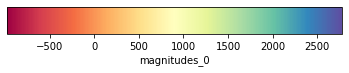

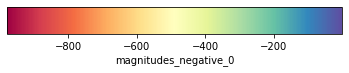

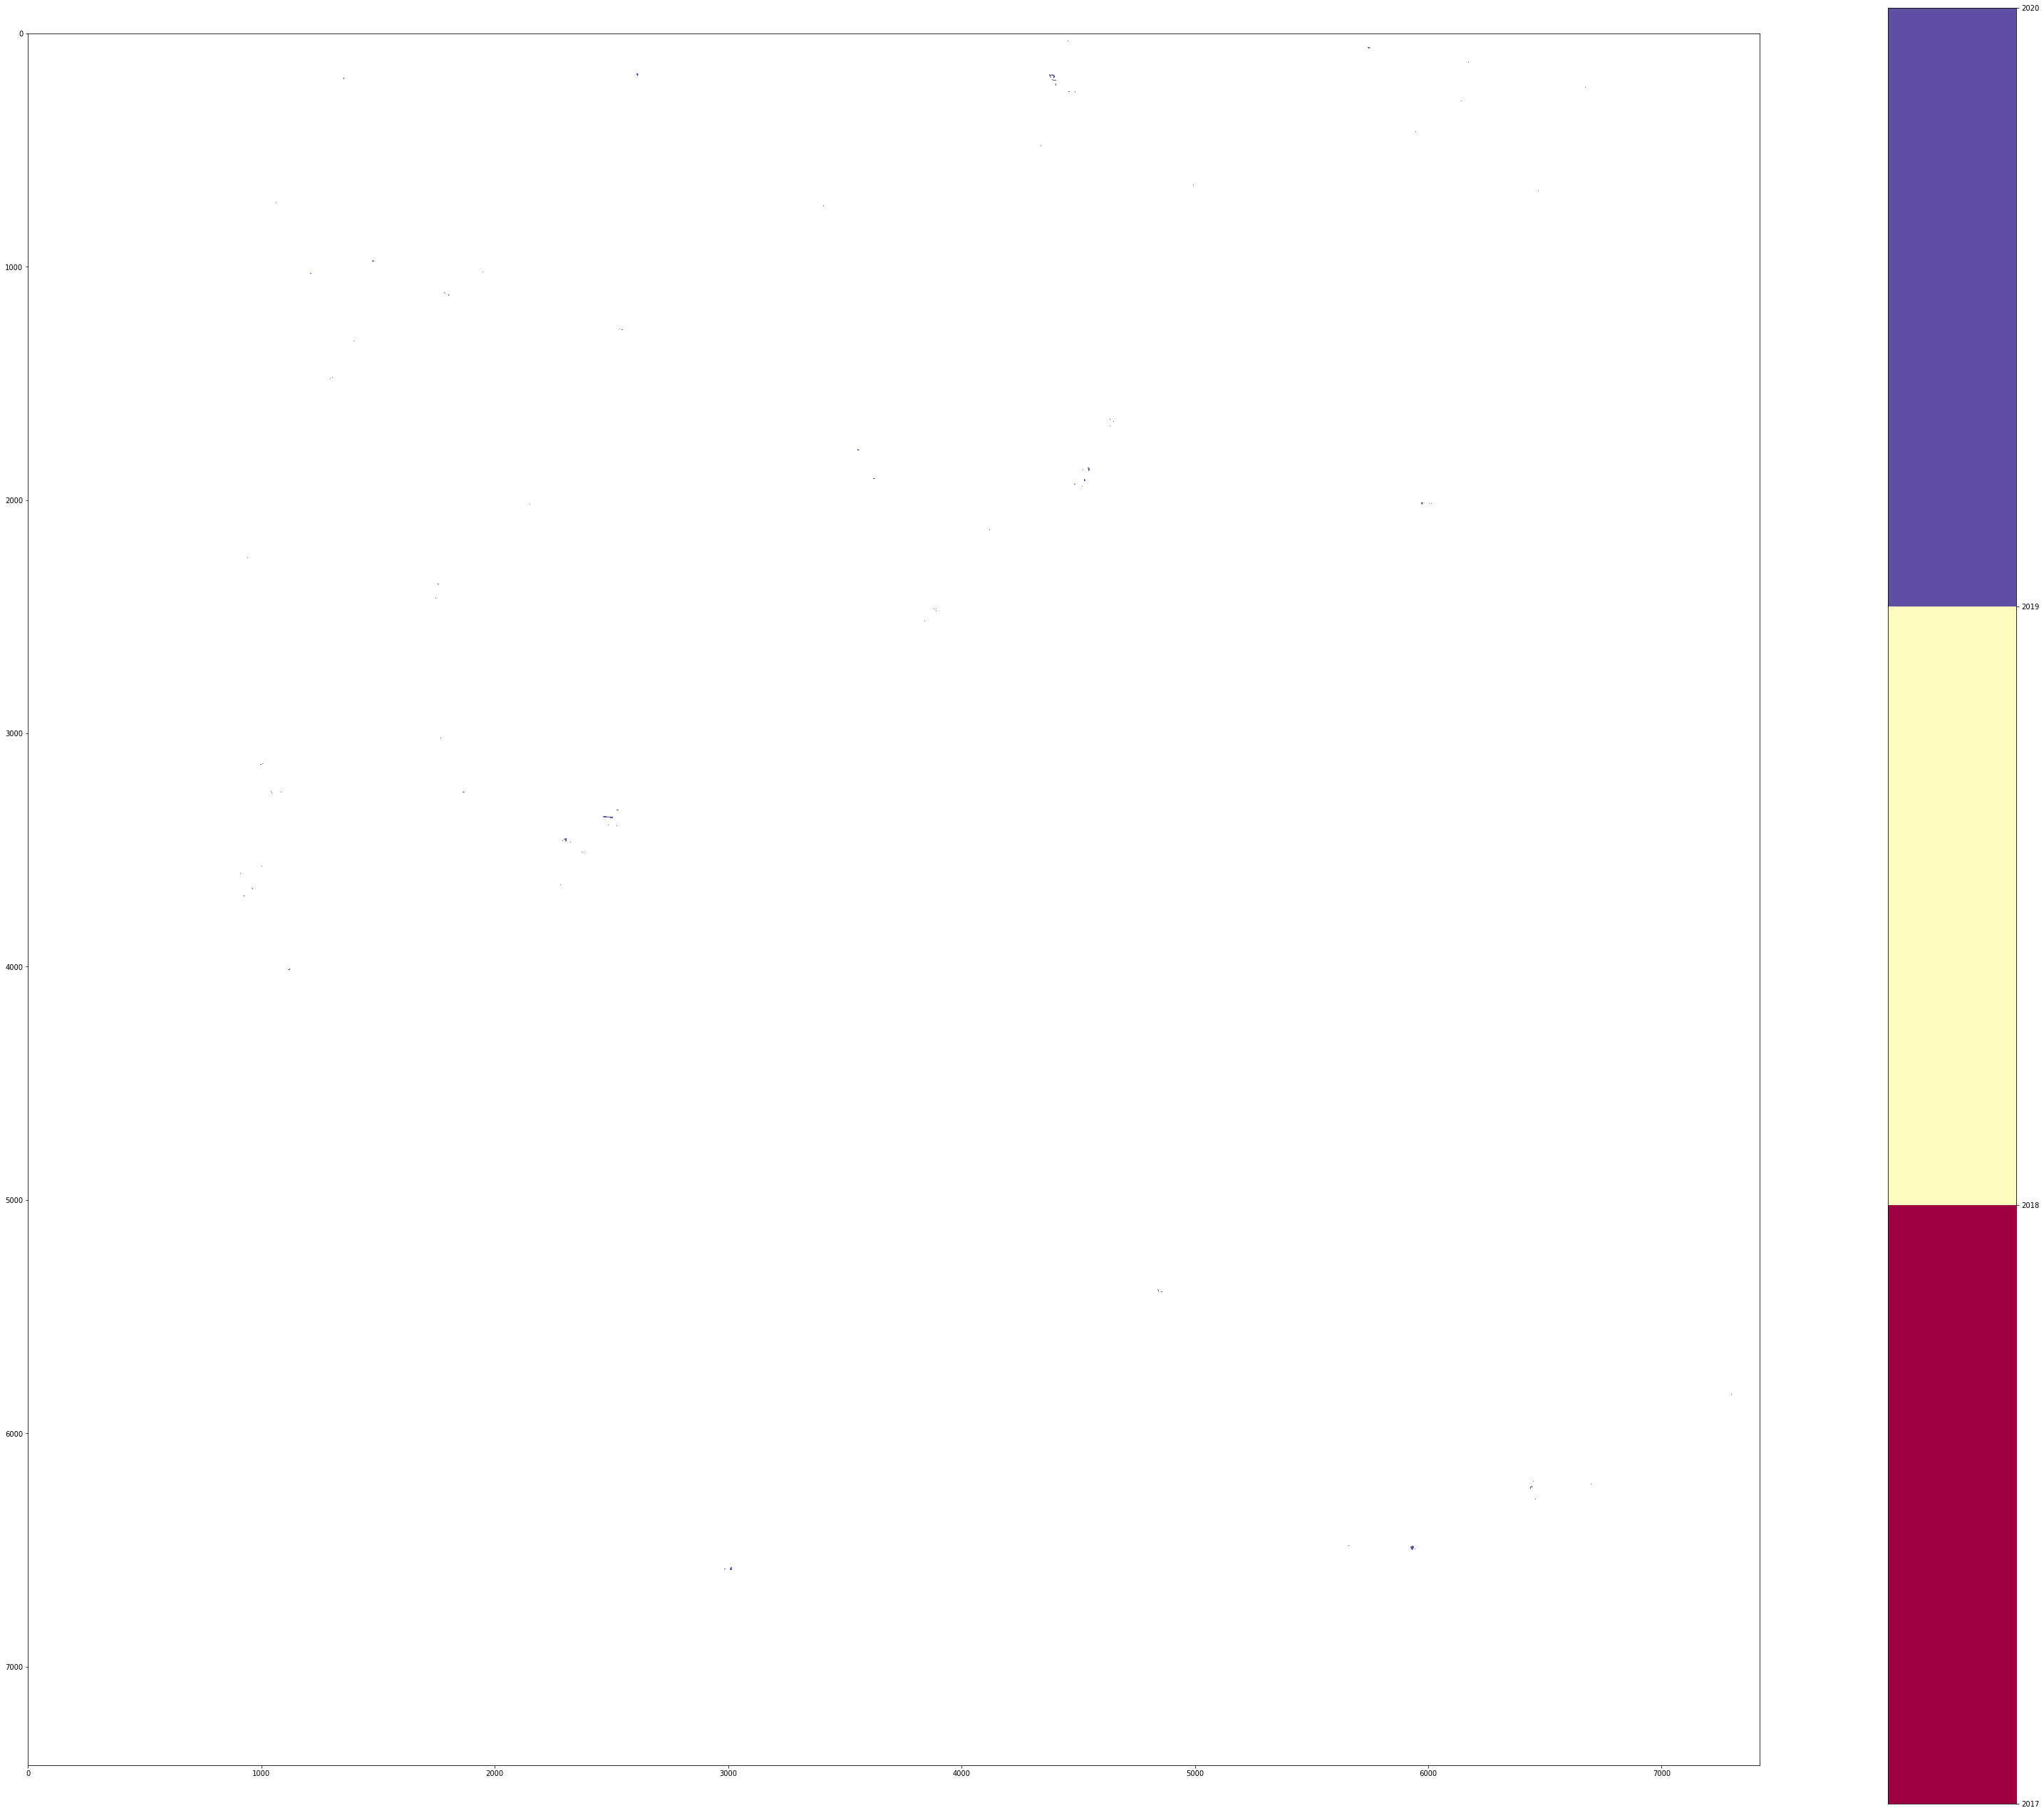

min_lat  6.739790082163535
max_lat  4.739331775957773
min_lon  -3.255494589649146
max_lon  -1.2553057780286196
saved in stored_time_series/Ghana/0/corners.json
percentage breaks found 25.314876277306436
percentage cells lacking data to find results found 0.0
stored_time_series/Ghana/2/numpy_arrays/magnitudes.npy
stored_time_series/Ghana/2/numpy_arrays/breaks.npy
arrays saved in stored_time_series/Ghana/2/numpy_arrays
png saved in stored_time_series/Ghana/2/pngs/magnitudes_2.png
colorbar saved in stored_time_series/Ghana/2/colorbars/colorbar_magnitudes_2.png
Geotiff saved in stored_time_series/Ghana/2/geotifs/magnitudes_2.tif
Geotiff saved in stored_time_series/Ghana/2/geotifs/breaks_indexed_2.tif
mean:  -30.44533
stdev:  152.41454
max value:  2132.7722
min value:  -2151.0093
uint16 set
Geotiff saved in stored_time_series/Ghana/2/geotifs/magnitudes_classified_2.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: ResourceWarning: unclosed file <_io.BufferedReader name=66>


png saved in stored_time_series/Ghana/2/pngs/magnitudes_negative_2.png
colorbar saved in stored_time_series/Ghana/2/colorbars/colorbar_magnitudes_negative_2.png
Geotiff saved in stored_time_series/Ghana/2/geotifs/magnitudes_negative_2.tif
Geotiff saved in stored_time_series/Ghana/2/geotifs/breaks_binary_2.tif
Geotiff saved in stored_time_series/Ghana/2/geotifs/breaks_binary_negative_2.tif
Geotiff saved in stored_time_series/Ghana/2/geotifs/breaks_julian_2.tif
Geotiff saved in stored_time_series/Ghana/2/geotifs/breaks_julian_negative_2.tif
Geotiff saved in stored_time_series/Ghana/2/geotifs/breaks_year_2.tif
Geotiff saved in stored_time_series/Ghana/2/geotifs/breaks_year_negative_2.tif
{2017: 0, 2018: 117, 2019: 234, 2020: 351}


/home/dven/bfastmonitor_cpu/dven/plotting_funcs.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)


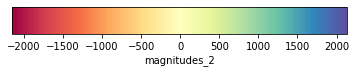

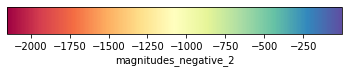

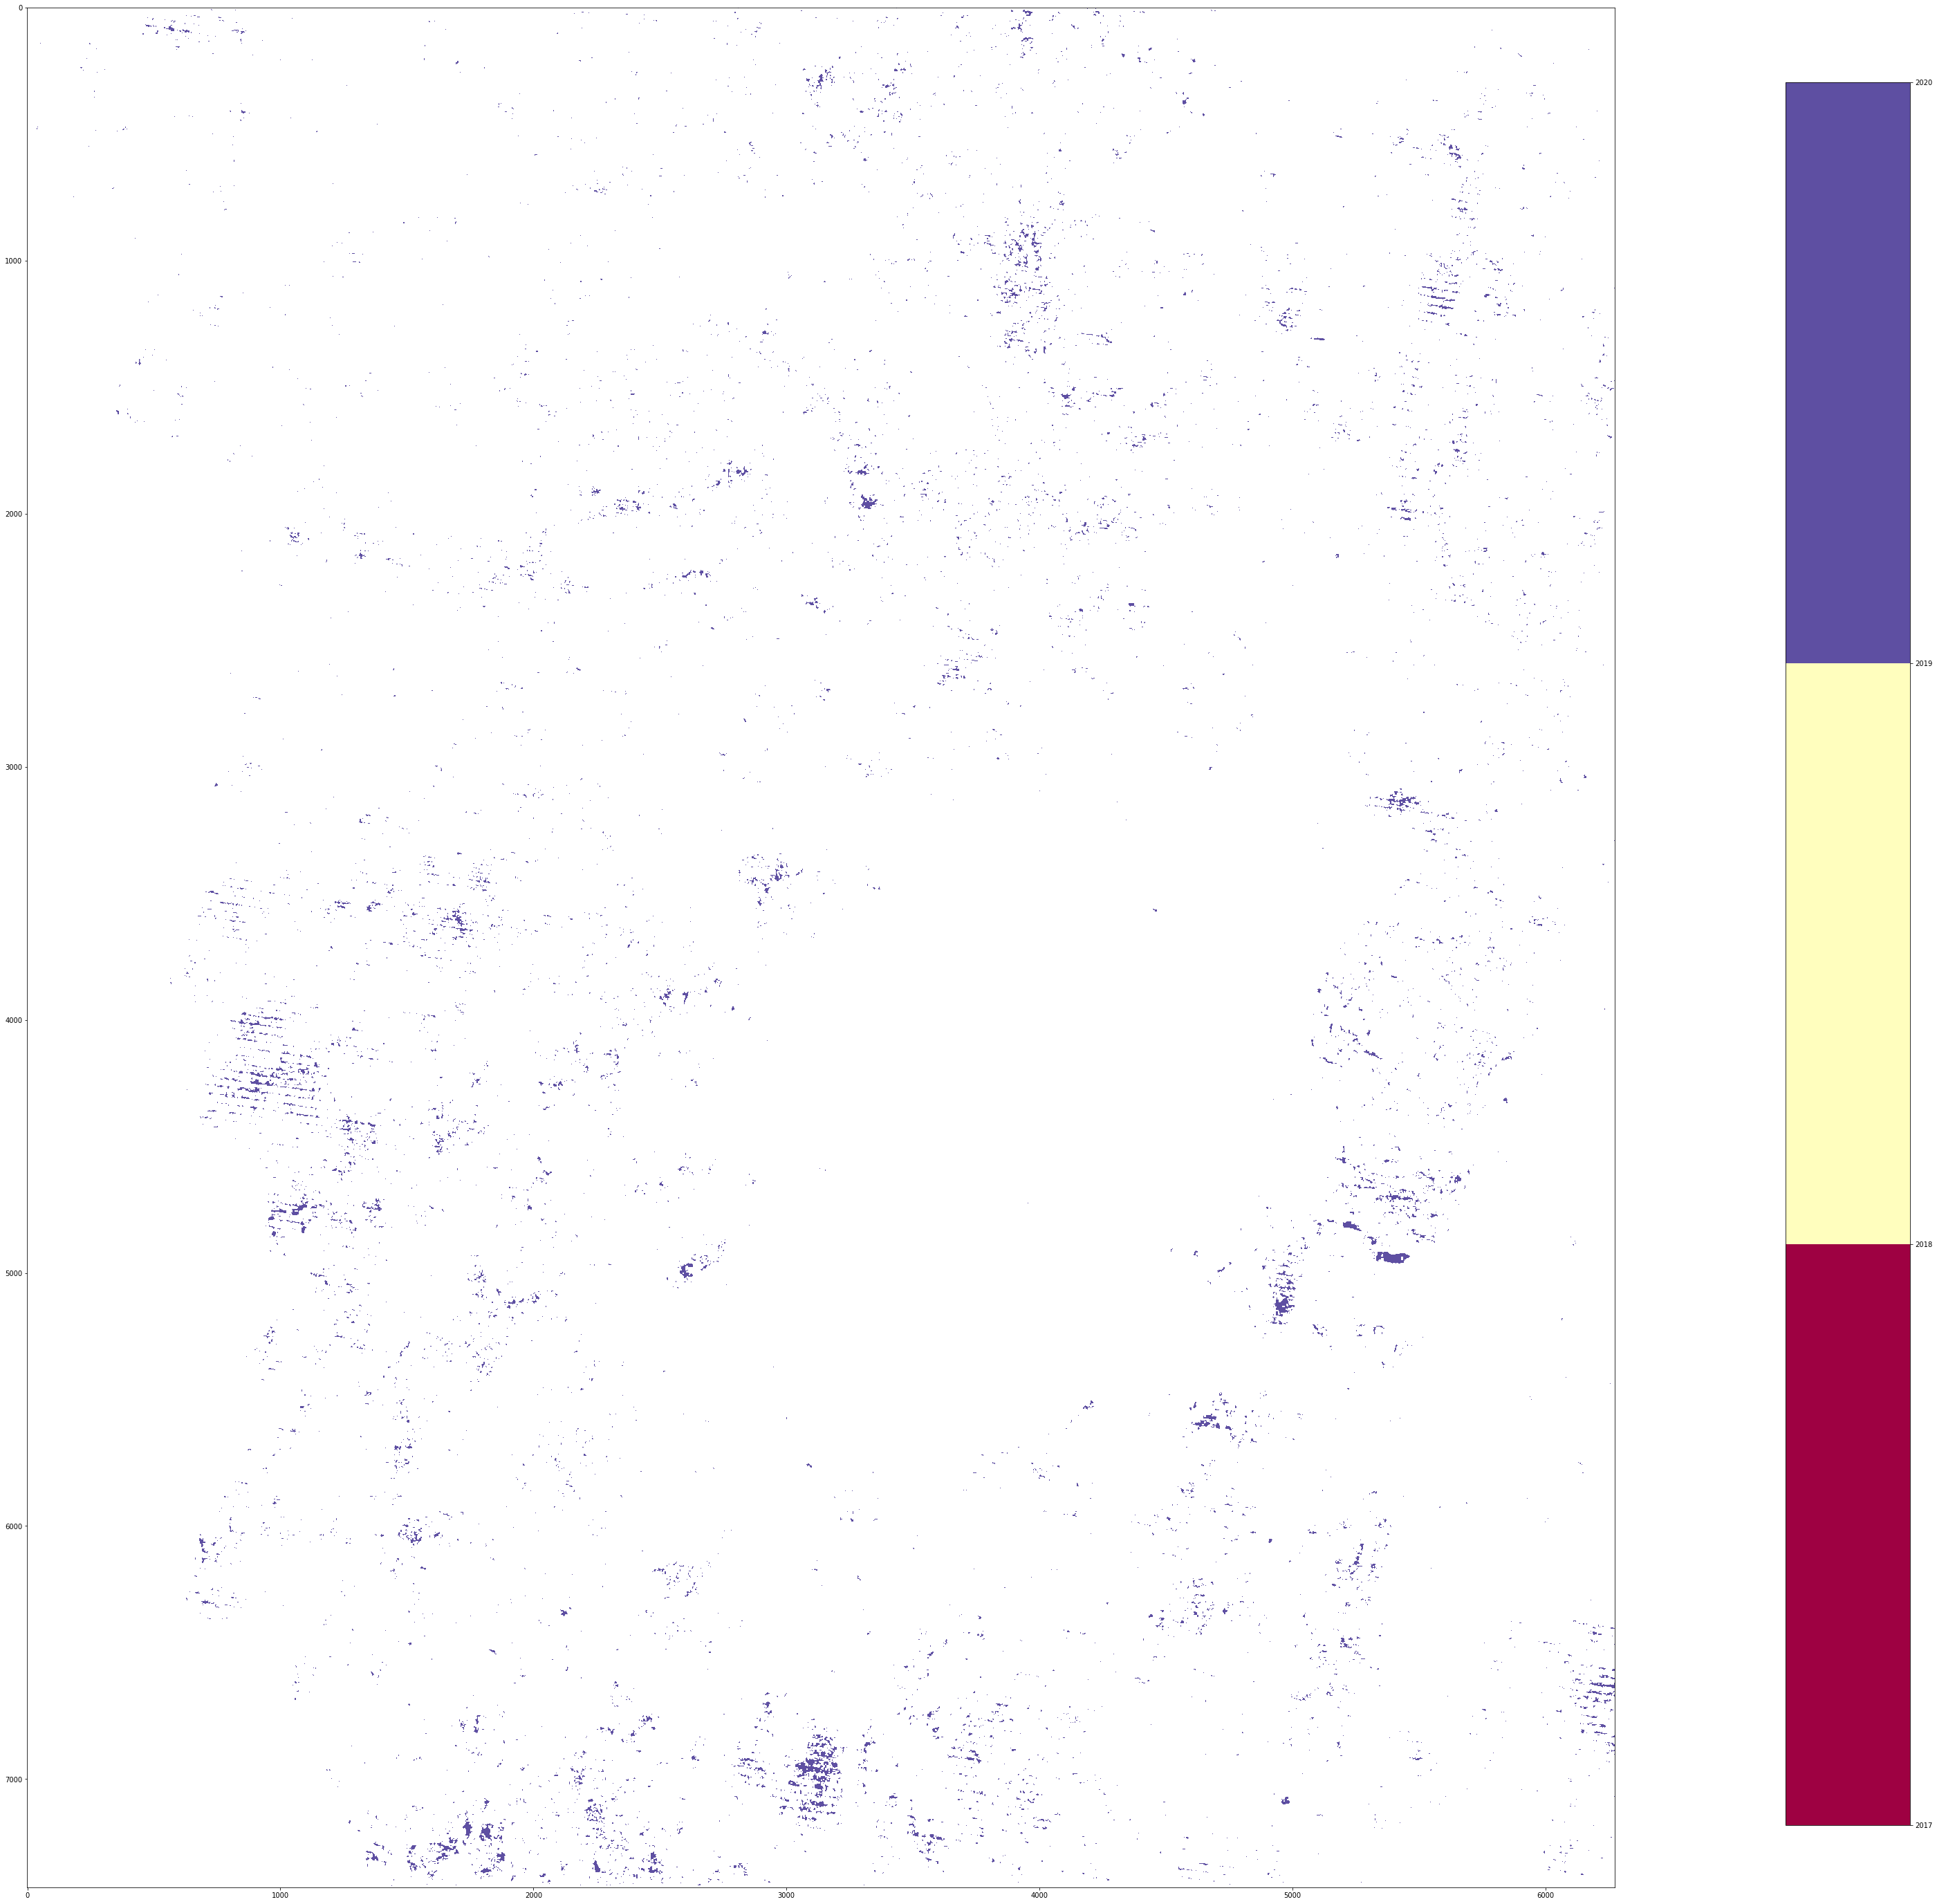

min_lat  10.740437199989824
max_lat  8.808700013019203
min_lon  -2.945845311213147
max_lon  -1.2900705795240435
saved in stored_time_series/Ghana/2/corners.json
percentage breaks found 24.984973408200563
percentage cells lacking data to find results found 0.0
stored_time_series/Ghana/1/numpy_arrays/magnitudes.npy
stored_time_series/Ghana/1/numpy_arrays/breaks.npy
arrays saved in stored_time_series/Ghana/1/numpy_arrays
png saved in stored_time_series/Ghana/1/pngs/magnitudes_1.png
colorbar saved in stored_time_series/Ghana/1/colorbars/colorbar_magnitudes_1.png
Geotiff saved in stored_time_series/Ghana/1/geotifs/magnitudes_1.tif
Geotiff saved in stored_time_series/Ghana/1/geotifs/breaks_indexed_1.tif
mean:  -14.534401
stdev:  90.03353
max value:  1762.1802
min value:  -2495.5156
uint16 set
Geotiff saved in stored_time_series/Ghana/1/geotifs/magnitudes_classified_1.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: ResourceWarning: unclosed file <_io.BufferedReader name=67>


png saved in stored_time_series/Ghana/1/pngs/magnitudes_negative_1.png
colorbar saved in stored_time_series/Ghana/1/colorbars/colorbar_magnitudes_negative_1.png
Geotiff saved in stored_time_series/Ghana/1/geotifs/magnitudes_negative_1.tif
Geotiff saved in stored_time_series/Ghana/1/geotifs/breaks_binary_1.tif
Geotiff saved in stored_time_series/Ghana/1/geotifs/breaks_binary_negative_1.tif
Geotiff saved in stored_time_series/Ghana/1/geotifs/breaks_julian_1.tif
Geotiff saved in stored_time_series/Ghana/1/geotifs/breaks_julian_negative_1.tif
Geotiff saved in stored_time_series/Ghana/1/geotifs/breaks_year_1.tif
Geotiff saved in stored_time_series/Ghana/1/geotifs/breaks_year_negative_1.tif
{2017: 0, 2018: 64, 2019: 128, 2020: 186}


/home/dven/bfastmonitor_cpu/dven/plotting_funcs.py:209: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)


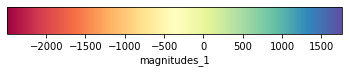

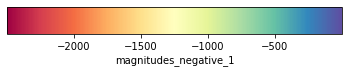

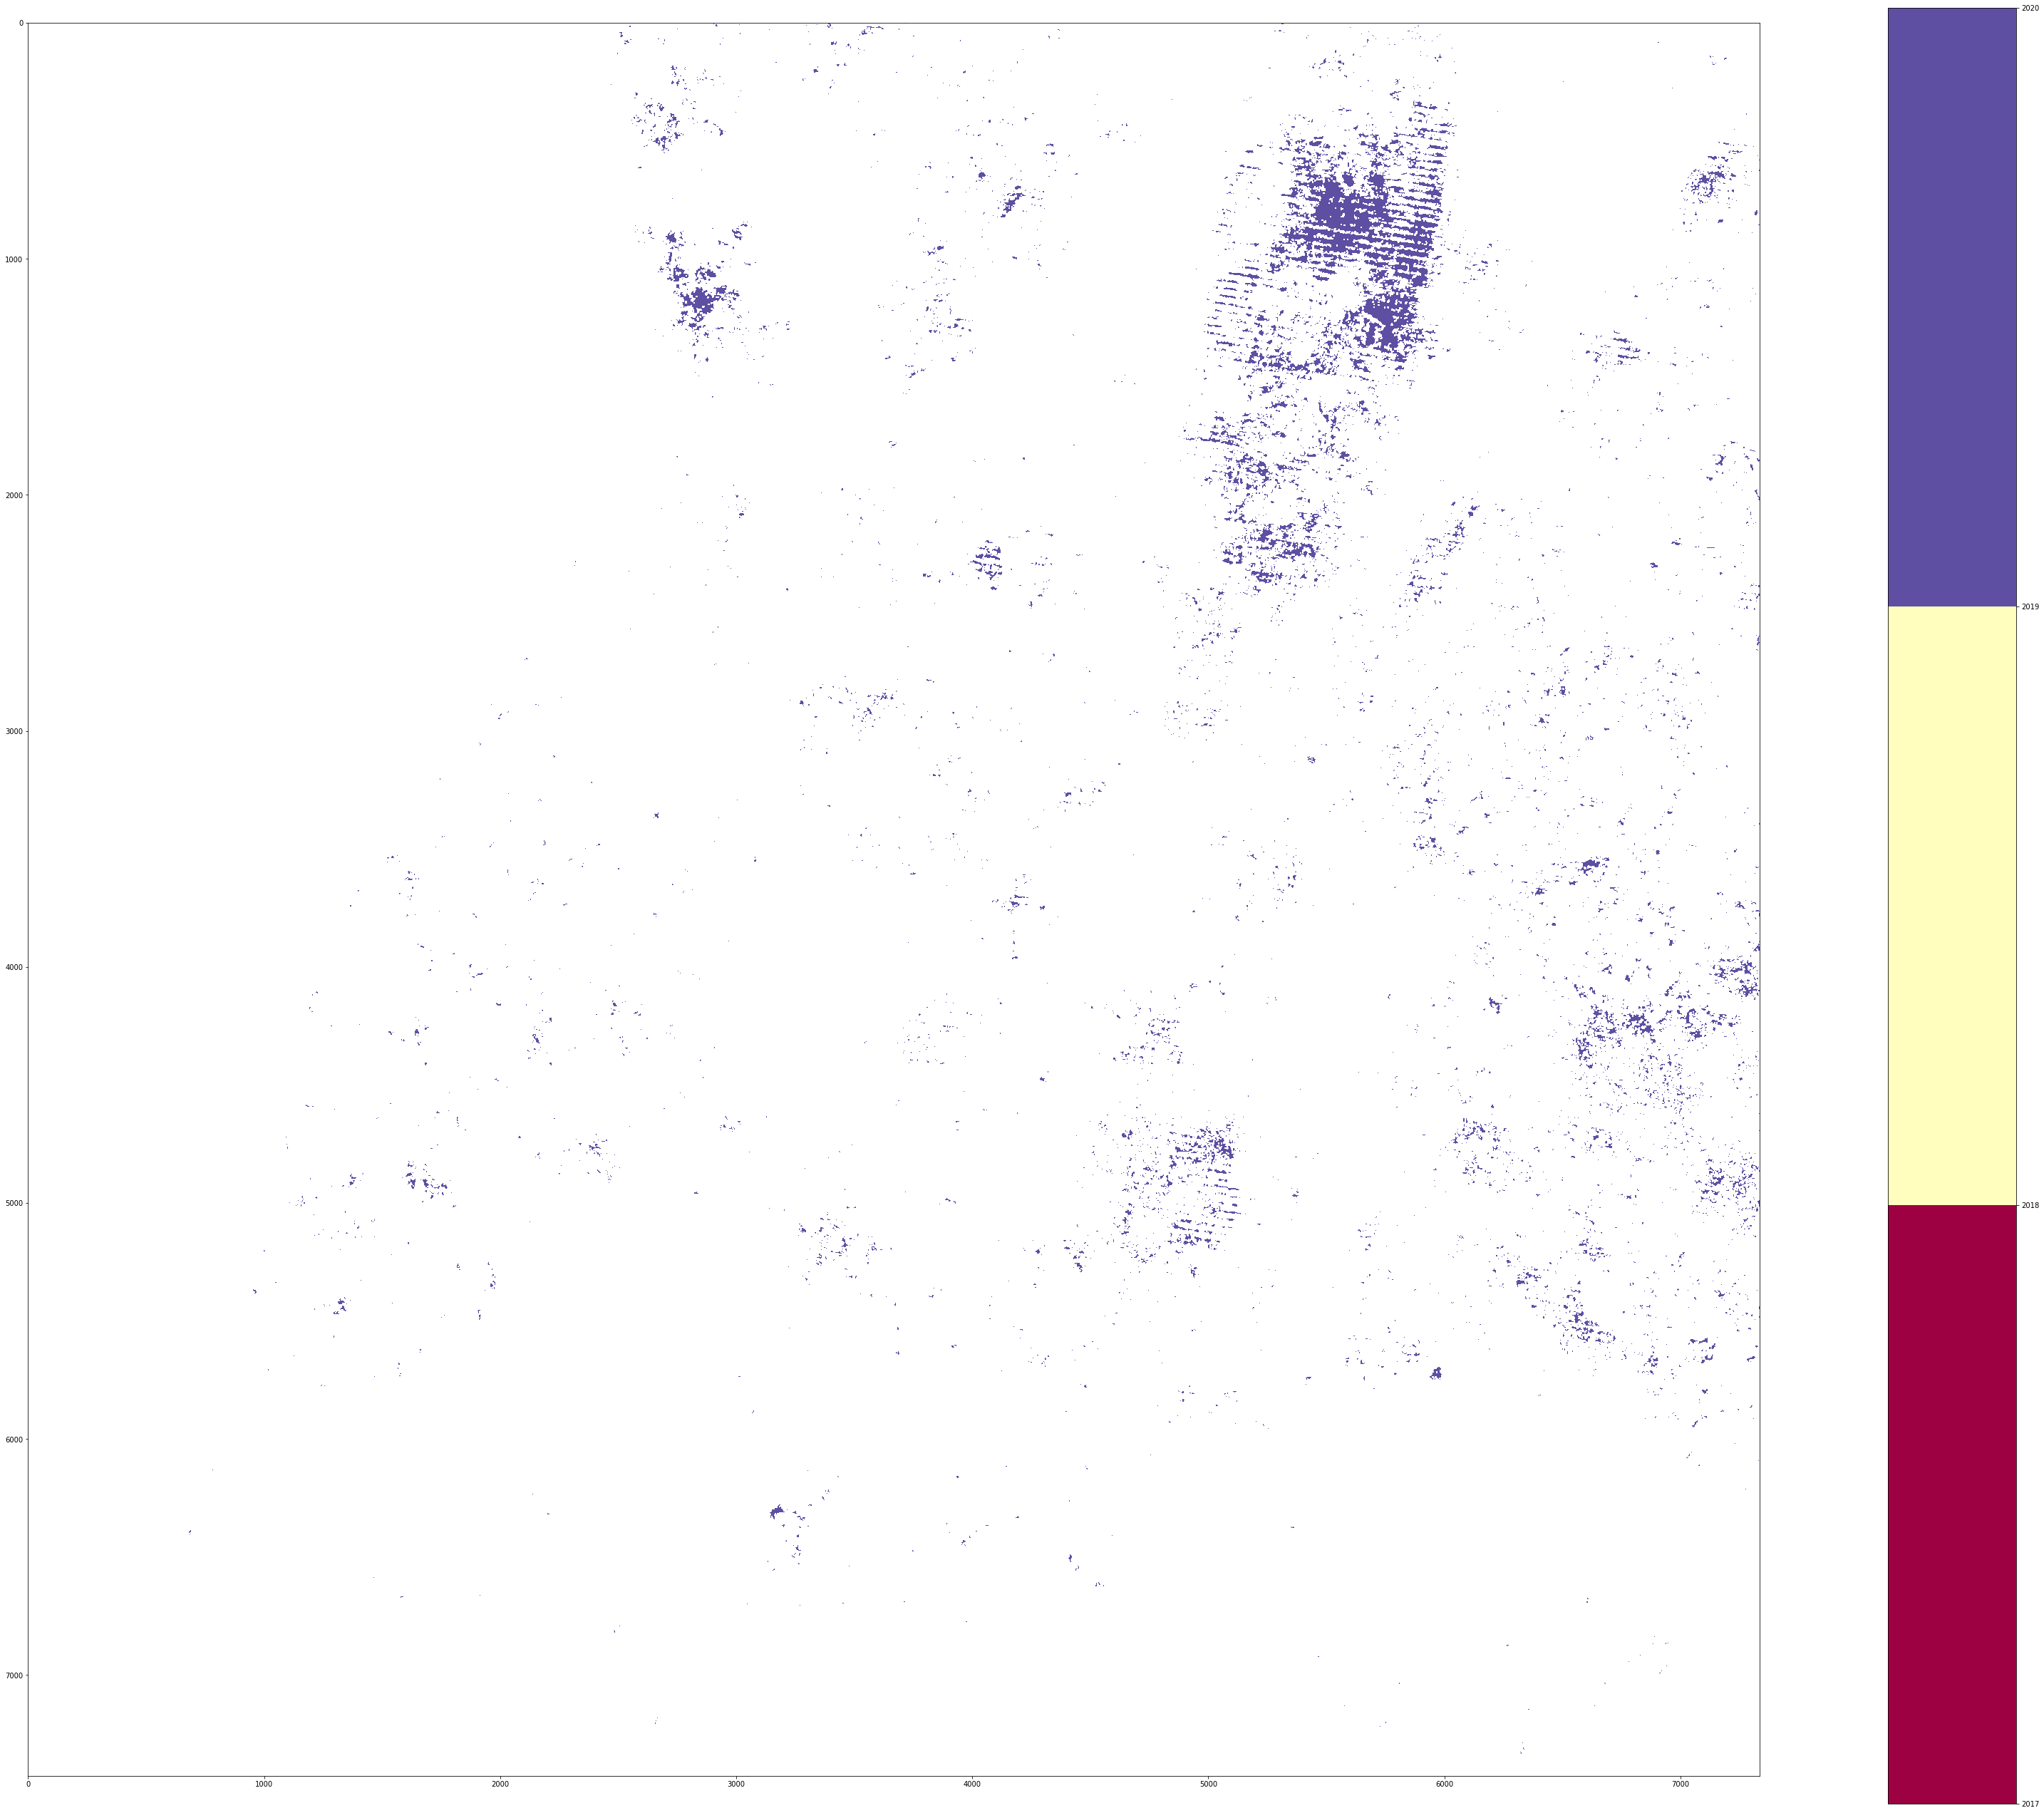

min_lat  8.740248388369297
max_lat  6.738712103822591
min_lon  -3.2325875499040984
max_lon  -1.2553057780286196
saved in stored_time_series/Ghana/1/corners.json


In [19]:
for data_list in run_dict:
    save_location = base_output_dir + "/" + data_list
    tiles_data = run_dict[data_list]
    
    perc_lacking_data_sum, perc_breaks_sum= 0,0
    for tile in tiles_data:
        minus2count,minus1count,perc_lacking_data,perc_breaks = tile.check_arrays()
        perc_breaks_sum += perc_breaks
        perc_lacking_data_sum+= perc_lacking_data
        
    print("percentage breaks found", perc_breaks_sum/len(tiles_data))
    print("percentage cells lacking data to find results found", perc_lacking_data_sum/len(tiles_data))
    
    if len(tiles_data) > 1:
        means_orig, breaks_orig = merge_tiles(tiles_data,output_dir_name = save_location)
    else:
        means_orig = tiles_data[0].means_array
        breaks_orig = tiles_data[0].breaks_array
    
    save_plot(means_orig, save_location, save_name = "magnitudes_" + data_list)
    export_GTiff(tiles_data, output_dir = save_location, array = means_orig, output_name = "magnitudes_" + data_list + ".tif")
    export_GTiff(tiles_data, output_dir = save_location, array = breaks_orig, output_name = "breaks_indexed_" + data_list + ".tif")

    classified_means = classify_magnitudes(means_orig)
    classified_means = np.nan_to_num(classified_means,nan=0).astype("uint16")
    export_GTiff(tiles_data, output_dir = save_location, array = classified_means, output_name = "magnitudes_classified_" + data_list + ".tif")
    
    # add colors to classified raster
    func = "oft-addpct.py"
    clas_tif = save_location + "/geotifs/magnitudes_classified_" + data_list + ".tif"
    clas_tif_result = save_location + "/geotifs/magnitudes_classified_" + data_list + "_result.tif"
    color_table = "color_table.txt"
    
    ps = subprocess.Popen(('echo', color_table), stdout=subprocess.PIPE)
    output = subprocess.check_output((func, clas_tif, clas_tif_result), stdin=ps.stdout)
    ps.wait()
    
    # select only negative magnitudes
    means_neg, breaks_indexed, breaks_indexed_neg, binary_breaks, negative_binary_breaks = select_negatives(means_orig, breaks_orig)
    save_plot(means_neg, output_dir = save_location, save_name = "magnitudes_negative_" + data_list)

    # save negative means and breaks
    export_GTiff(tiles_data, output_dir = save_location, array = means_neg ,output_name = "magnitudes_negative_" + data_list + ".tif")
    export_GTiff(tiles_data, output_dir = save_location, array = binary_breaks ,output_name = "breaks_binary_" + data_list + ".tif")
    export_GTiff(tiles_data, output_dir = save_location, array = negative_binary_breaks ,output_name = "breaks_binary_negative_" + data_list + ".tif")

    dates_monitor = []
    dates = tiles_data[0].cropped_dates

    # collect dates for monitor period
    for i in range(len(dates)):
        if start_monitor <= dates[i]:
            dates_monitor.append(dates[i])
    dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period
    
    # julian_date output
    julian_breaks, year_breaks = get_julian_dates(dates_array,breaks_indexed)
    negative_julian_breaks, negative_year_breaks = get_julian_dates(dates_array,breaks_indexed_neg)

    # save negative means and breaks
    export_GTiff(tiles_data, output_dir = save_location, array = julian_breaks ,output_name = "breaks_julian_" + data_list + ".tif")
    export_GTiff(tiles_data, output_dir = save_location, array = negative_julian_breaks ,output_name = "breaks_julian_negative_" + data_list + ".tif")

    export_GTiff(tiles_data, output_dir = save_location, array = year_breaks, output_name = "breaks_year_" + data_list + ".tif")
    export_GTiff(tiles_data, output_dir = save_location, array = negative_year_breaks, output_name = "breaks_year_negative_" + data_list + ".tif")
    
    # matplotlib
    breaks_years_neg, idx_starts, ticklist = classify_output(start_monitor,end_monitor,breaks_indexed_neg,dates_array)
    plot_output_matplotlib(idx_starts,breaks_years_neg,ticklist)

    # for plotting folium map
    set_corners(save_location, tiles_data)
    
    


### Display webmap

In [17]:
display(plot_display_data_chooser)

interactive(children=(Dropdown(description='data to plot', layout=Layout(height='auto', width='500px'), option…

In [1]:
if not plot_display_data_chooser.result:
    print("make sure to run the block above")

m = merge_plots2(data_list = run_dict[data_list], base_output_dir=base_output_dir,plot_name= plot_display_data_chooser.result)
m.save(base_output_dir + "/" +"0/" + plot_display_data_chooser.result + ".html")
m

NameError: name 'plot_display_data_chooser' is not defined